# Language in Space

## Session 09: file formats; raster data; map making; projections

### Gerhard Jäger

December 23, 2021


In [1]:
options(repr.plot.width=12, repr.plot.height=9)


In [2]:
library(tidyverse)
library(sf)
library(spData)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.6.2, GDAL 2.2.3, PROJ 4.9.3

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



## Reading and writing vector data to/from disk

There is a wide variety of file formats for storing vector geometries. In many cases, they can be retrieved via `read_sf`. 

The most common file format is a **shapefile**. 

Somewhat confusingly, a shapefile is actually not a single file, but a collection of files with the same basename which reside in the same directory. Mandatory files are (info from Wikipedia):

- .shp — shape format; the feature geometry itself {content-type: x-gis/x-shapefile}
- .shx — shape index format; a positional index of the feature geometry to allow seeking forwards and backwards quickly {content-type: x-gis/x-shapefile}
- .dbf — attribute format; columnar attributes for each shape, in dBase IV format {content-type: application/octet-stream OR text/plain}



Optionally, the following files can be present:

- .prj — projection description, using a well-known text representation of coordinate reference systems {content-type: text/plain OR application/text}
- .sbn and .sbx — a spatial index of the features {content-type: x-gis/x-shapefile}
- .fbn and .fbx — a spatial index of the features that are read-only {content-type: x-gis/x-shapefile}
- .ain and .aih — an attribute index of the active fields in a table {content-type: x-gis/x-shapefile}
- .ixs — a geocoding index for read-write datasets {content-type: x-gis/x-shapefile}
- .mxs — a geocoding index for read-write datasets (ODB format) {content-type: x-gis/x-shapefile}
- .atx — an attribute index for the .dbf file in the form of shapefile.columnname.atx (ArcGIS 8 and later) {content-type: x-gis/x-shapefile }
- .shp.xml — geospatial metadata in XML format, such as ISO 19115 or other XML schema {content-type: application/fgdc+xml}
- .cpg — used to specify the code page (only for .dbf) for identifying the character encoding to be used {content-type: text/plain OR x-gis/x-shapefile }
- .qix — an alternative quadtree spatial index used by MapServer and GDAL/OGR software {content-type: x-gis/x-shapefile}

The `.shp` file is the main file which is named when reading in data.

In [3]:
german_districts <- read_sf("data/germany_districts/germany_districts.shp")


Vector data can be written to disk in many common formats using `write_sf`. Based on the filename extension, the function decides automatically which driver to use.

# Working with raster data

Next to vector data, **raster data** is a standard data format for geospatial computation. 

![Image from saylordotorg.github.io](img/layers.png)

In this course, we will use the R-package `terra` to manipulate raster data.

In [4]:
library(terra)

terra version 1.2.10



A raster object is essentially a list of two-dimensional arrays of equal size.

The two dimensions represent the two spatial dimensions. The list elements are *layers*.
The layers are stored as a collection of 1-dimensional vectors.

Additionally, a raster object contains information about 
- a coordinate reference system (CRS)
- the number of rows and columns
- the location of the upper left corner within the CRS
- the size of the pixels



In [5]:
elev = rast(nrows = 6, ncols = 6, resolution = 0.5, 
            xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5,
            vals = 36:1)

elev

class       : SpatRaster 
dimensions  : 6, 6, 1  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs  
source      : memory 
name        : lyr.1 
min value   :     1 
max value   :    36 

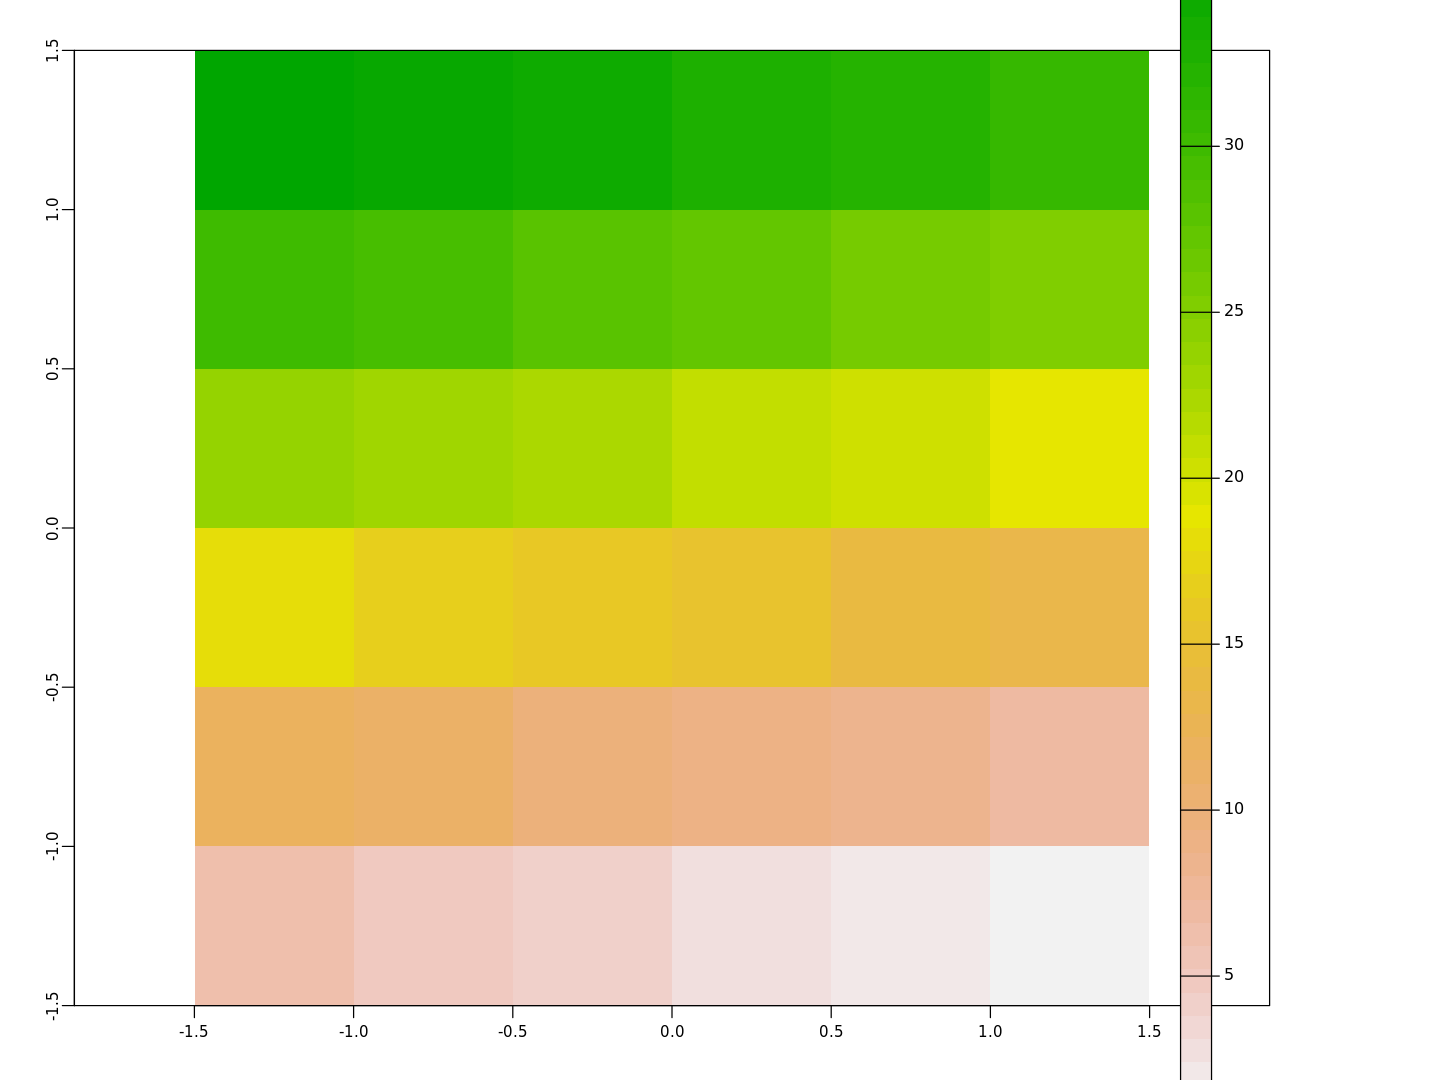

In [6]:
plot(elev)


In [7]:

grain_order = c("clay", "silt", "sand")
grain_char = sample(grain_order, 36, replace = TRUE)
grain_fact = factor(grain_char, levels = grain_order)
grain = rast(nrows = 6, ncols = 6, resolution = 0.5, 
             xmin = -1.5, xmax = 1.5, ymin = -1.5, ymax = 1.5,
             vals = grain_fact)


two_layers = c(grain, elev) 
names(two_layers) <- c("grain", "elev")


In [8]:

two_layers

class       : SpatRaster 
dimensions  : 6, 6, 2  (nrow, ncol, nlyr)
resolution  : 0.5, 0.5  (x, y)
extent      : -1.5, 1.5, -1.5, 1.5  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs  
sources     : memory  
              memory  
names       : grain, elev 
min values  :  clay,    1 
max values  :  silt,   36 

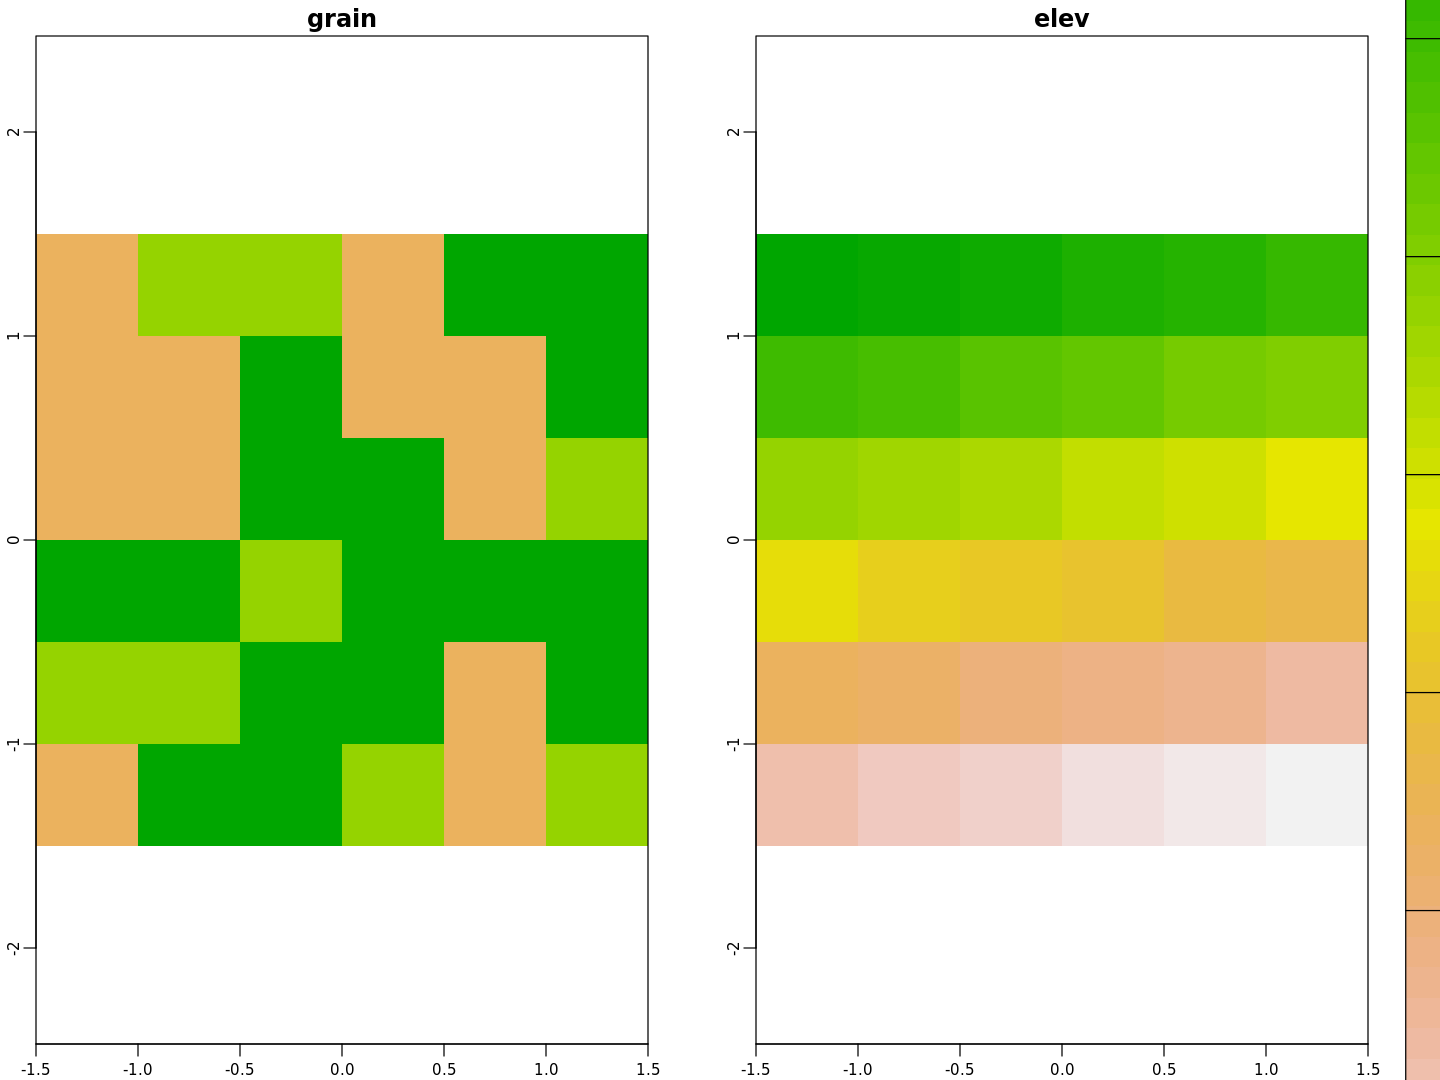

In [9]:
two_layers %>%
    plot()

## Retrieving values from a raster object



<img src="img/pixel.svg" alt="drawing" width="400"/>


If we know the pixel index of an object, we can simply use `R`'s indexing mechanism

In [16]:
elev[4,3]

lyr.1
1 16

If we only know the coordinates within the CRS, we can use `terra`'s function `cellFromXY`.

In [17]:
(id = cellFromXY(elev, matrix(c(-0.2, -0.2), ncol=2)))



[1] 21

In [18]:
elev[id]

lyr.1
1 16

## Raster-vector cropping

(example from https://geocompr.robinlovelace.net/geometric-operations.html#geo-ras)

Two objects:
- A `SpatRaster` object `srtm` representing elevation (meters above sea level) in south-western Utah.
- A vector (`sf`) object zion representing Zion National Park.



In [19]:
install.packages("spDataLarge", repos = "https://geocompr.r-universe.dev")


Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)



In [20]:
library(spDataLarge)

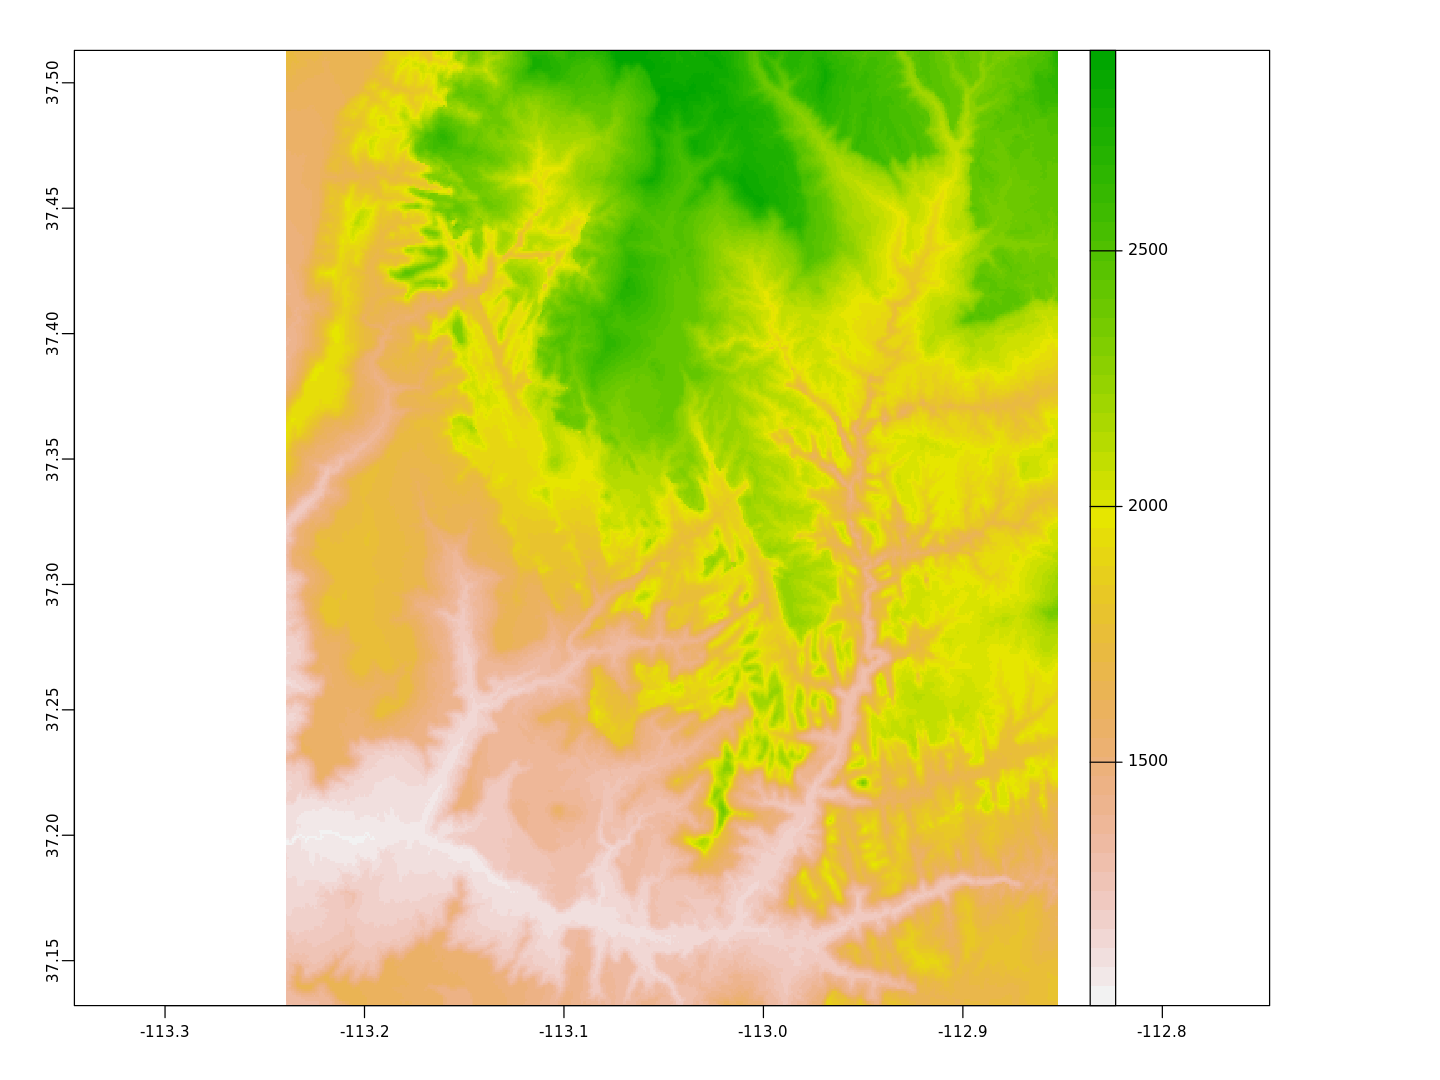

In [21]:
srtm = rast(system.file("raster/srtm.tif", package = "spDataLarge"))

plot(srtm)


Reading layer `zion' from data source `/srv/rlibs/spDataLarge/vector/zion.gpkg' using driver `GPKG'
Simple feature collection with 1 feature and 11 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 302903.1 ymin: 4112244 xmax: 334735.5 ymax: 4153087
proj4string:   +proj=utm +zone=12 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 


Warning message:
“plotting the first 9 out of 11 attributes; use max.plot = 11 to plot all”


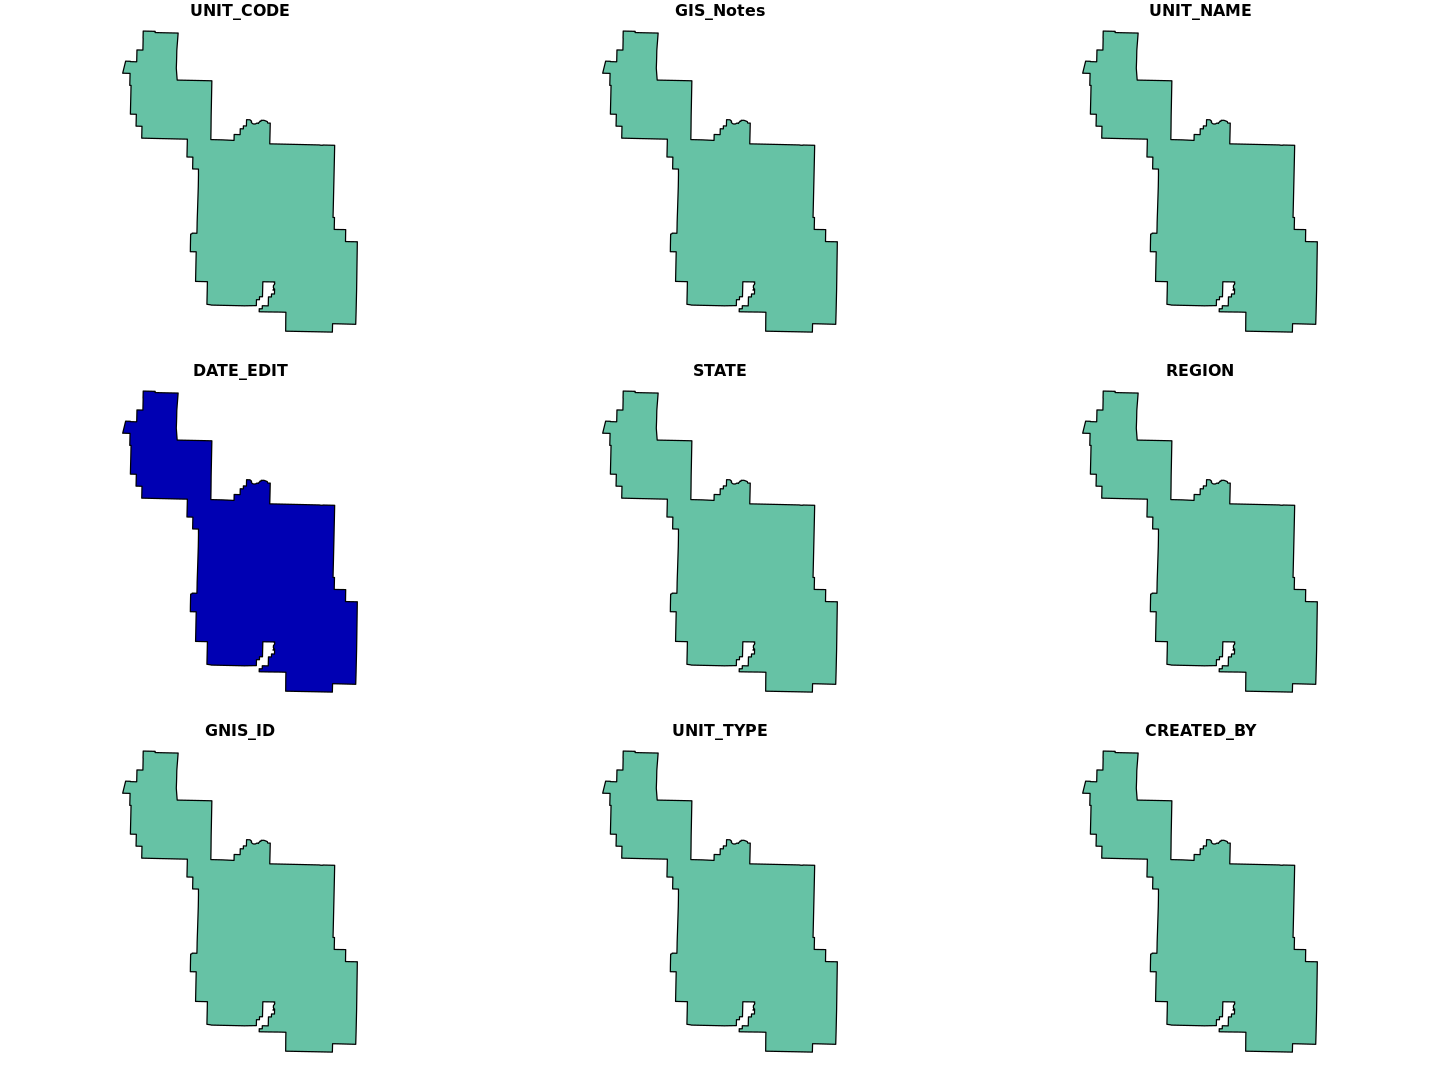

In [22]:
zion = st_read(system.file("vector/zion.gpkg", package = "spDataLarge"))
plot(zion)

We have to make sure that both objects have the same CRS/projection.

In [24]:
zion %>% st_crs()

Coordinate Reference System:
  No user input
  wkt:
PROJCS["UTM Zone 12, Northern Hemisphere",
    GEOGCS["GRS 1980(IUGG, 1980)",
        DATUM["unknown",
            SPHEROID["GRS80",6378137,298.257222101],
            TOWGS84[0,0,0,0,0,0,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-111],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]

In [25]:
zion = st_transform(zion, crs(srtm))

zion %>% st_crs()

Coordinate Reference System:
  User input: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]] 
  wkt:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]

**Cropping** reduces the size of the raster object to the smallest rectangle fully including the vector object.

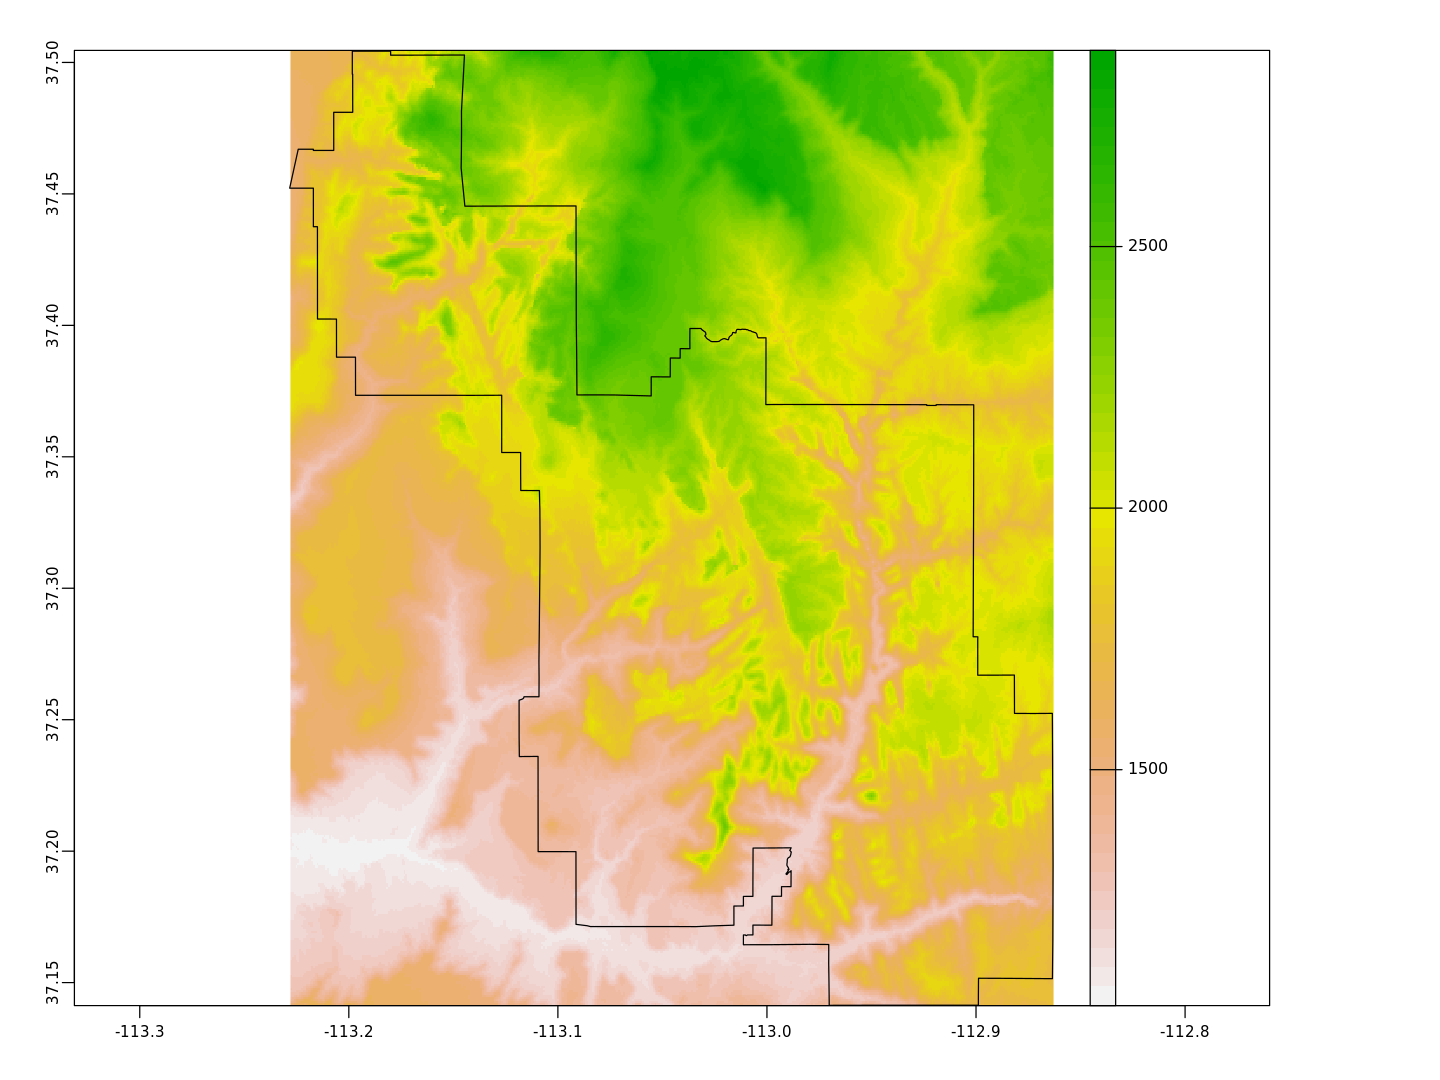

In [26]:
srtm_cropped = crop(srtm, vect(zion))

plot(srtm_cropped)
plot(vect(zion), add=T)

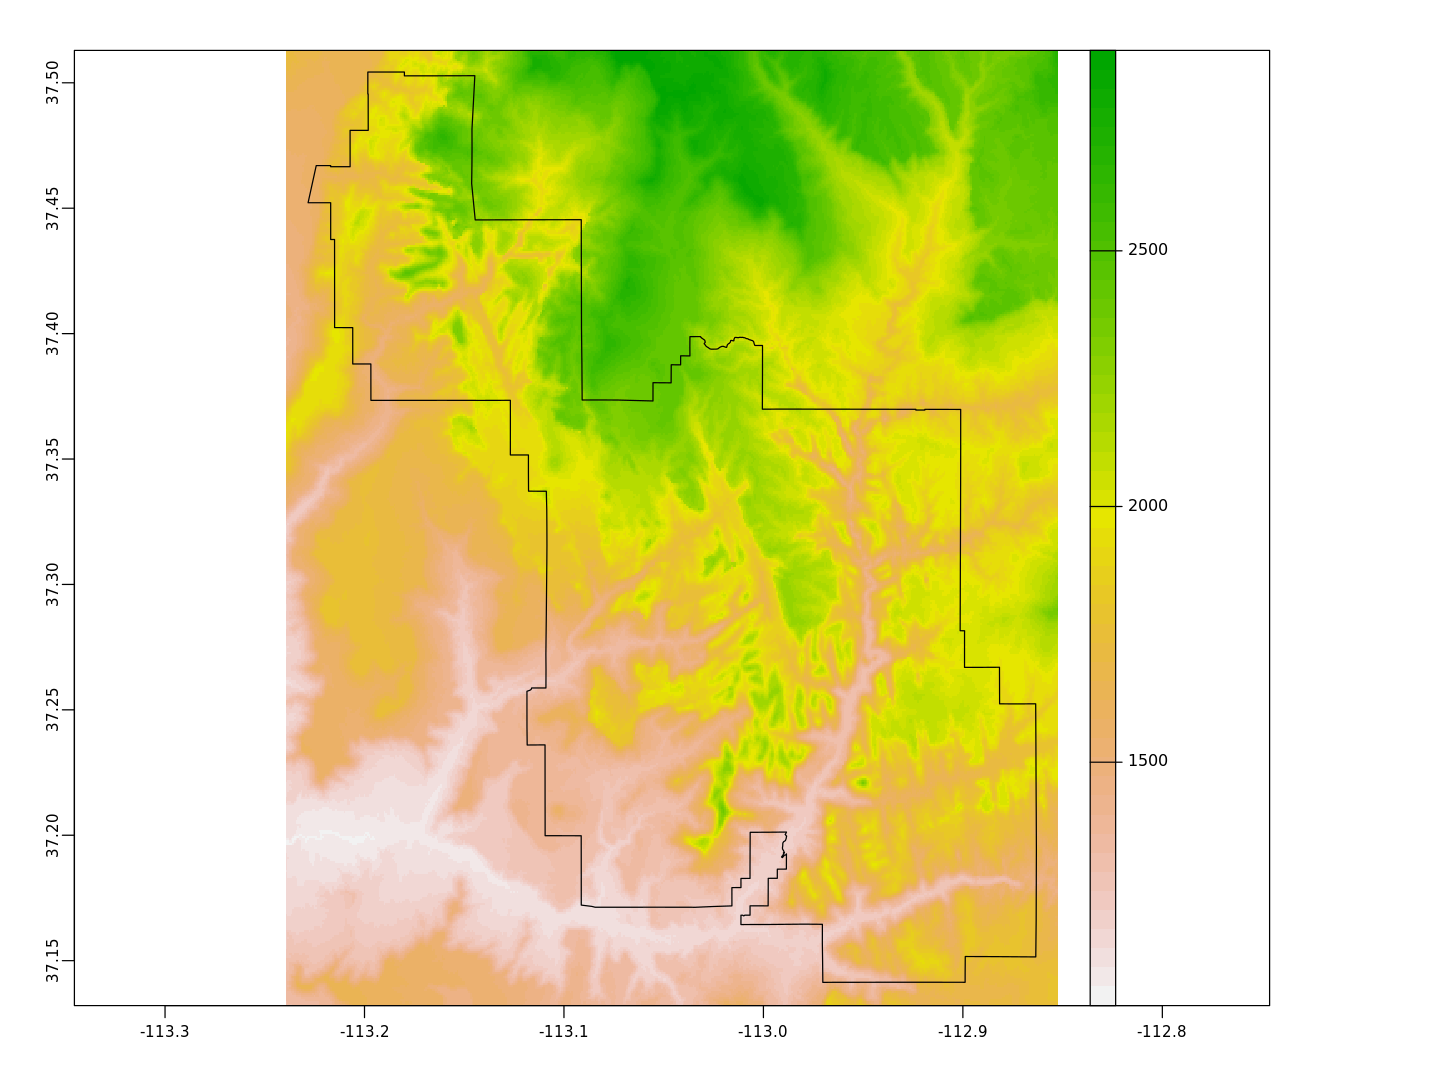

In [27]:
plot(srtm)
plot(vect(zion), add=T)

**Masking** sets all values of the raster object outside the boundaries of the vector object to `NA`.


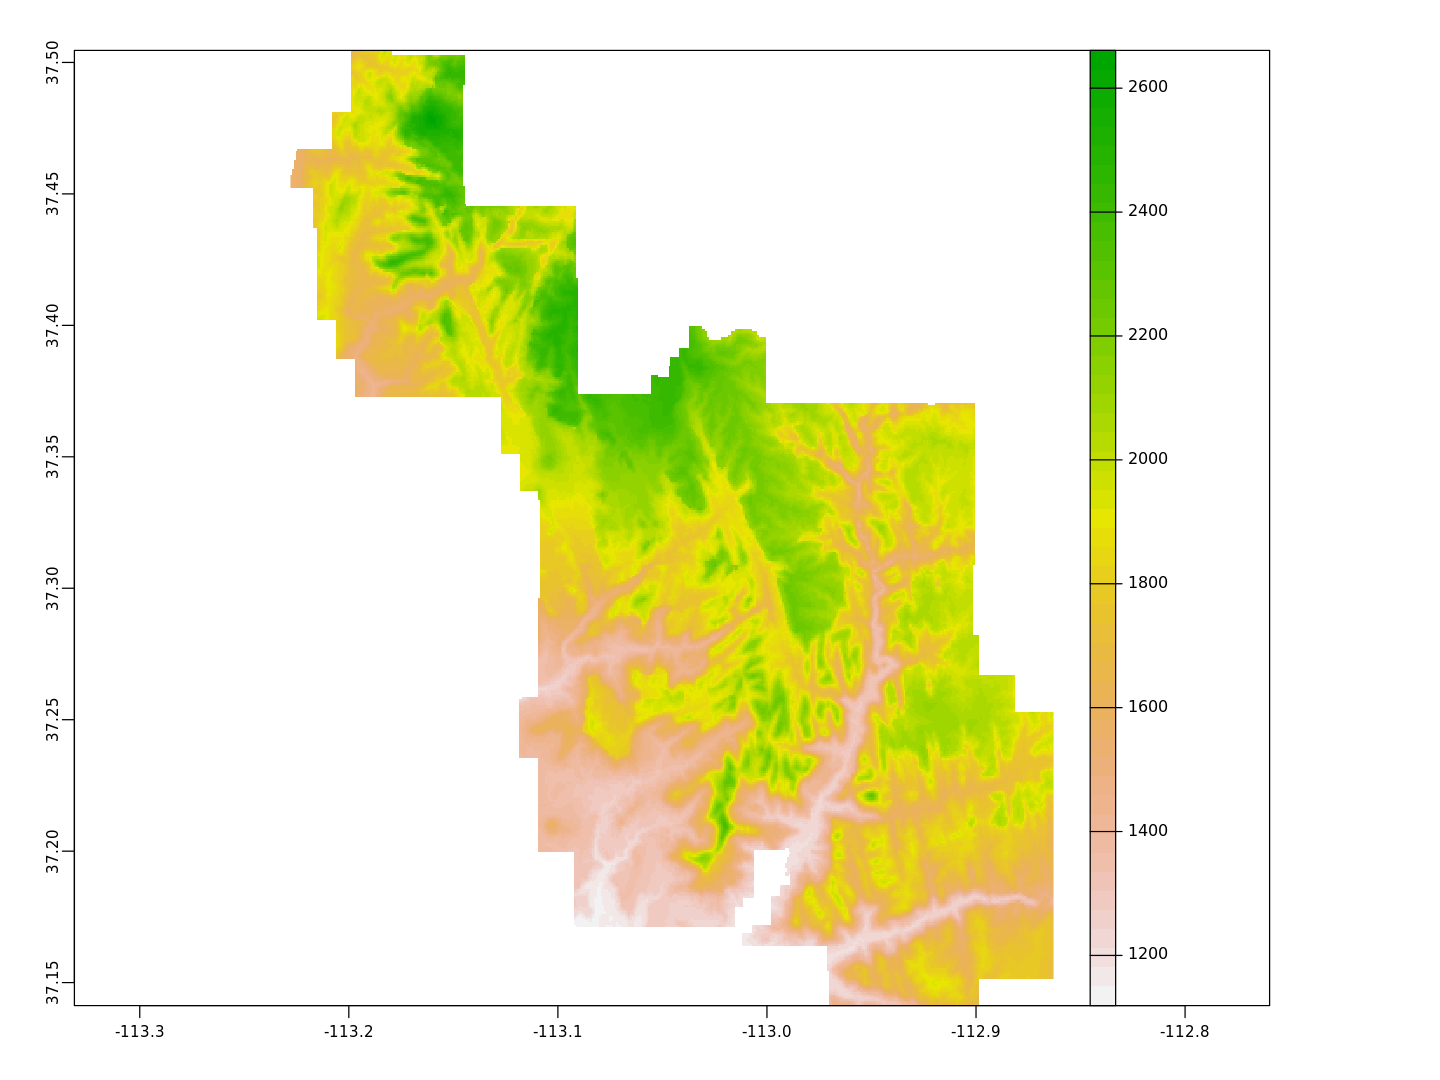

In [28]:
srtm_final = mask(srtm_cropped, vect(zion))
plot(srtm_final)

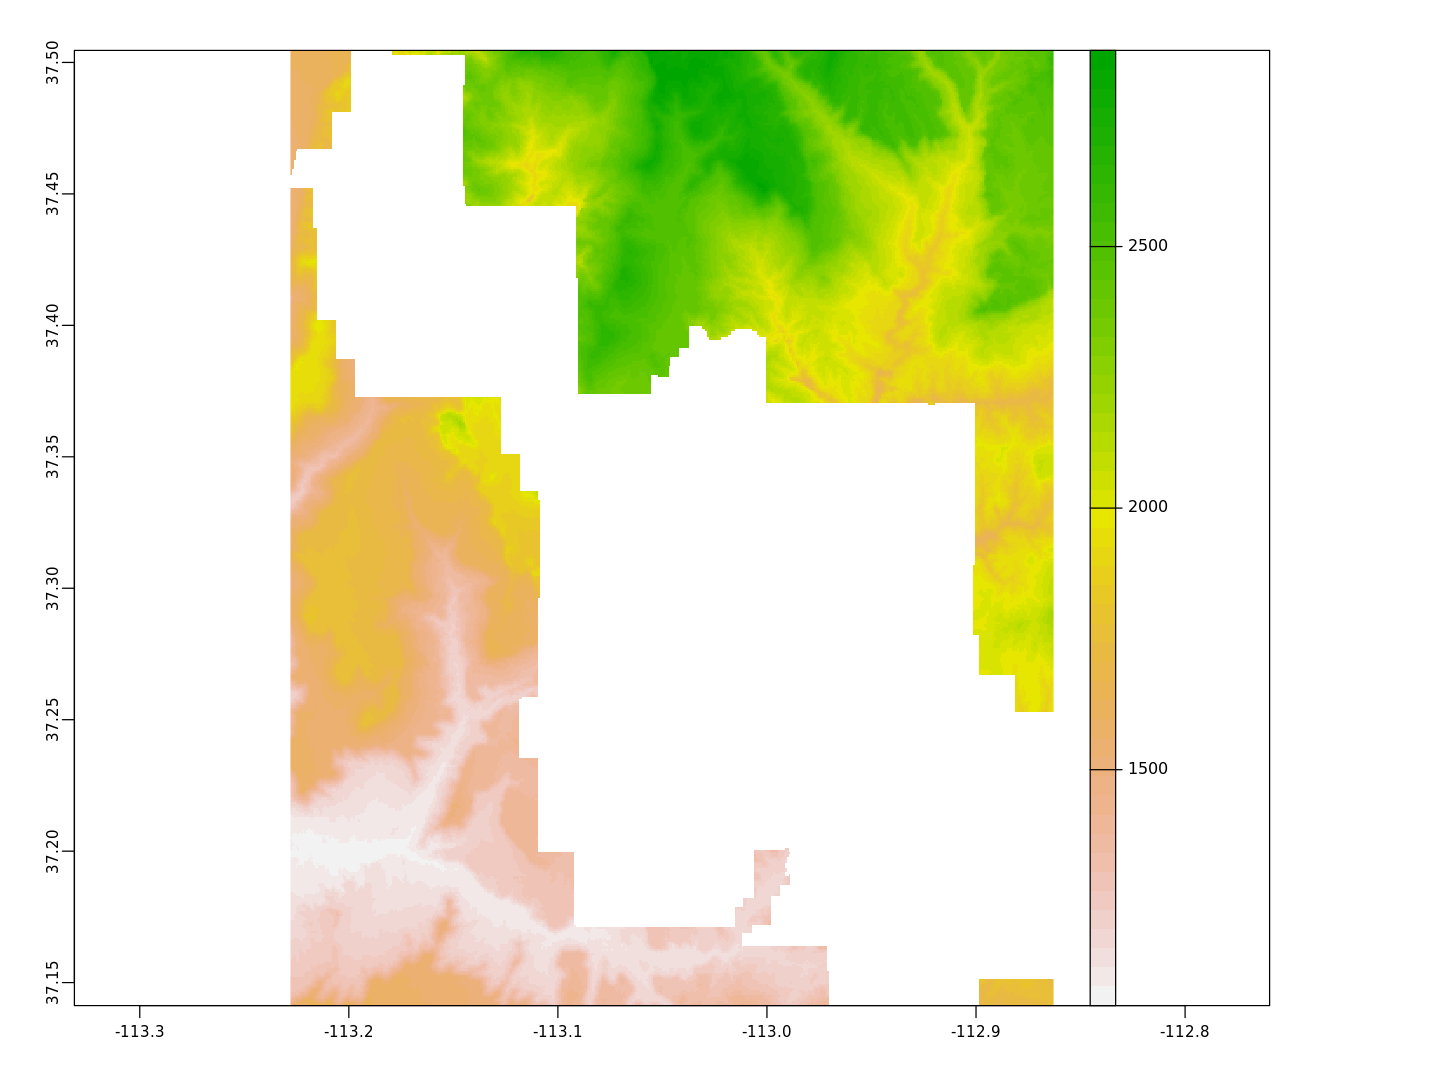

In [29]:
srtm_cropped %>%
    mask(vect(zion), inverse=T) %>%
    plot()

## Raster data file I/O

As for vector data, there is a multitude of file formats for raster data.

The function `rast` from `terra` works with the most common formats.

In [30]:
raster_filepath = system.file("raster/srtm.tif", package = "spDataLarge")
single_layer = rast(raster_filepath)

In [31]:
single_layer

class       : SpatRaster 
dimensions  : 457, 465, 1  (nrow, ncol, nlyr)
resolution  : 0.0008333333, 0.0008333333  (x, y)
extent      : -113.2396, -112.8521, 37.13208, 37.51292  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs  
source      : srtm.tif 
name        : srtm 
min value   : 1024 
max value   : 2892 

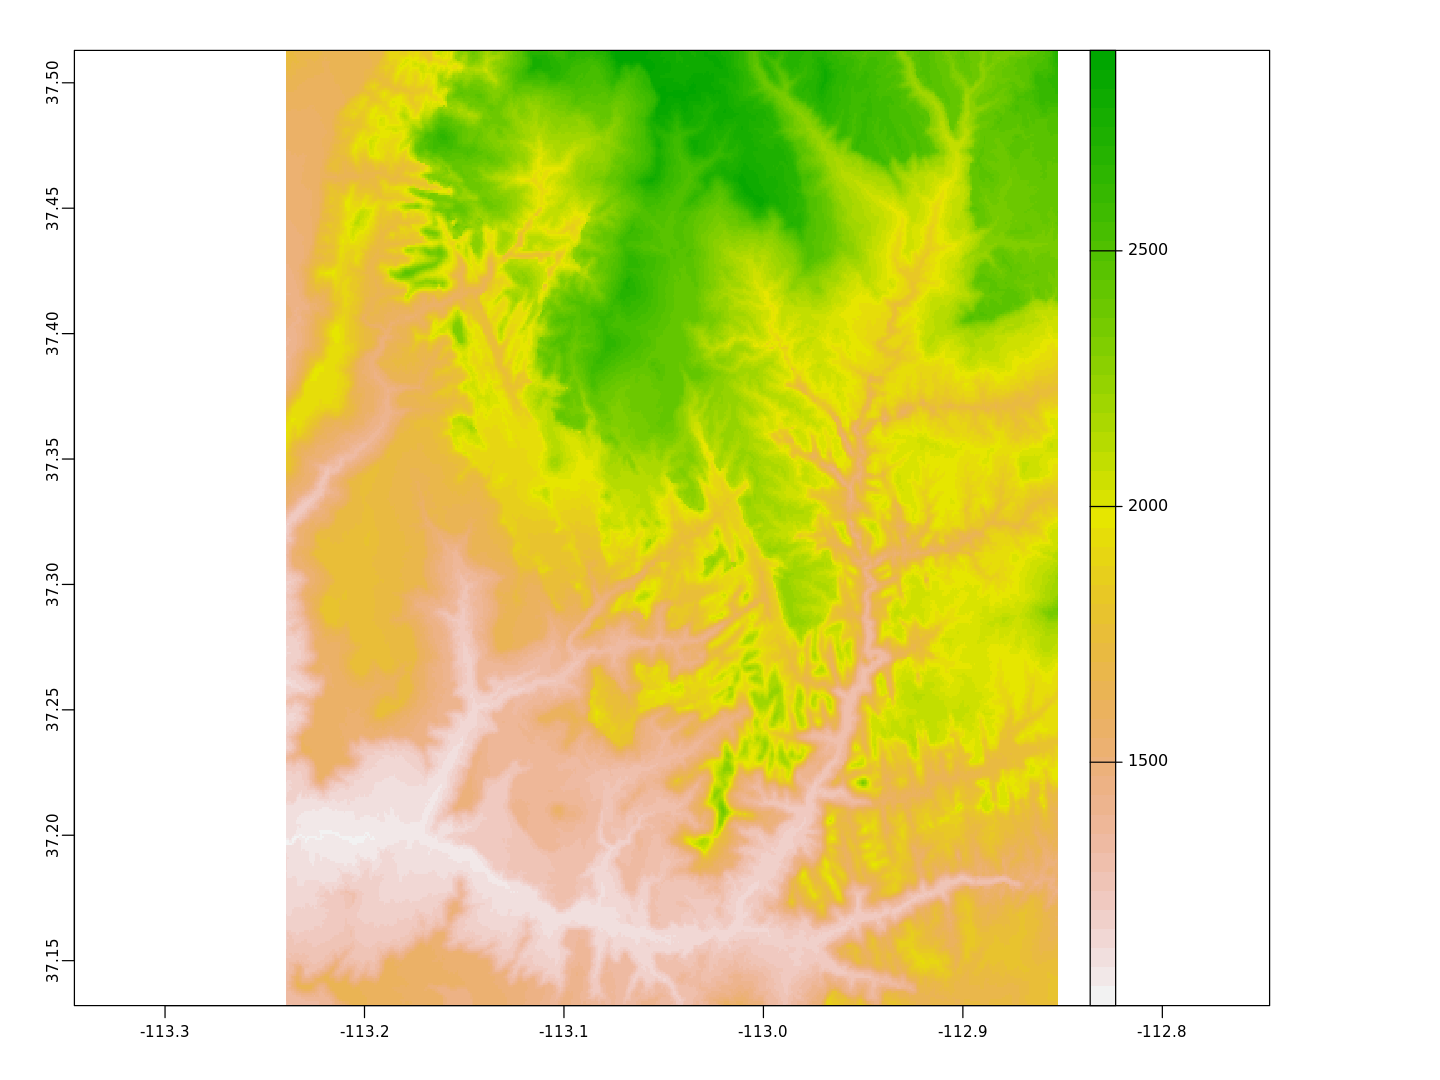

In [32]:
single_layer %>%
    plot()

In [33]:
multilayer_filepath = system.file("raster/landsat.tif", package = "spDataLarge")
multilayer_rast = rast(multilayer_filepath)

multilayer_rast

class       : SpatRaster 
dimensions  : 1428, 1128, 4  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 301905, 335745, 4111245, 4154085  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=12 +datum=WGS84 +units=m +no_defs  
source      : landsat.tif 
names       : lan_1, lan_2, lan_3, lan_4 
min values  :  7550,  6404,  5678,  5252 
max values  : 19071, 22051, 25780, 31961 

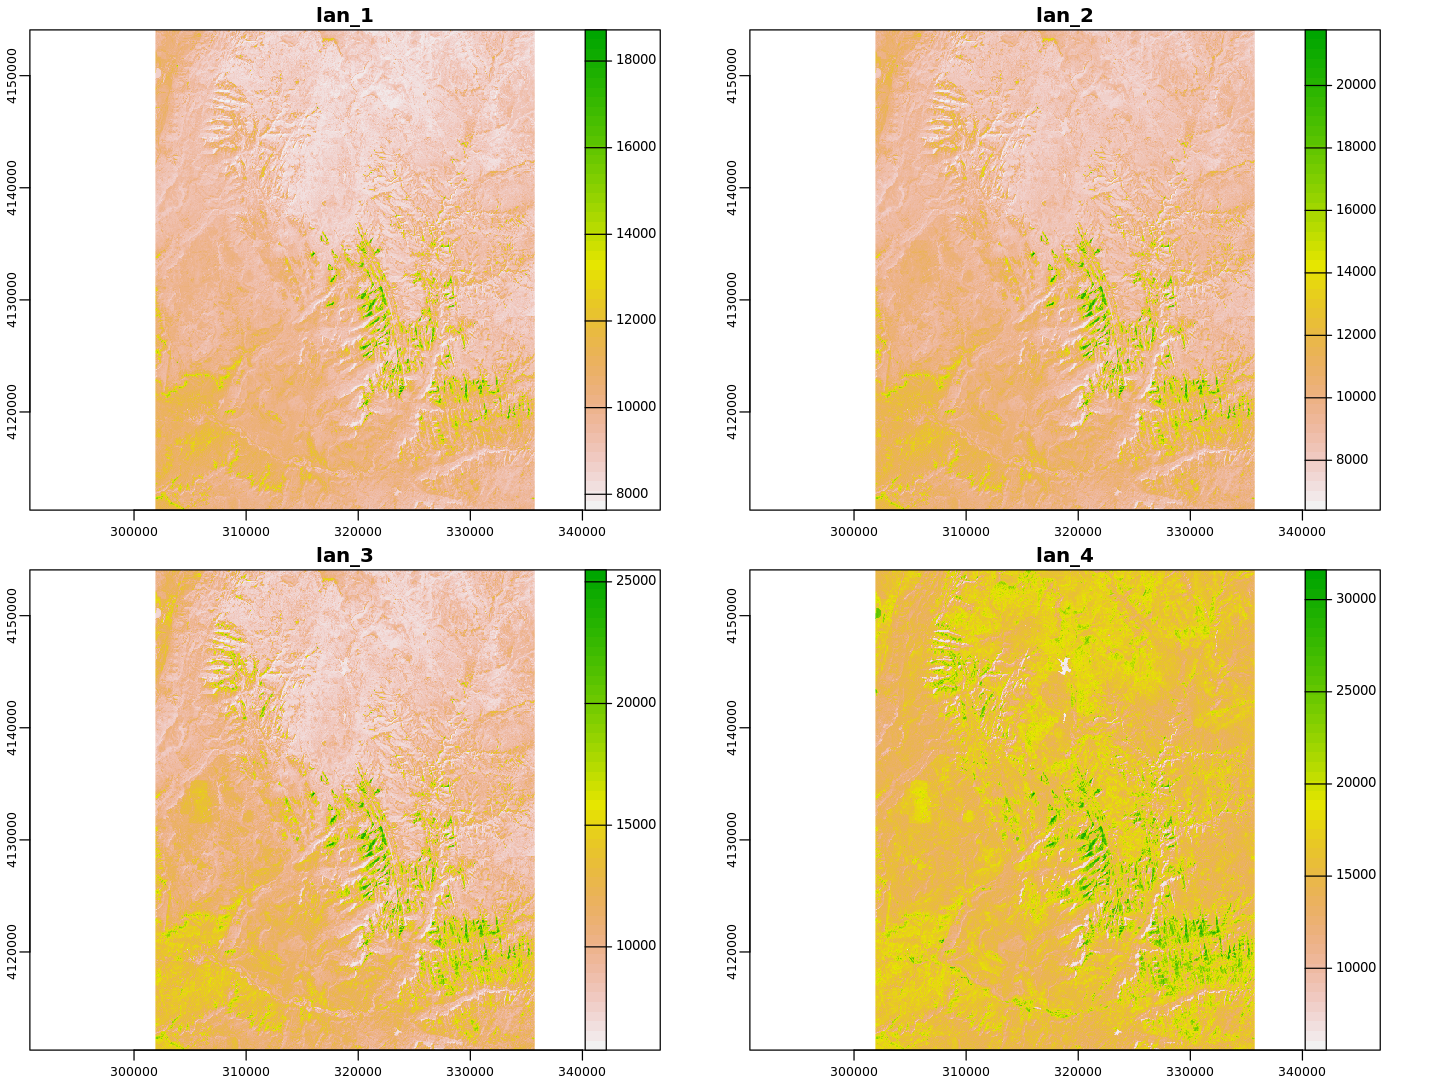

In [34]:
multilayer_rast %>%
    plot()

Raster data can be saved to disk with `writeRaster`; the filename extension - if recognized - determines the output format. 

# Map maping in R

In [35]:
library(sf)
library(raster)
library(dplyr)
library(spData)
library(spDataLarge)

In [36]:
library(tmap)    # for static and interactive maps
library(leaflet) # for interactive maps
library(gifski)  # for rendering gif files

## Static maps

There are many R packages for producing static maps. We will have a look at the package `tmap`, which works well both with vector and raster data and affords a large number of visualization techniques. It works similiar to `ggplot`, i.e., plots are built up incrementally.

`nz_elev` is a raster object.

In [94]:
nz_elev

class      : RasterLayer 
dimensions : 1450, 1115, 1616750  (nrow, ncol, ncell)
resolution : 1000, 1000  (x, y)
extent     : 995456.5, 2110457, 4741961, 6191961  (xmin, xmax, ymin, ymax)
crs        : +proj=tmerc +lat_0=0 +lon_0=173 +k=0.9996 +x_0=1600000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 
source     : memory
names      : elevation 
values     : 0, 4140.333  (min, max)


The bare `plot` command is a quick and dirty way to see what an object looks like.

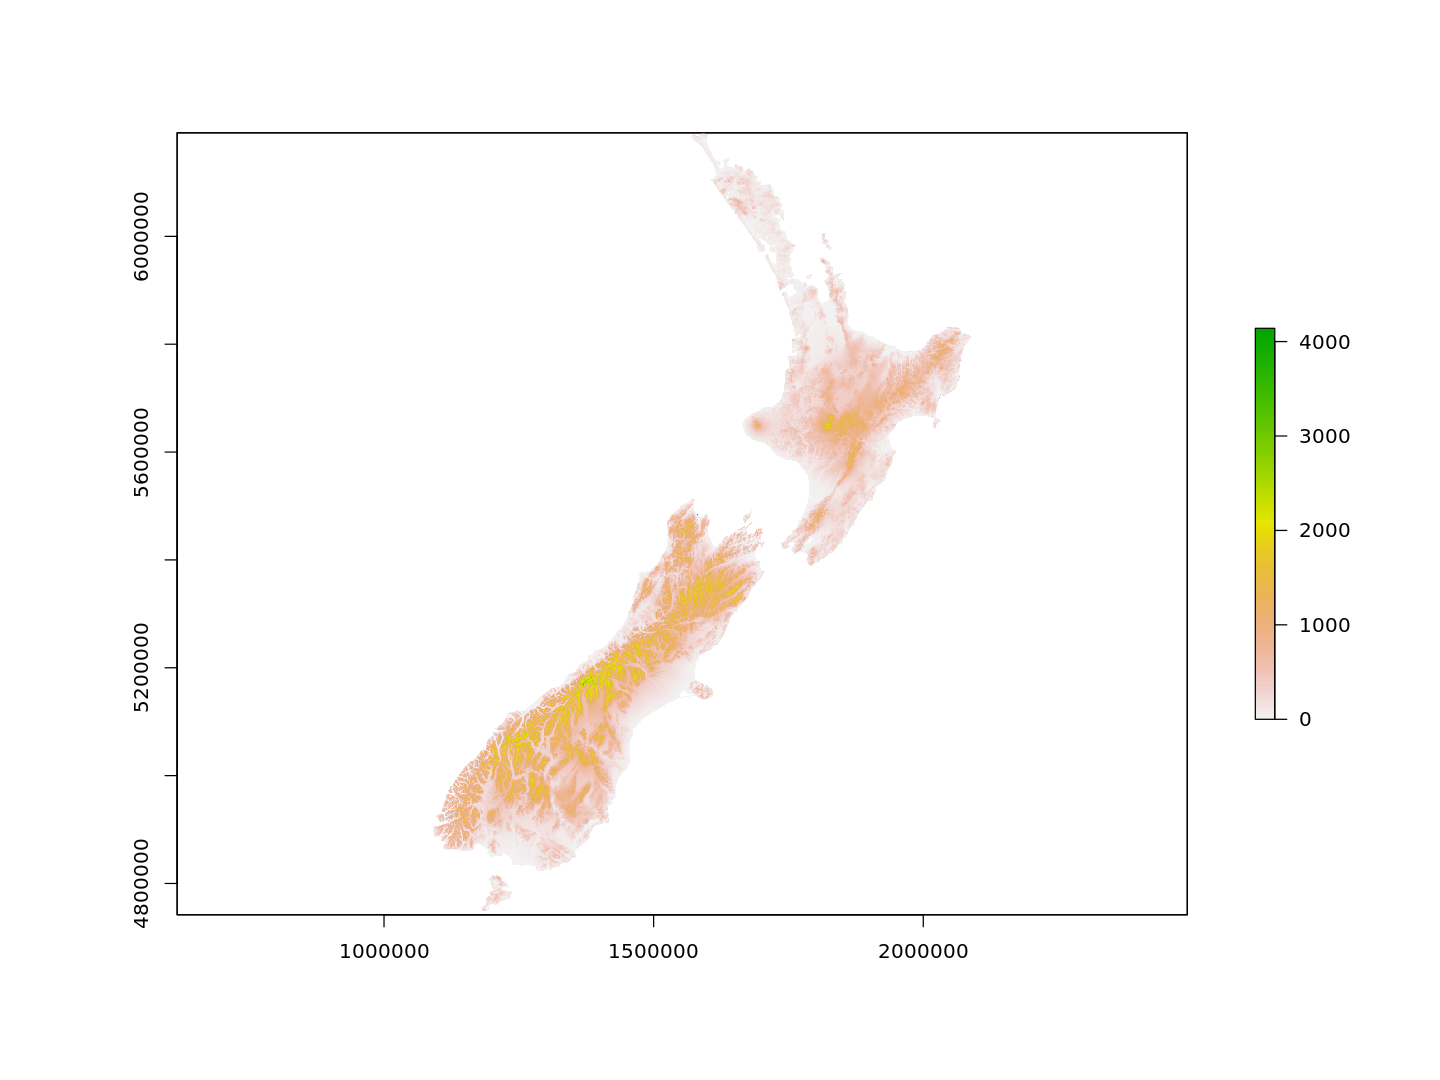

In [39]:
plot(nz_elev)

`nz` is a vector object.

In [41]:
nz

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



Name              Island Land_area  Population Median_income Sex_ratio
1  Northland         North  12500.5611  175500    23400         0.9424532
2  Auckland          North   4941.5726 1657200    29600         0.9442858
3  Waikato           North  23900.0364  460100    27900         0.9520500
4  Bay of Plenty     North  12071.1447  299900    26200         0.9280391
5  Gisborne          North   8385.8266   48500    24400         0.9349734
6  Hawke's Bay       North  14137.5244  164000    26100         0.9238375
7  Taranaki          North   7254.4804  118000    29100         0.9569363
8  Manawatu-Wanganui North  22220.6084  234500    25000         0.9387734
9  Wellington        North   8048.5528  513900    32700         0.9335524
10 West Coast        South  23245.4559   32400    26900         1.0139072
11 Canterbury        South  44504.4991  612000    30100         0.9753265
12 Otago             South  31186.3092  224200    26300         0.9511694
13 Southland         South  31196.0604   98300    29500         0.9785069
14 Tasman            South   9615.9760   51100    25700         0.9718981
15 Nelson            South    422.1952   51400    27200         0.9259674
16 Marlborough       South  10457.7455   46200    27900         0.9577922
   geom                          
1  MULTIPOLYGON (((1745493 600...
2  MULTIPOLYGON (((1803822 590...
3  MULTIPOLYGON (((1860345 585...
4  MULTIPOLYGON (((2049387 583...
5  MULTIPOLYGON (((2024489 567...
6  MULTIPOLYGON (((2024489 567...
7  MULTIPOLYGON (((1740438 571...
8  MULTIPOLYGON (((1866732 566...
9  MULTIPOLYGON (((1881590 548...
10 MULTIPOLYGON (((1557042 531...
11 MULTIPOLYGON (((1686902 535...
12 MULTIPOLYGON (((1335205 512...
13 MULTIPOLYGON (((1229078 506...
14 MULTIPOLYGON (((1616643 542...
15 MULTIPOLYGON (((1624866 541...
16 MULTIPOLYGON (((1686902 535...

`tm_shape` activates a geospatial object. The actual visualization is added via `+`.

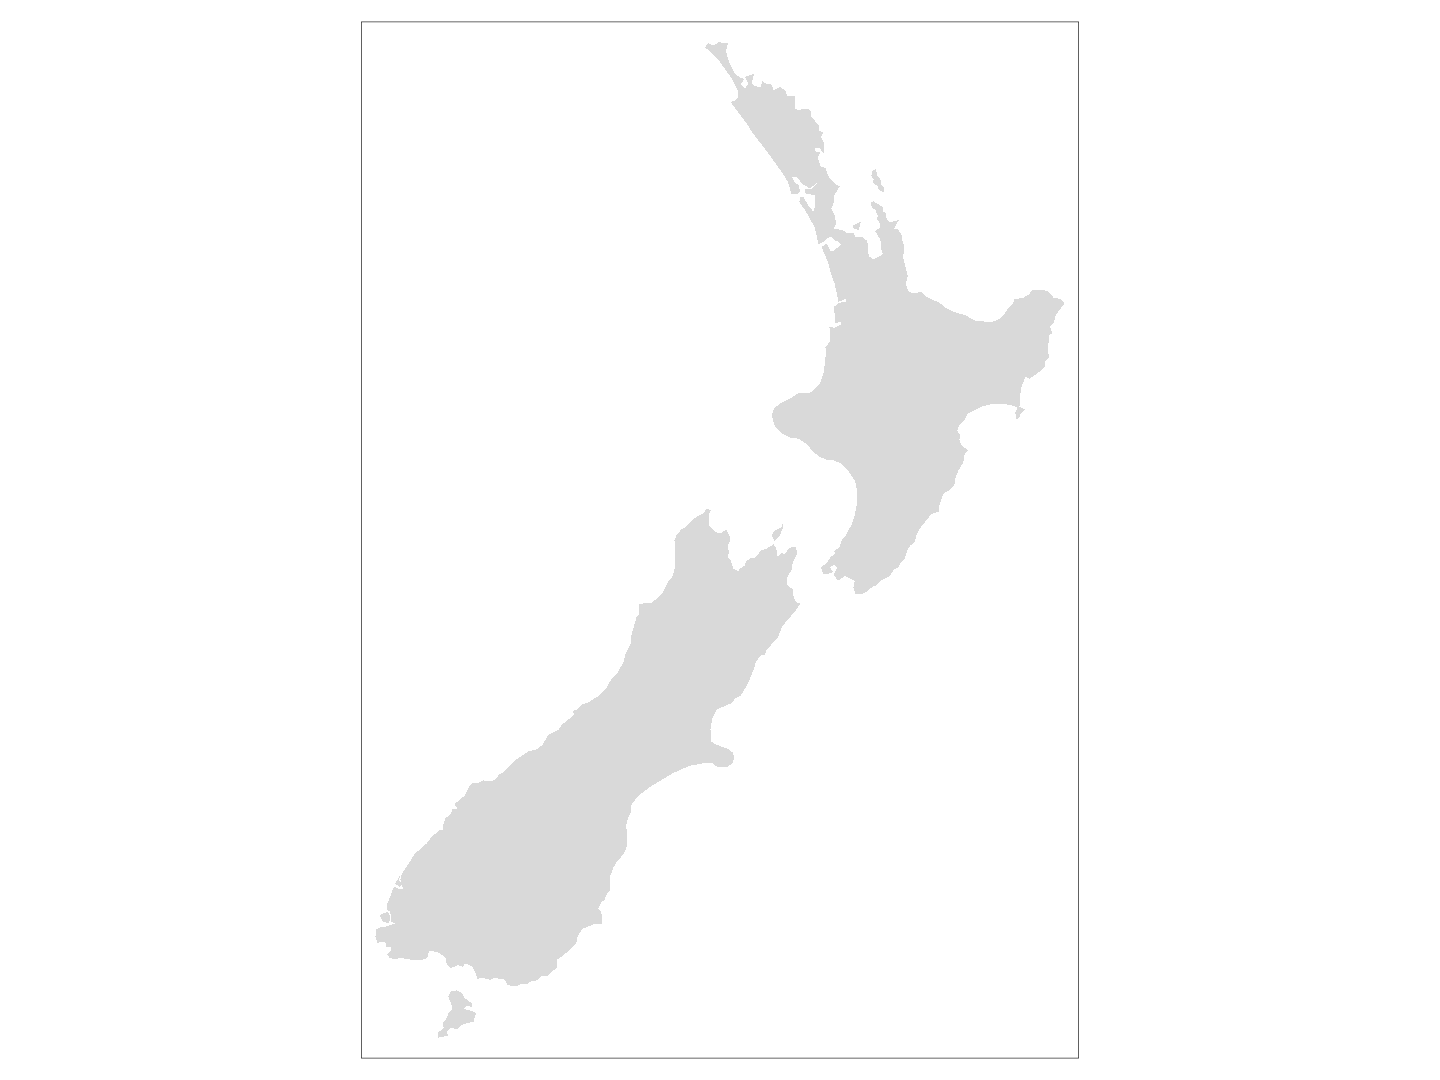

In [42]:
# Add fill layer to nz shape
tm_shape(nz) +
  tm_fill() 


Add border layer to nz shape

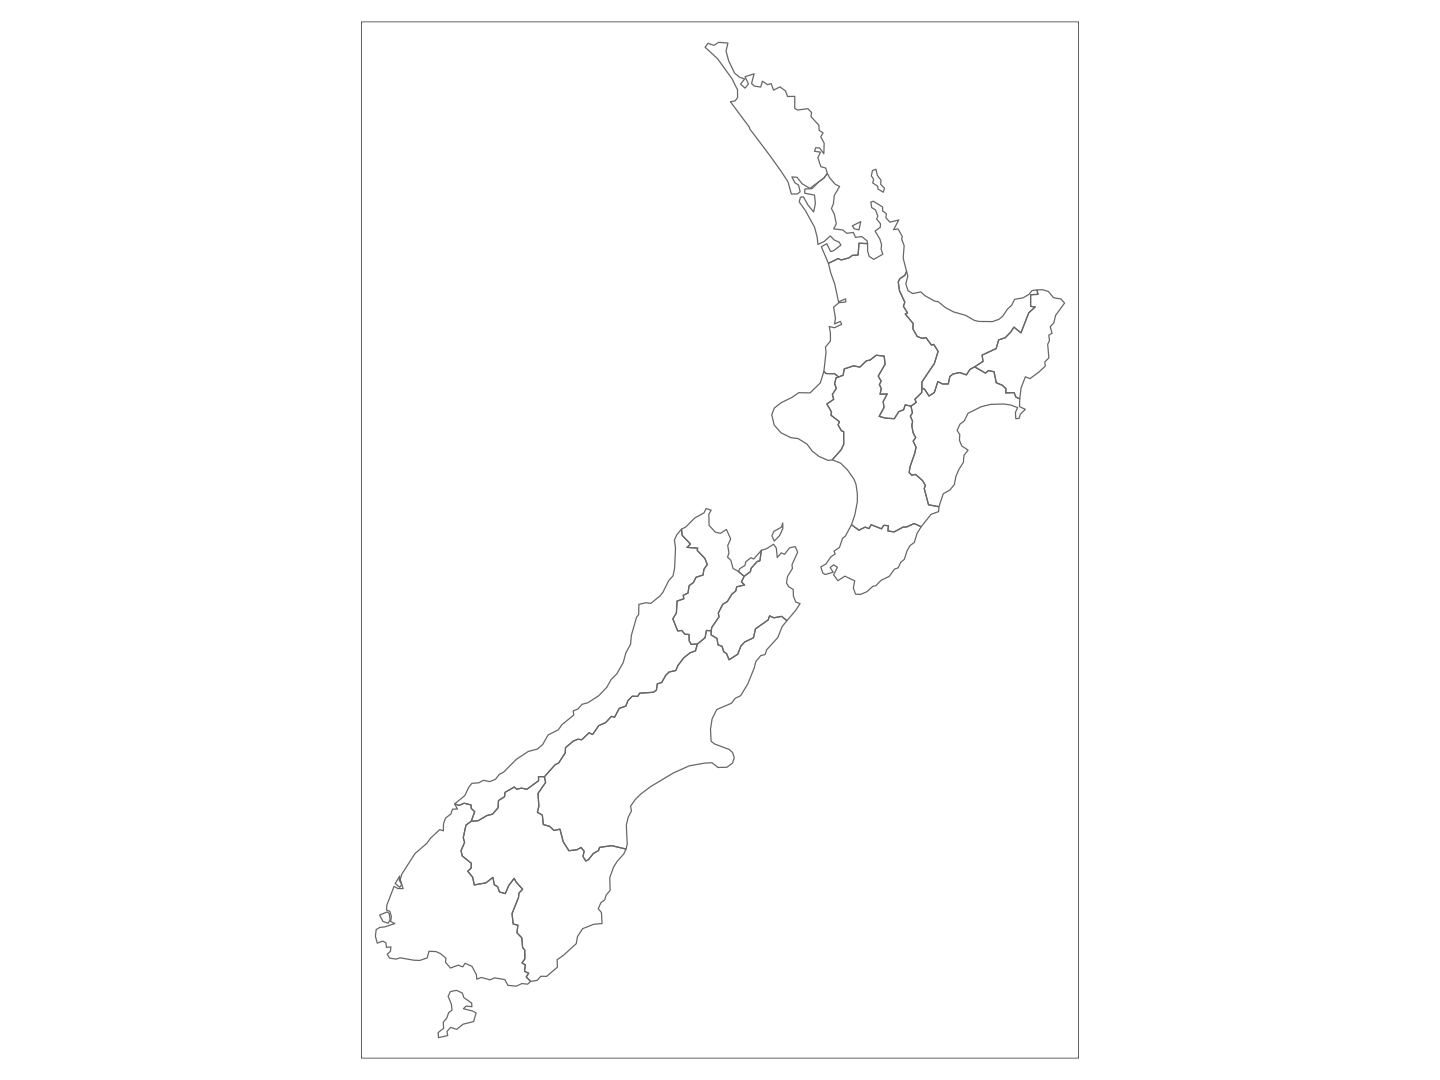

In [43]:

tm_shape(nz) +
  tm_borders() 


Add fill and border layers to nz shape

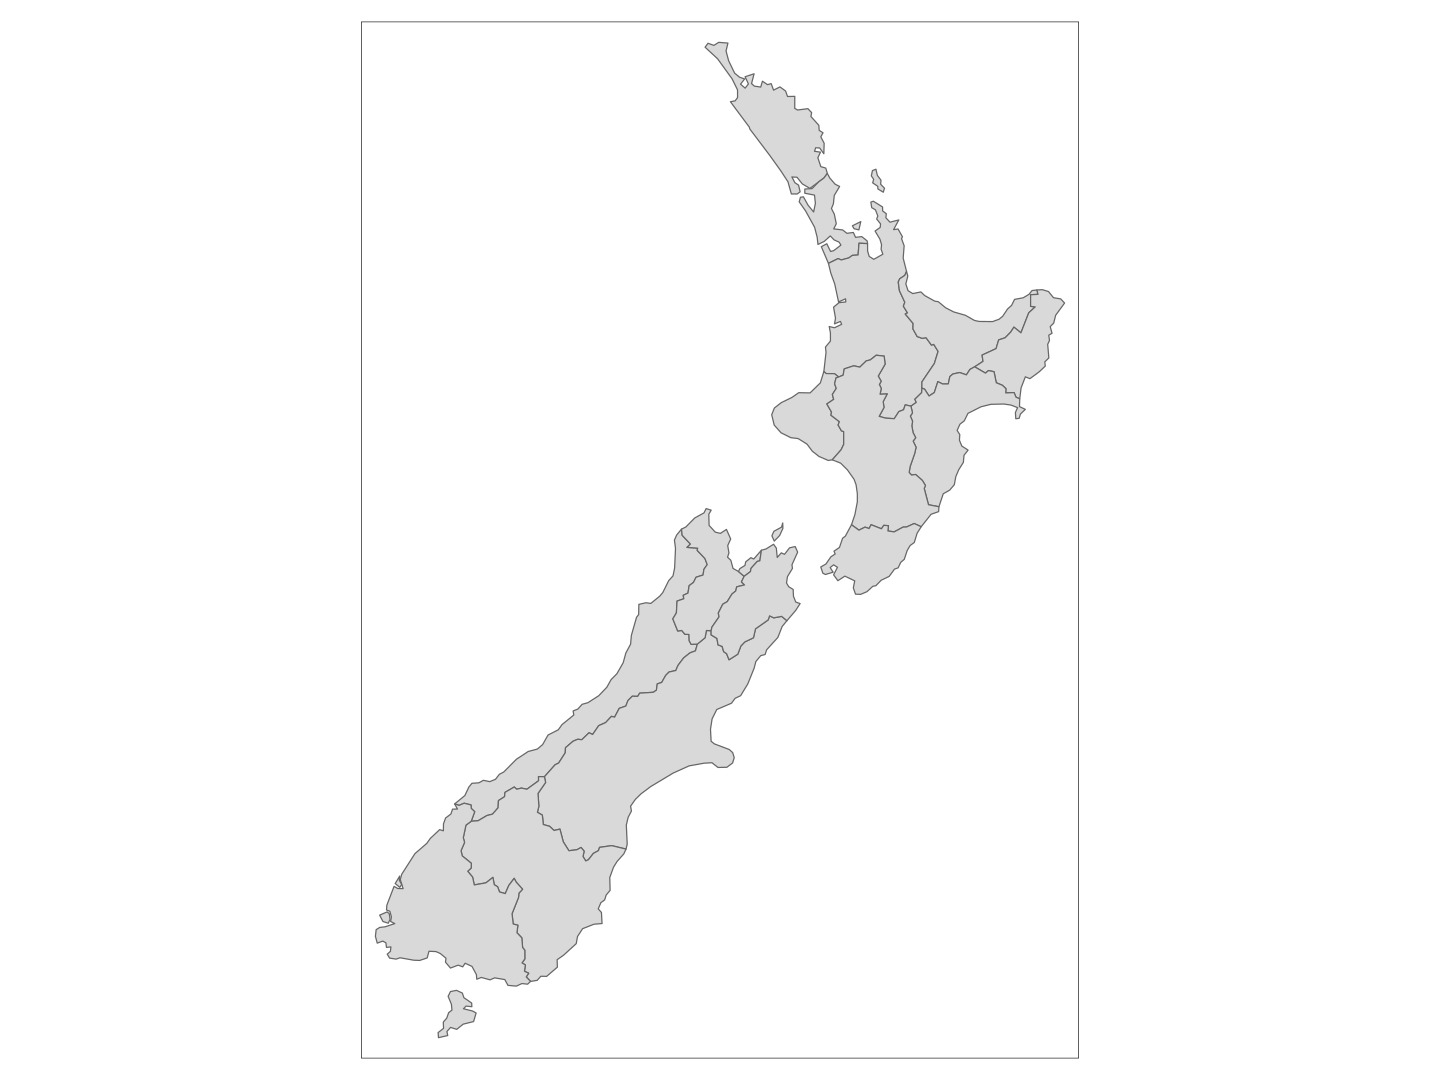

In [44]:

tm_shape(nz) +
  tm_fill() +
  tm_borders() 

In [45]:
map_nz = tm_shape(nz) + tm_polygons()
class(map_nz)
#> [1] "tmap"

[1] "tmap"

In [47]:
nz_elev

class      : RasterLayer 
dimensions : 1450, 1115, 1616750  (nrow, ncol, ncell)
resolution : 1000, 1000  (x, y)
extent     : 995456.5, 2110457, 4741961, 6191961  (xmin, xmax, ymin, ymax)
crs        : +proj=tmerc +lat_0=0 +lon_0=173 +k=0.9996 +x_0=1600000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 
source     : memory
names      : elevation 
values     : 0, 4140.333  (min, max)


Raster objects are rendered via `tm_raster`. 

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



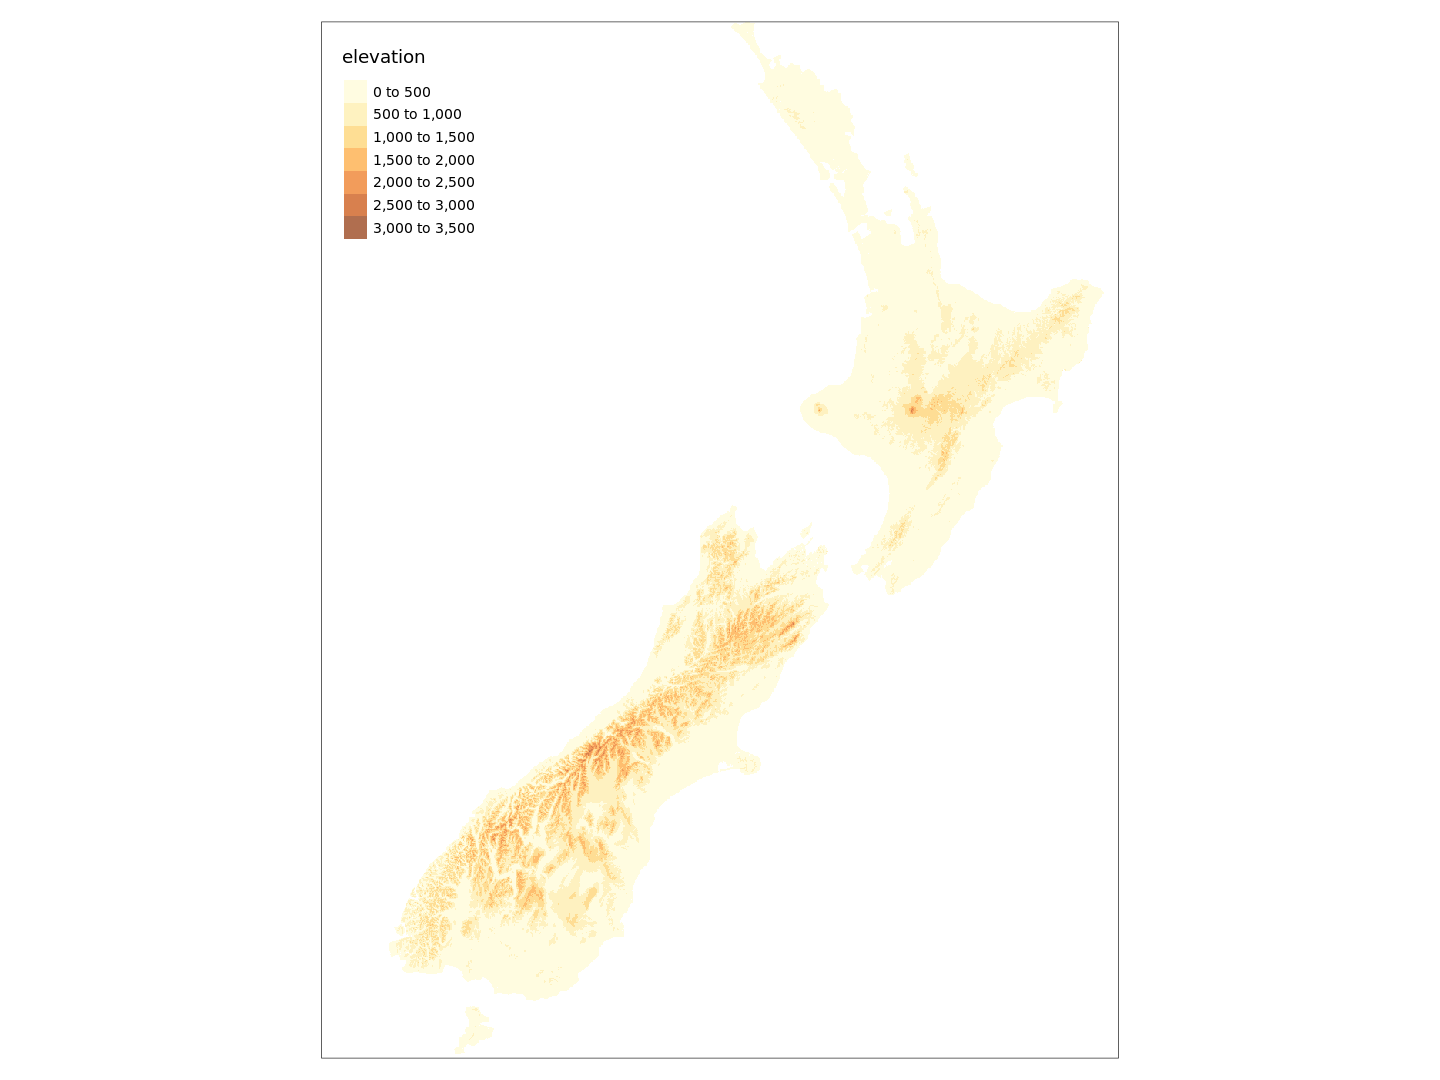

In [96]:
tm_shape(nz_elev) + tm_raster(alpha = 0.7)

Different `tmap`-graphics can simply be combined via `+`.

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



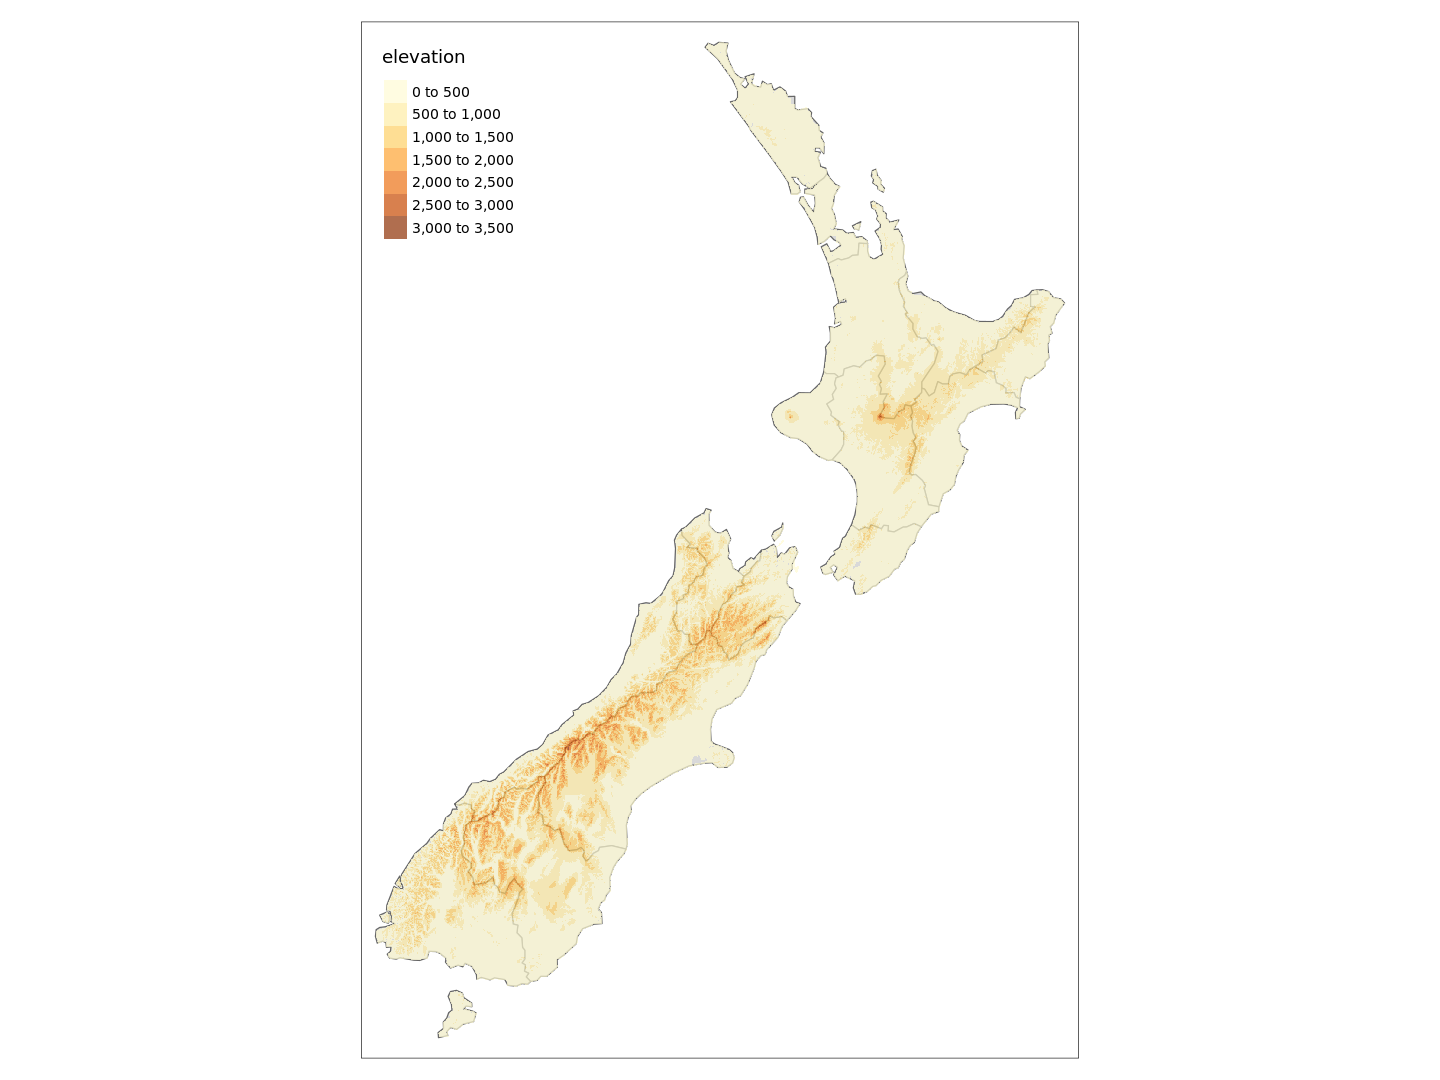

In [97]:
map_nz1 = map_nz +
  tm_shape(nz_elev) + tm_raster(alpha = 0.7)
map_nz1

Adding another vector graphics layer.

In [52]:
nz_water = st_union(nz) %>% st_buffer(22200) %>% 
  st_cast(to = "LINESTRING")
nz_water

LINESTRING (1074909 4920220, 1074855 4920397, 1...



Geometry set for 1 feature 
Geometry type: LINESTRING
Dimension:     XY
Bounding box:  xmin: 1067944 ymin: 4726340 xmax: 2111732 ymax: 6214066
CRS:           EPSG:2193

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



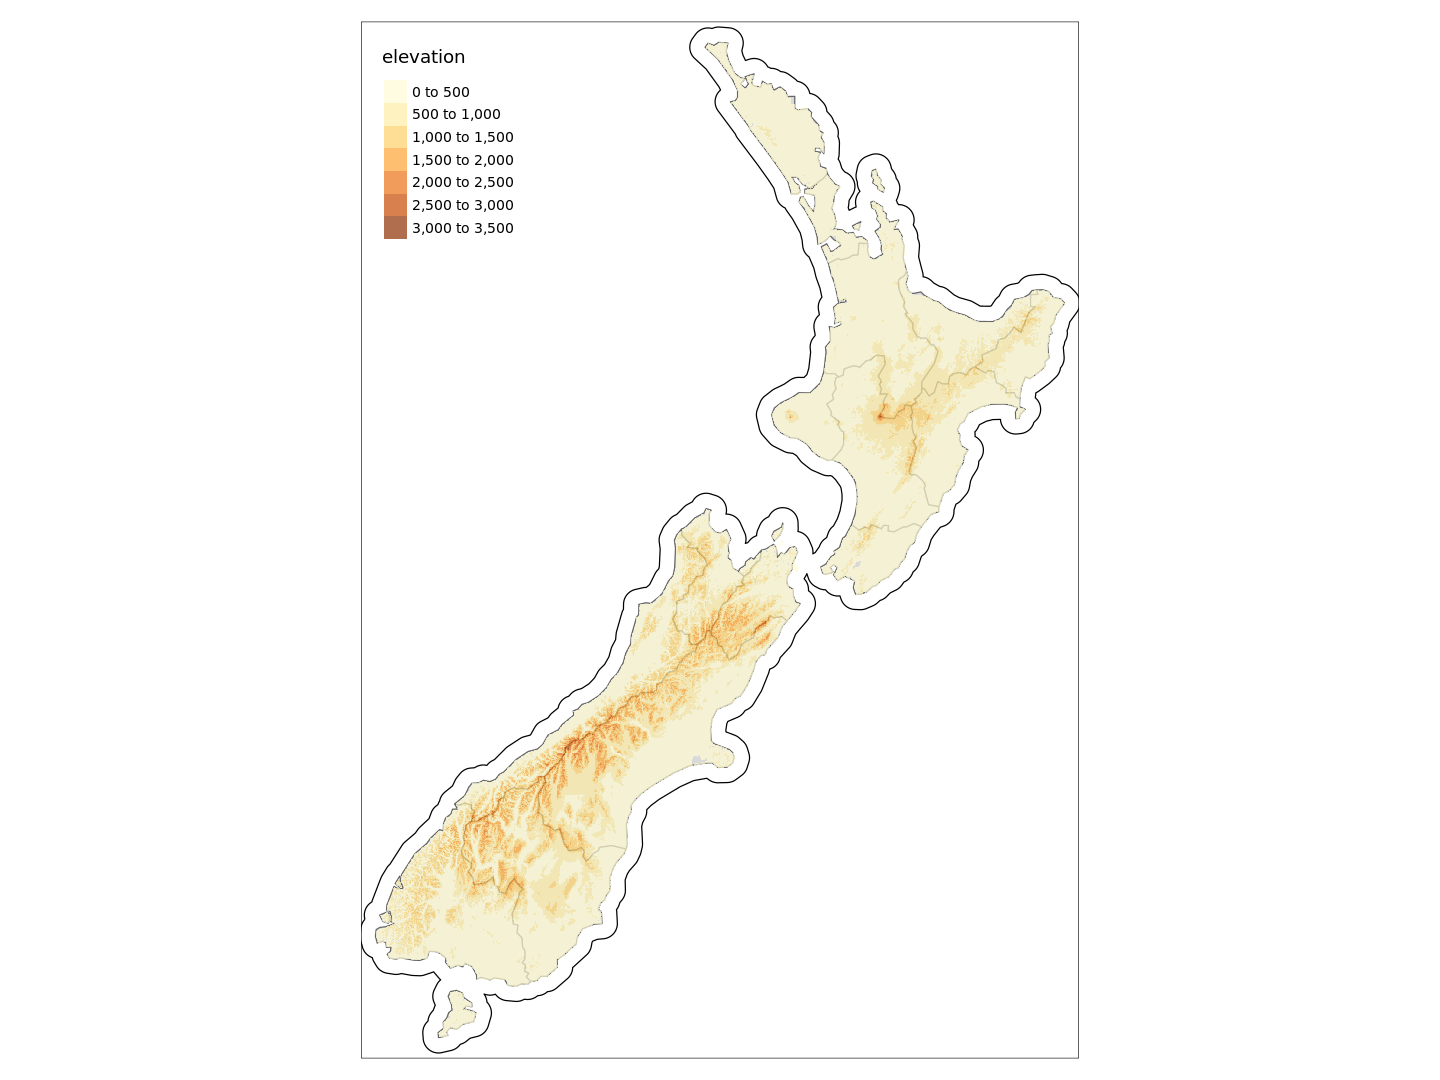

In [53]:
map_nz2 = map_nz1 +
  tm_shape(nz_water) + tm_lines()
map_nz2

And yet another layer.

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



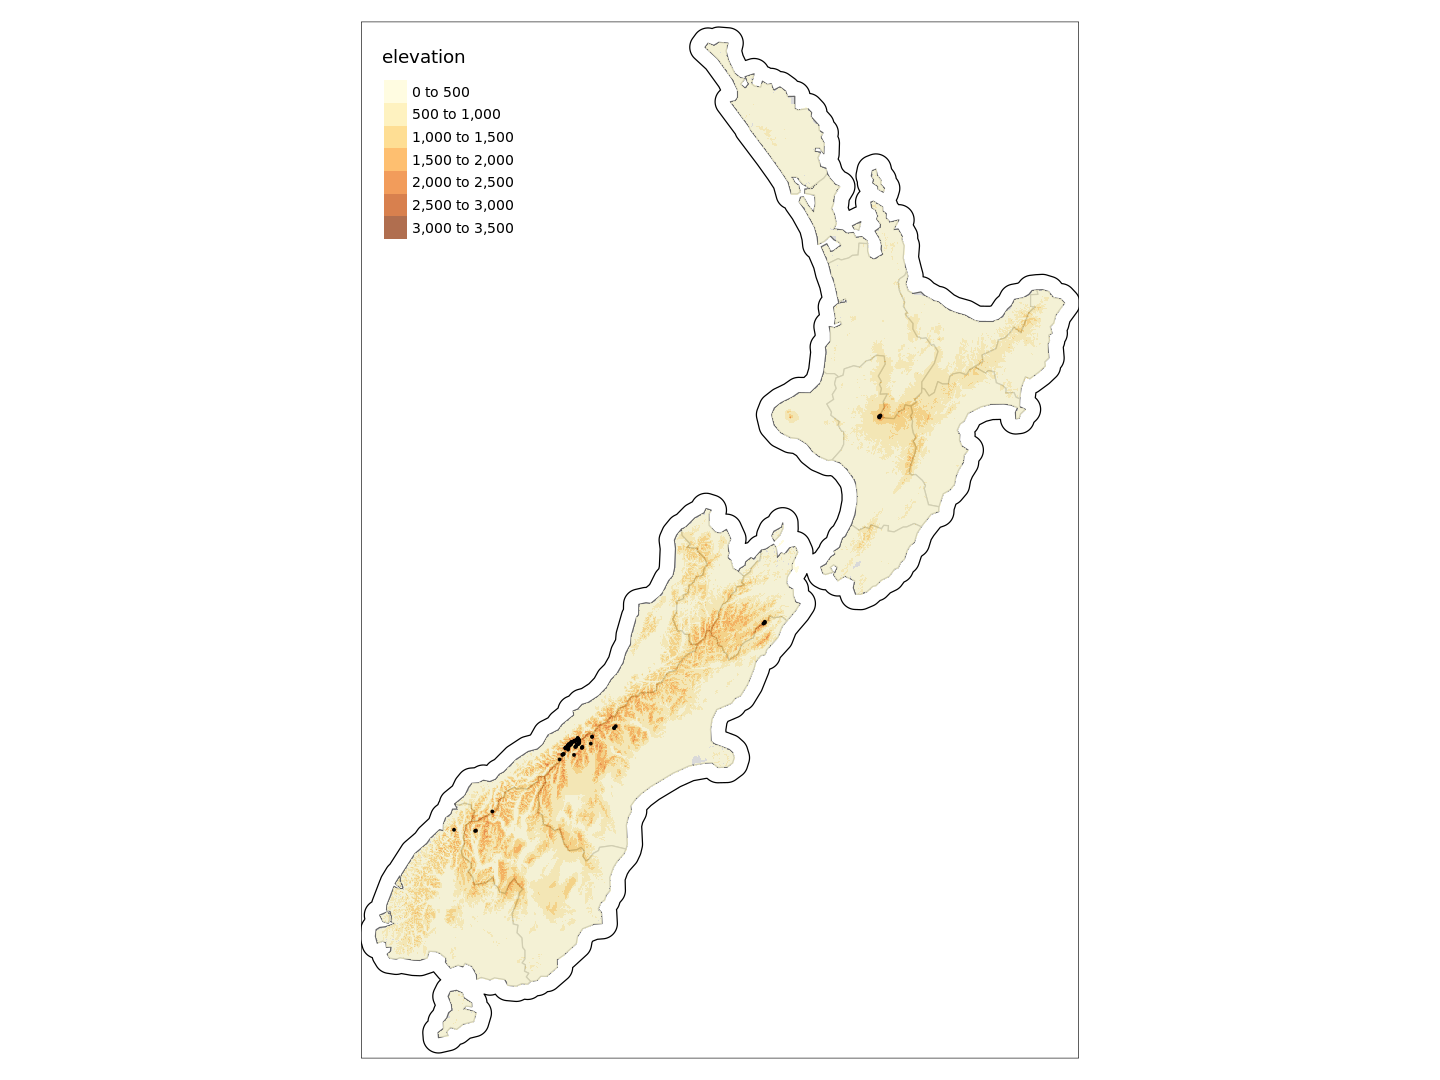

In [56]:
map_nz3 = map_nz2 +
  tm_shape(nz_height) + tm_dots()
map_nz3

Several graphics can be combined via `tmap_arrange`.

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



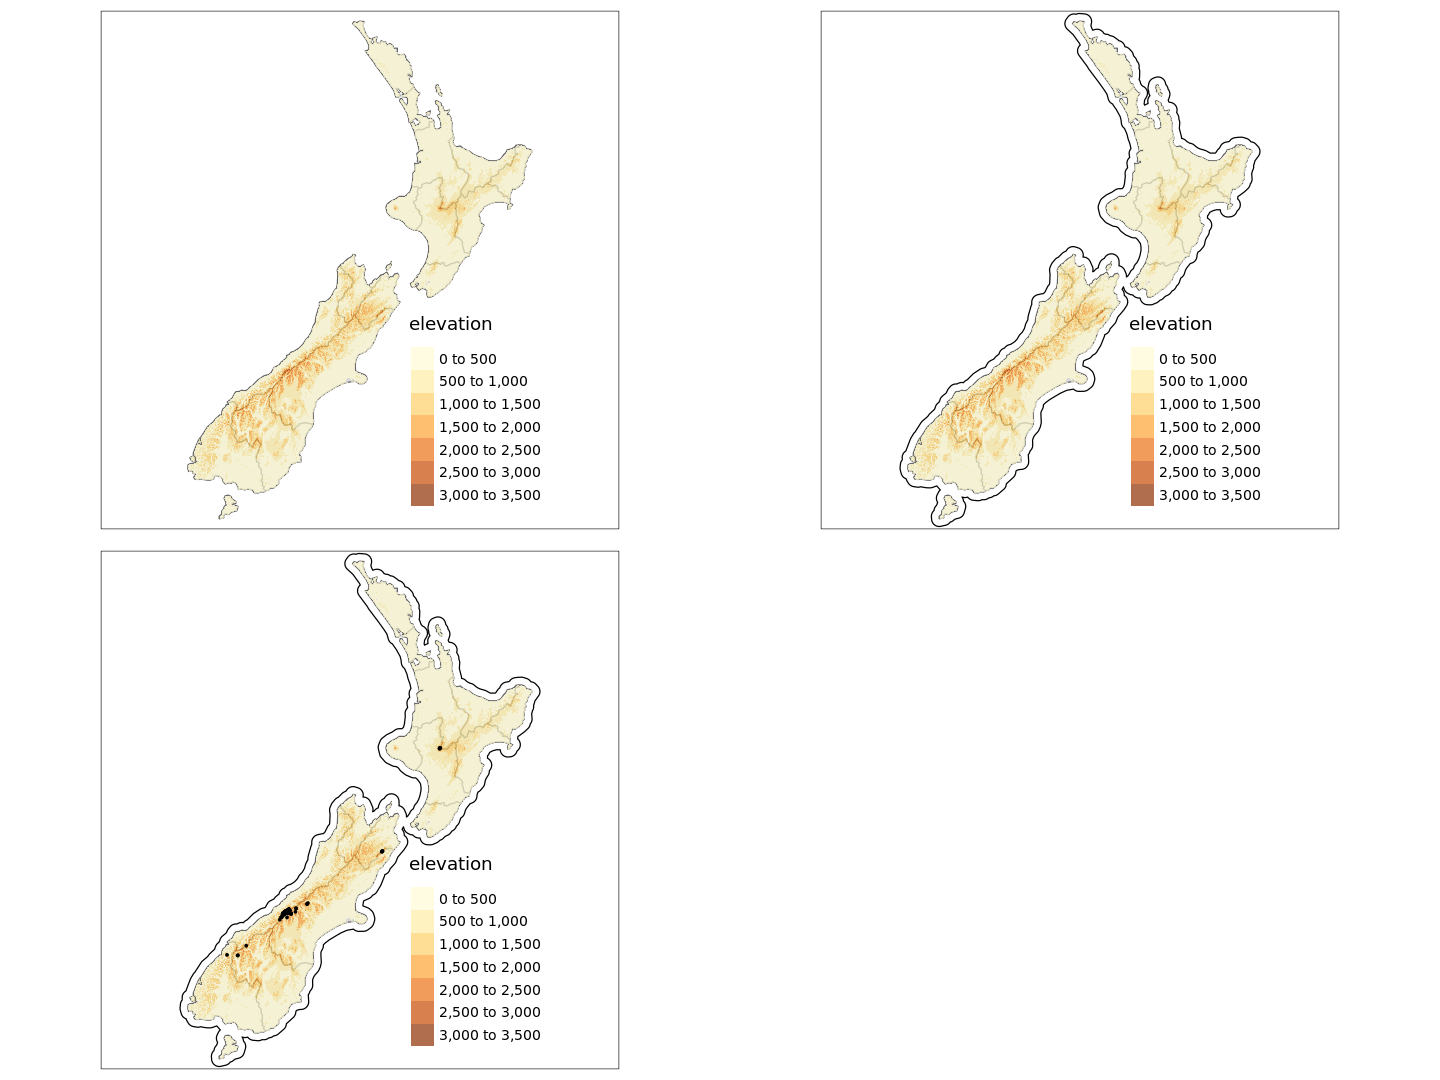

In [57]:
tmap_arrange(map_nz1, map_nz2, map_nz3)

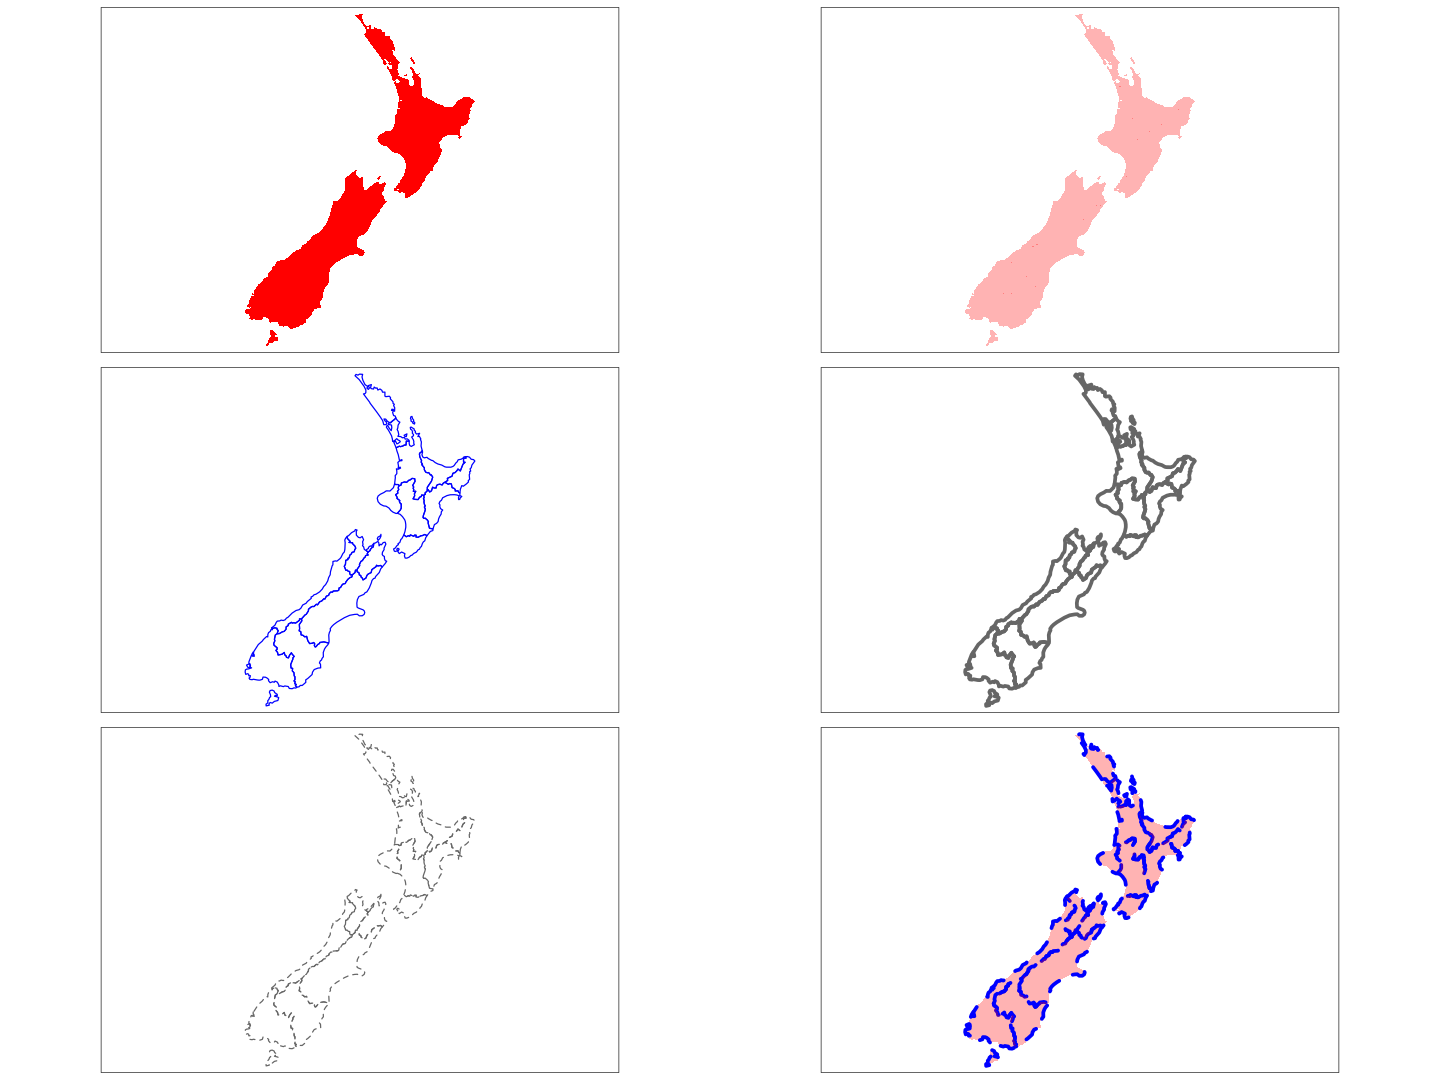

In [61]:
ma1 = tm_shape(nz) + tm_fill(col = "red")
ma2 = tm_shape(nz) + tm_fill(col = "red", alpha = 0.3)
ma3 = tm_shape(nz) + tm_borders(col = "blue")
ma4 = tm_shape(nz) + tm_borders(lwd = 3)
ma5 = tm_shape(nz) + tm_borders(lty = 2)
ma6 = tm_shape(nz) + tm_fill(col = "red", alpha = 0.3) +
  tm_borders(col = "blue", lwd = 3, lty = 2)
tmap_arrange(ma1, ma2, ma3, ma4, ma5, ma6, ncol=2)



Legends are added automatically. Their parameters can be customized.

In [62]:
nz %>% slice_head(n=10)

Name              Island Land_area Population Median_income Sex_ratio
1  Northland         North  12500.561  175500    23400         0.9424532
2  Auckland          North   4941.573 1657200    29600         0.9442858
3  Waikato           North  23900.036  460100    27900         0.9520500
4  Bay of Plenty     North  12071.145  299900    26200         0.9280391
5  Gisborne          North   8385.827   48500    24400         0.9349734
6  Hawke's Bay       North  14137.524  164000    26100         0.9238375
7  Taranaki          North   7254.480  118000    29100         0.9569363
8  Manawatu-Wanganui North  22220.608  234500    25000         0.9387734
9  Wellington        North   8048.553  513900    32700         0.9335524
10 West Coast        South  23245.456   32400    26900         1.0139072
   geom                          
1  MULTIPOLYGON (((1745493 600...
2  MULTIPOLYGON (((1803822 590...
3  MULTIPOLYGON (((1860345 585...
4  MULTIPOLYGON (((2049387 583...
5  MULTIPOLYGON (((2024489 567...
6  MULTIPOLYGON (((2024489 567...
7  MULTIPOLYGON (((1740438 571...
8  MULTIPOLYGON (((1866732 566...
9  MULTIPOLYGON (((1881590 548...
10 MULTIPOLYGON (((1557042 531...

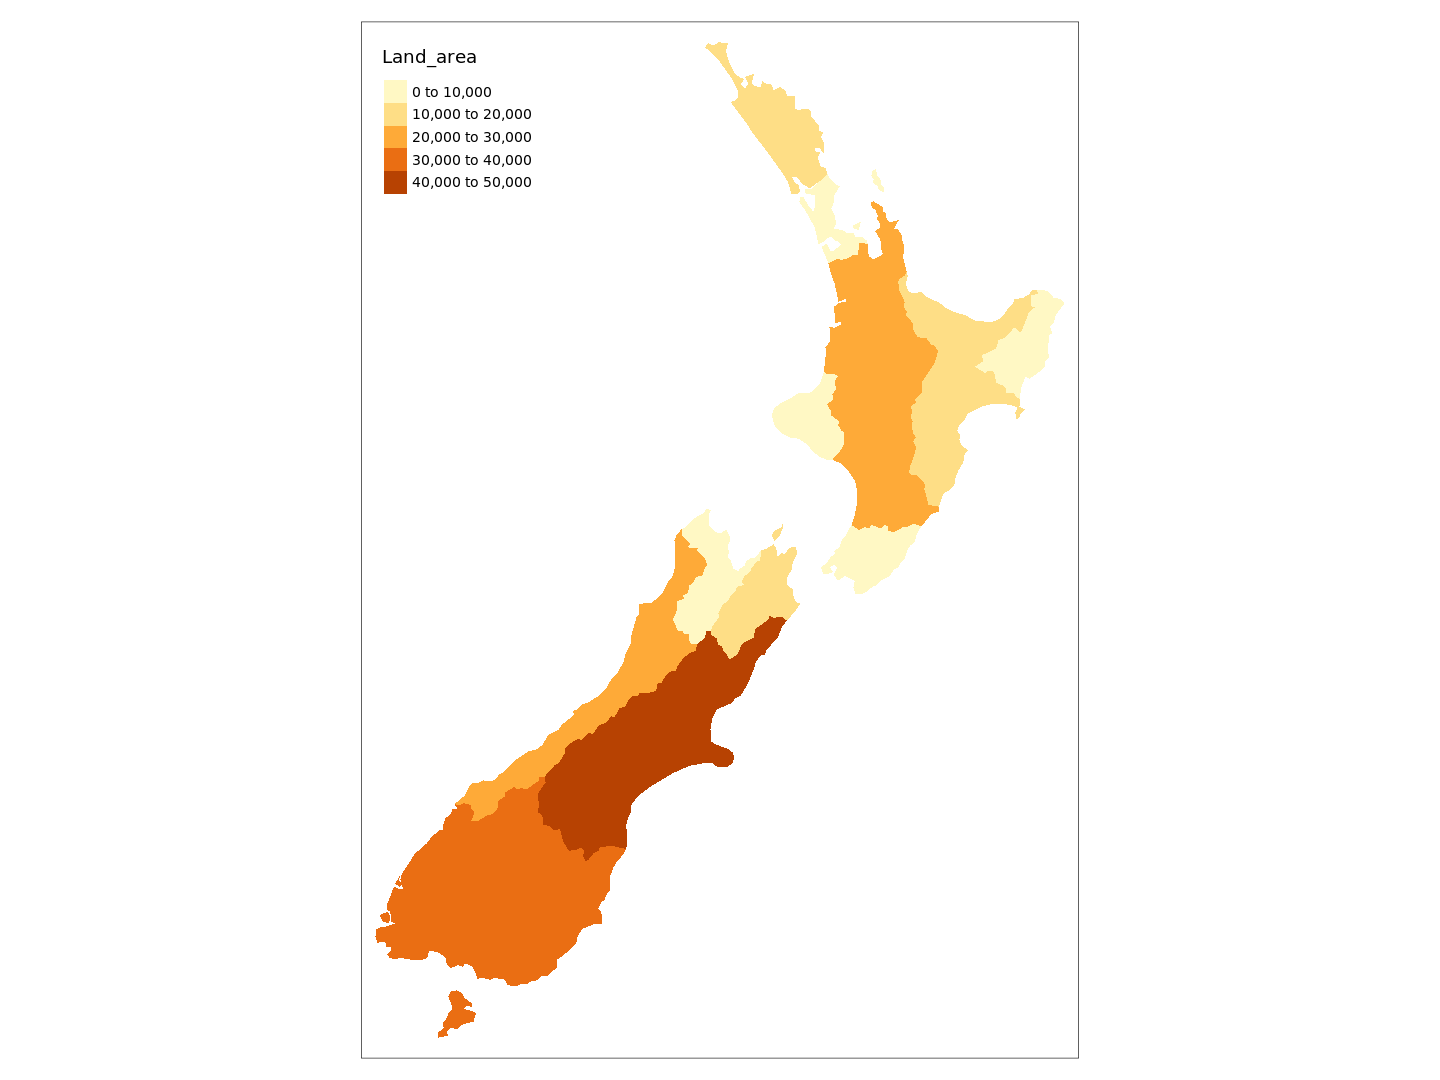

In [63]:
tm_shape(nz) + tm_fill(col = "Land_area")

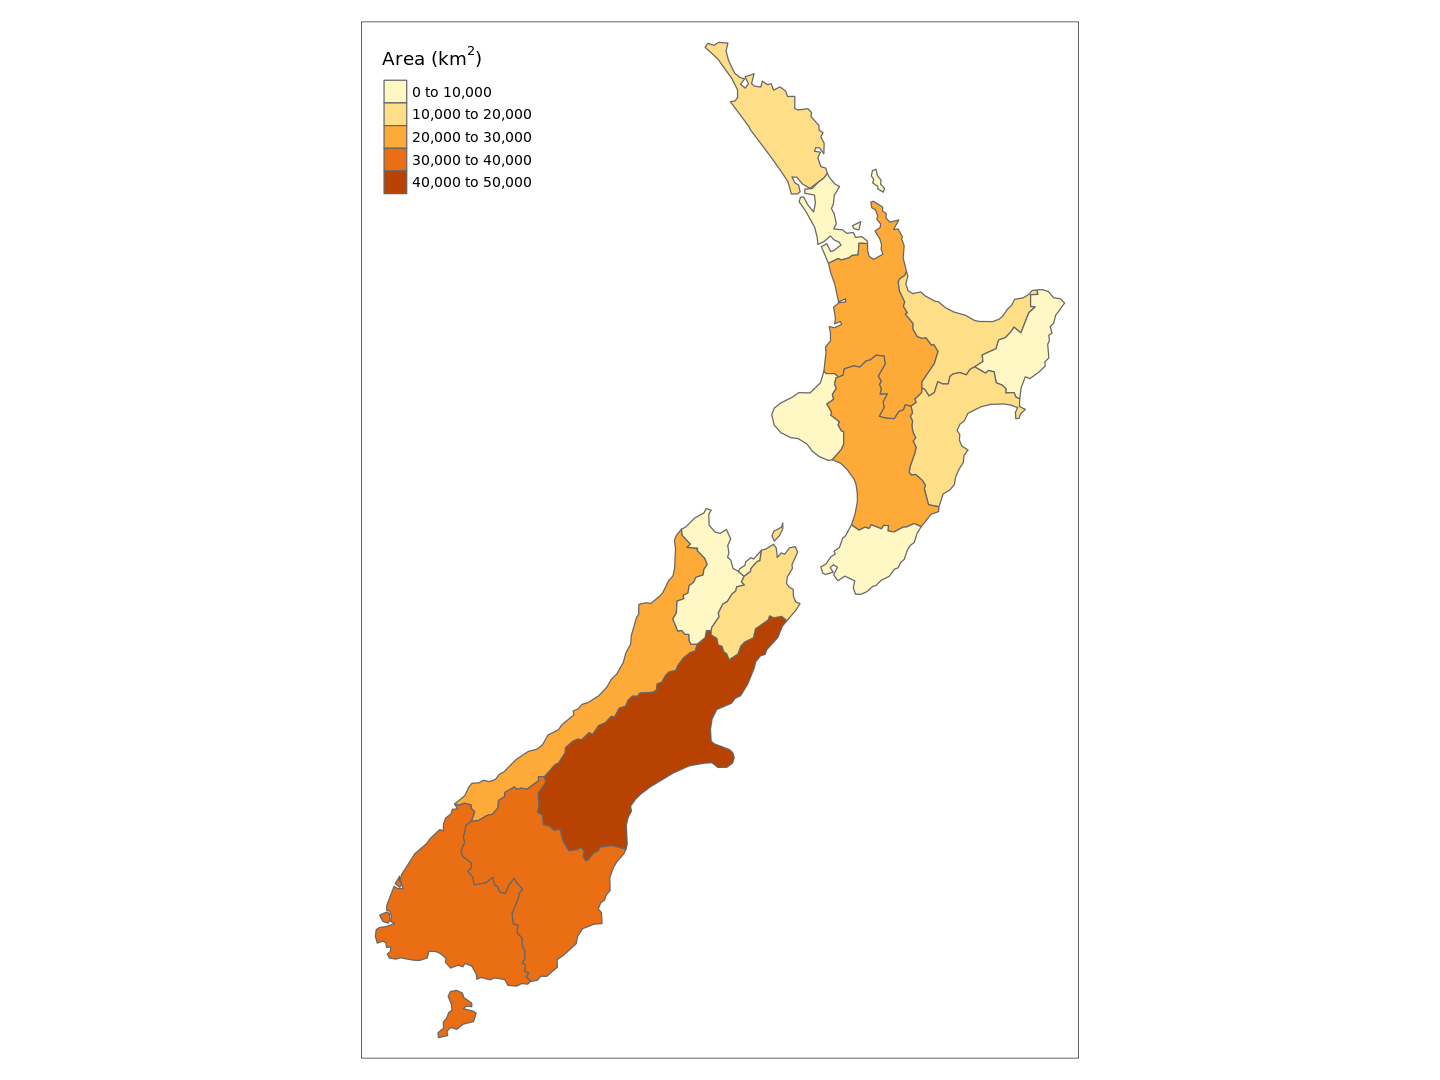

In [64]:
legend_title = expression("Area (km"^2*")")
map_nza = tm_shape(nz) +
  tm_fill(col = "Land_area", title = legend_title) + tm_borders()
map_nza

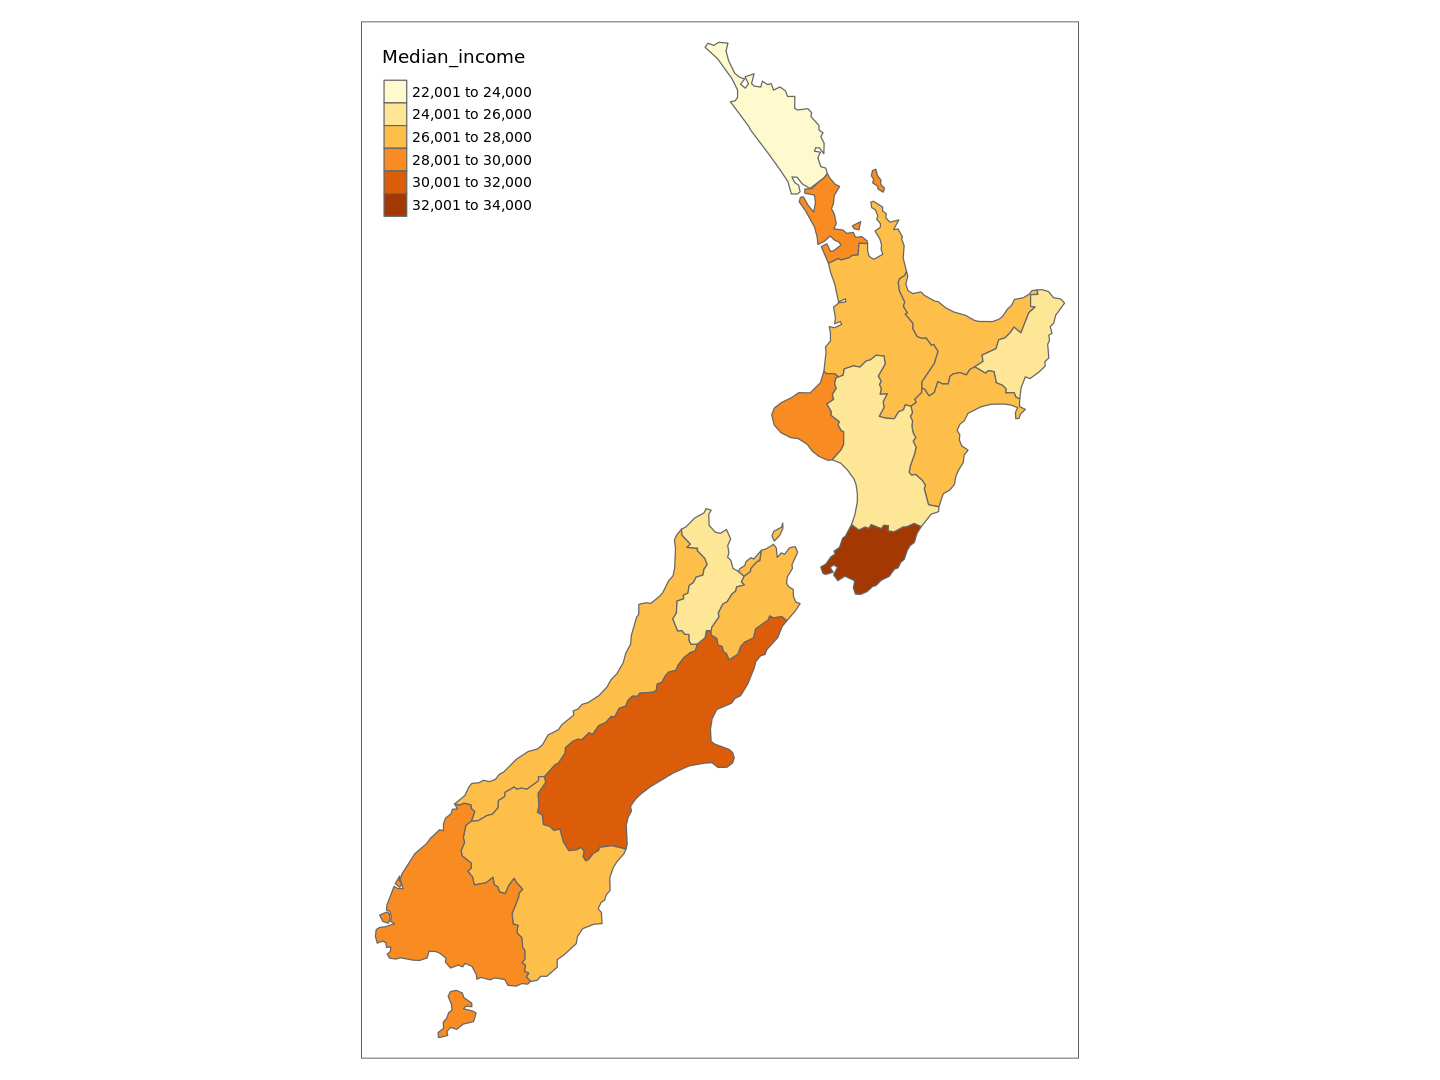

In [65]:
tm_shape(nz) + tm_polygons(col = "Median_income")
breaks = c(0, 3, 4, 5) * 10000


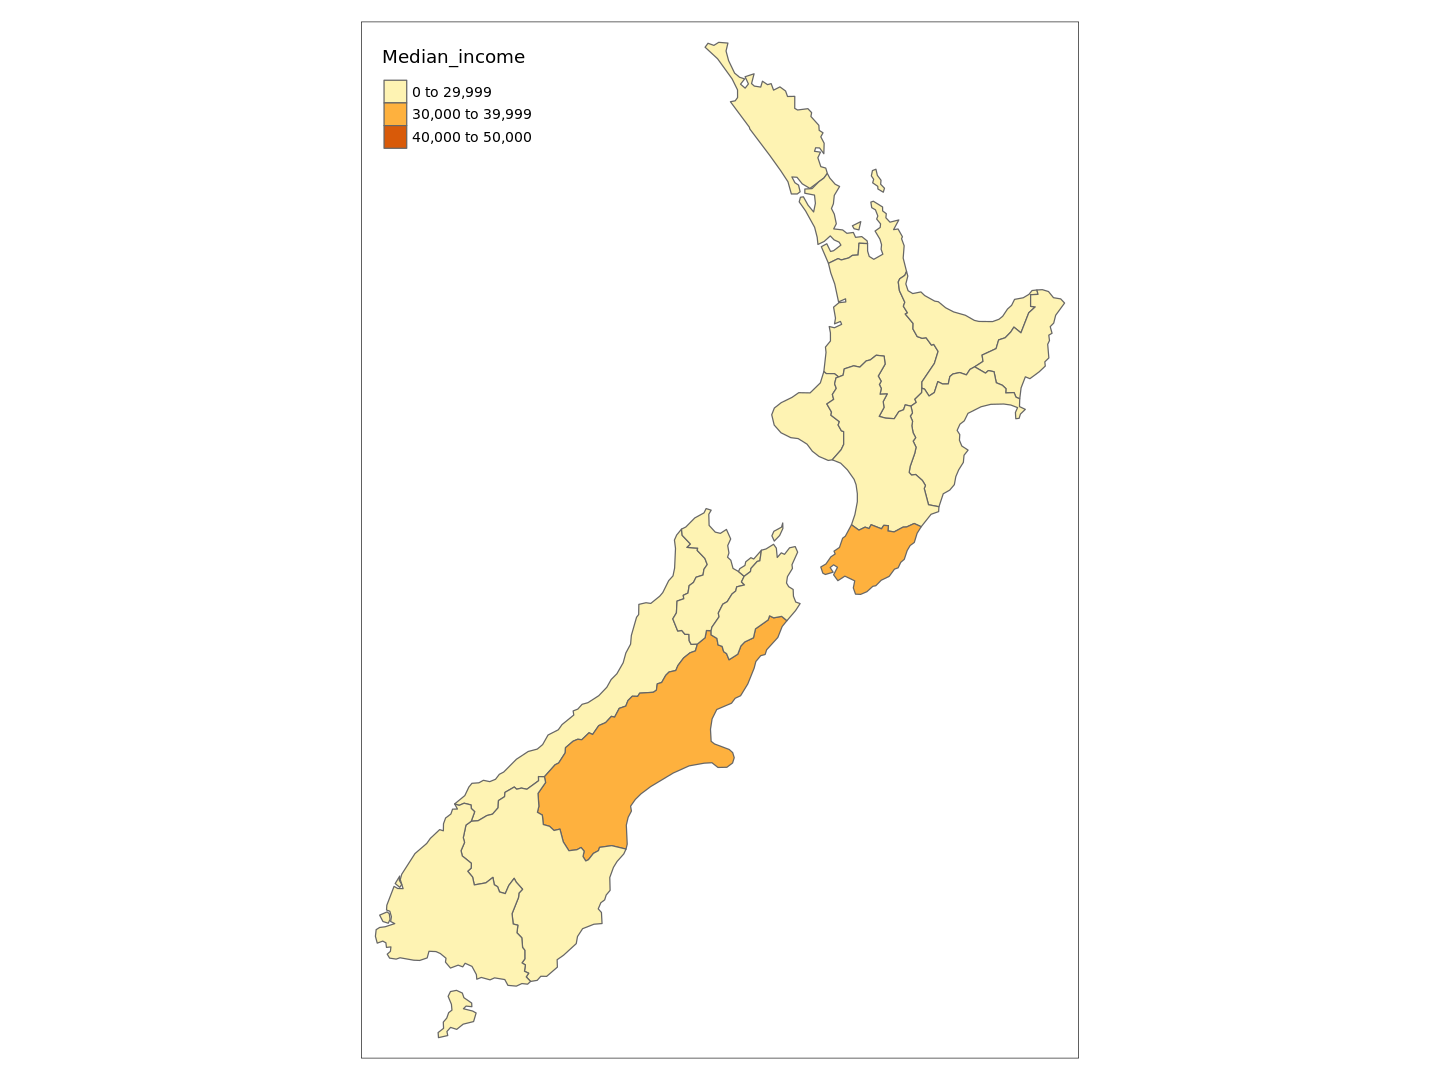

In [66]:
tm_shape(nz) + tm_polygons(col = "Median_income", breaks = breaks)


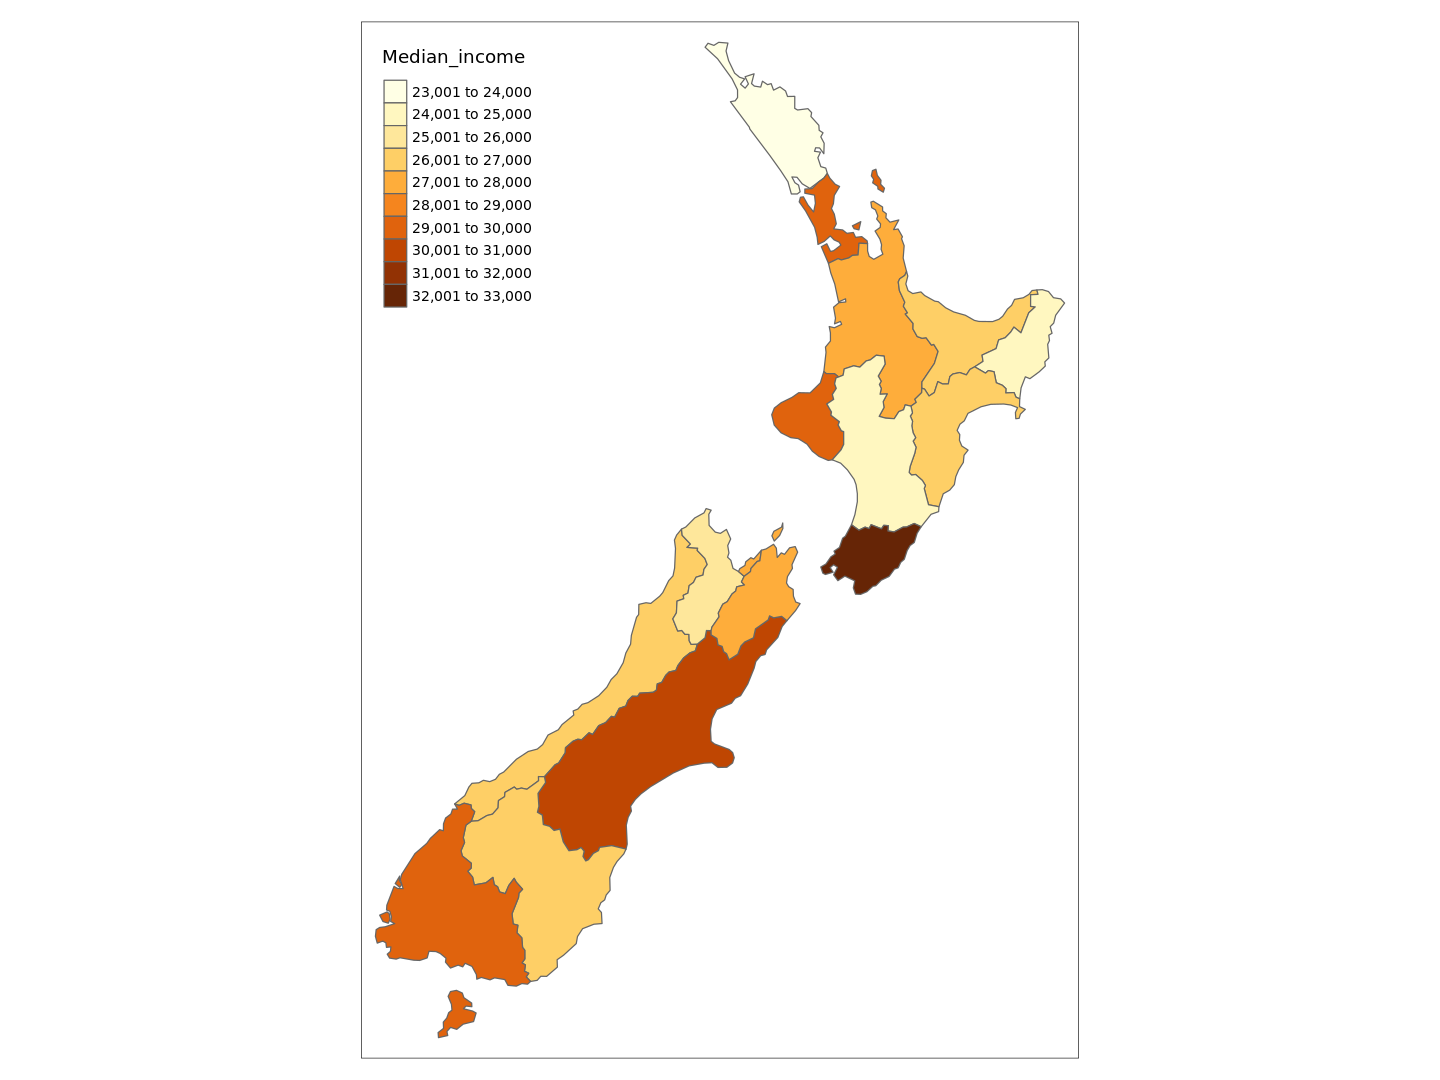

In [67]:
tm_shape(nz) + tm_polygons(col = "Median_income", n = 10)


Likewise, the color scheme can be customized in various ways.

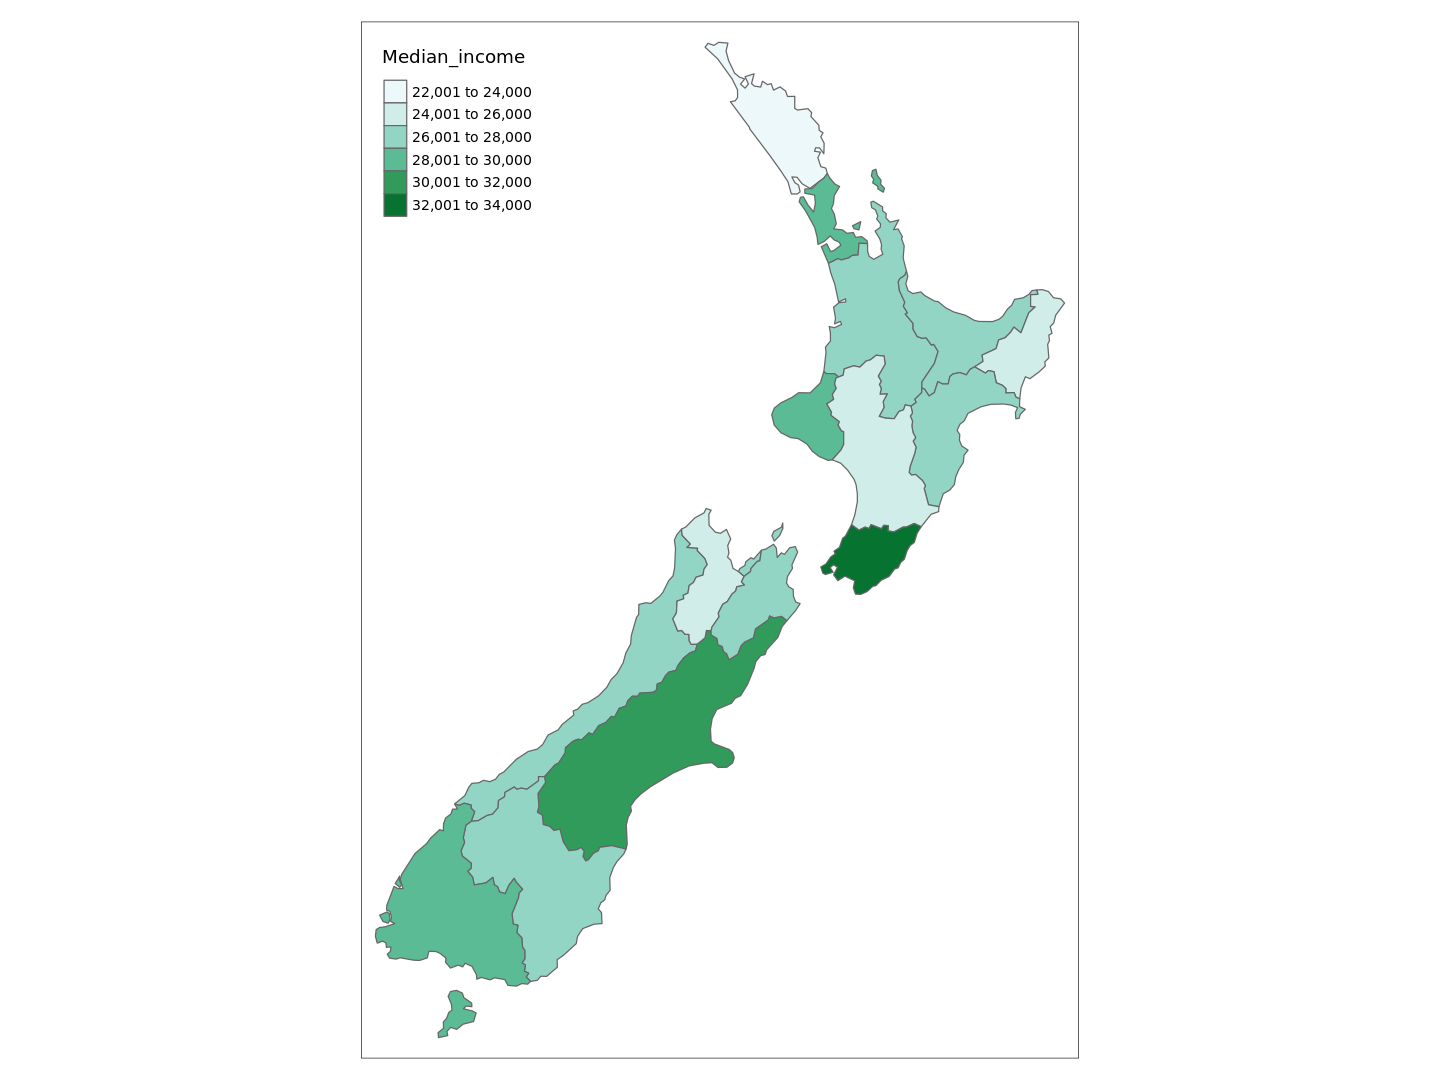

In [68]:
tm_shape(nz) + tm_polygons(col = "Median_income", palette = "BuGn")

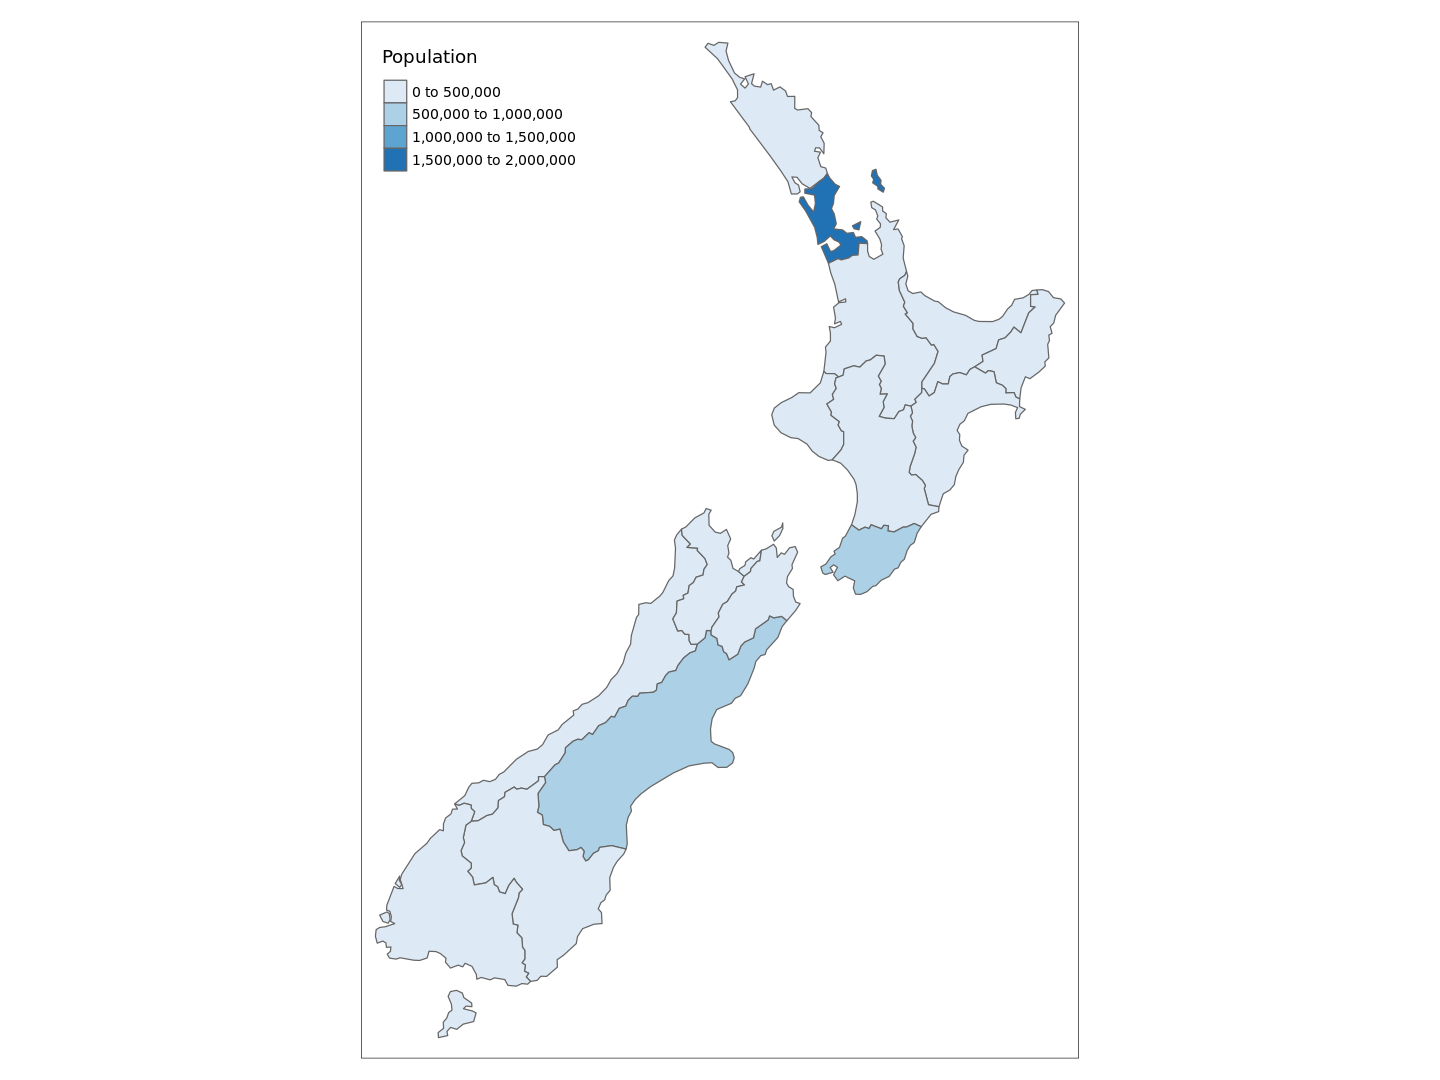

In [69]:
tm_shape(nz) + tm_polygons("Population", palette = "Blues")


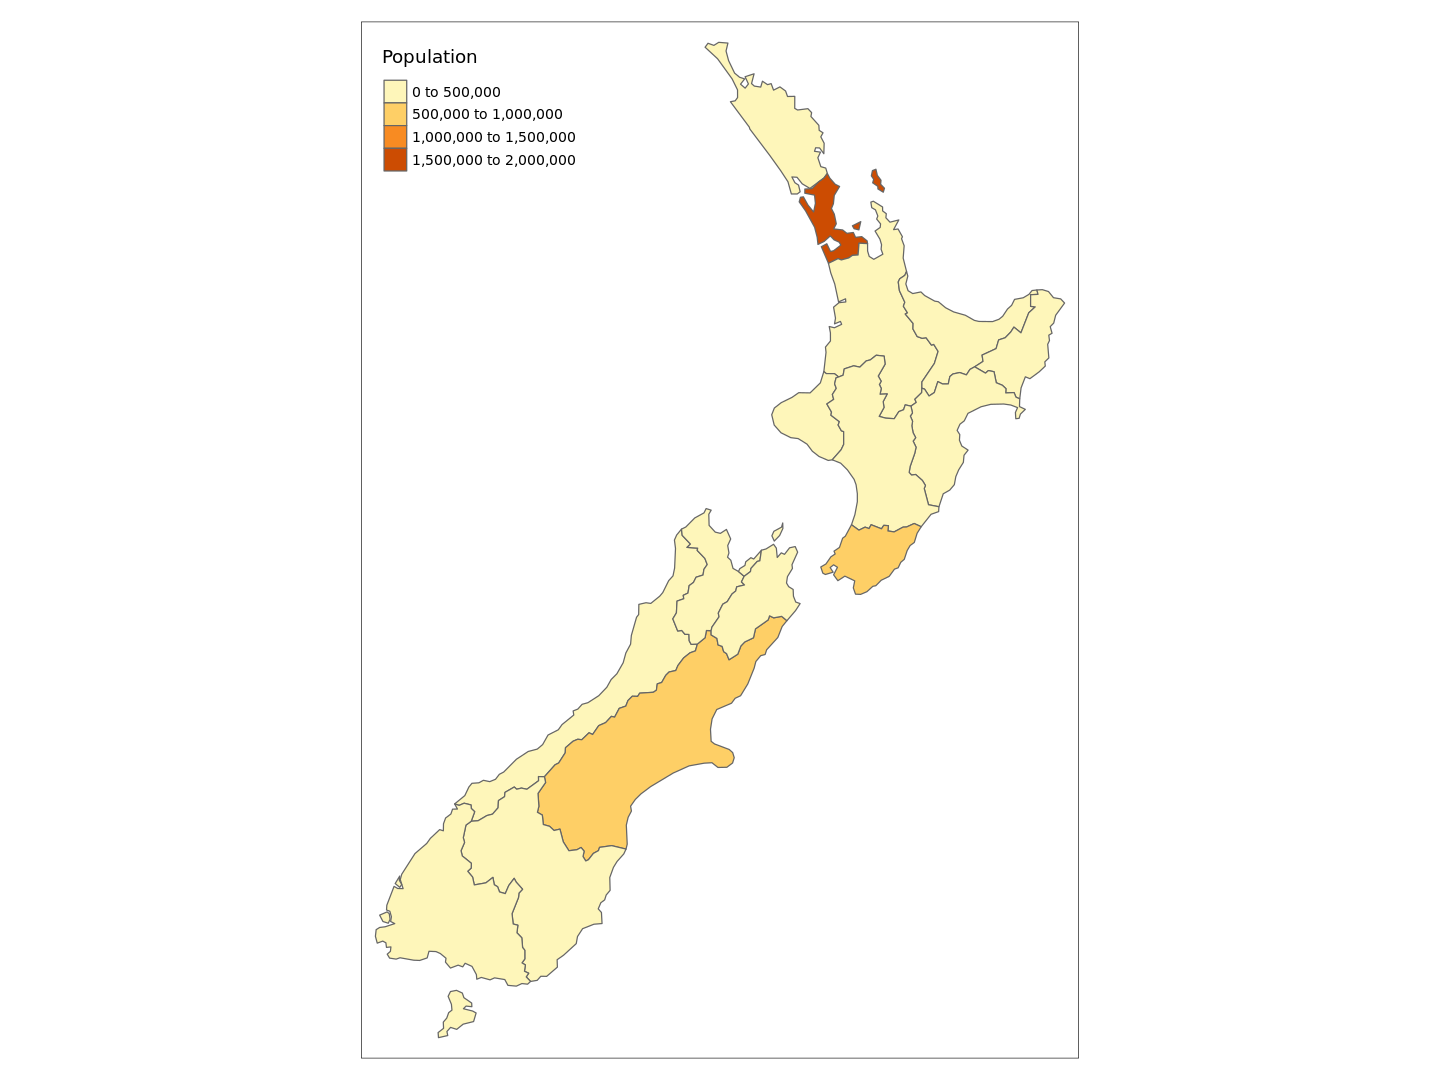

In [70]:
tm_shape(nz) + tm_polygons("Population", palette = "YlOrBr")

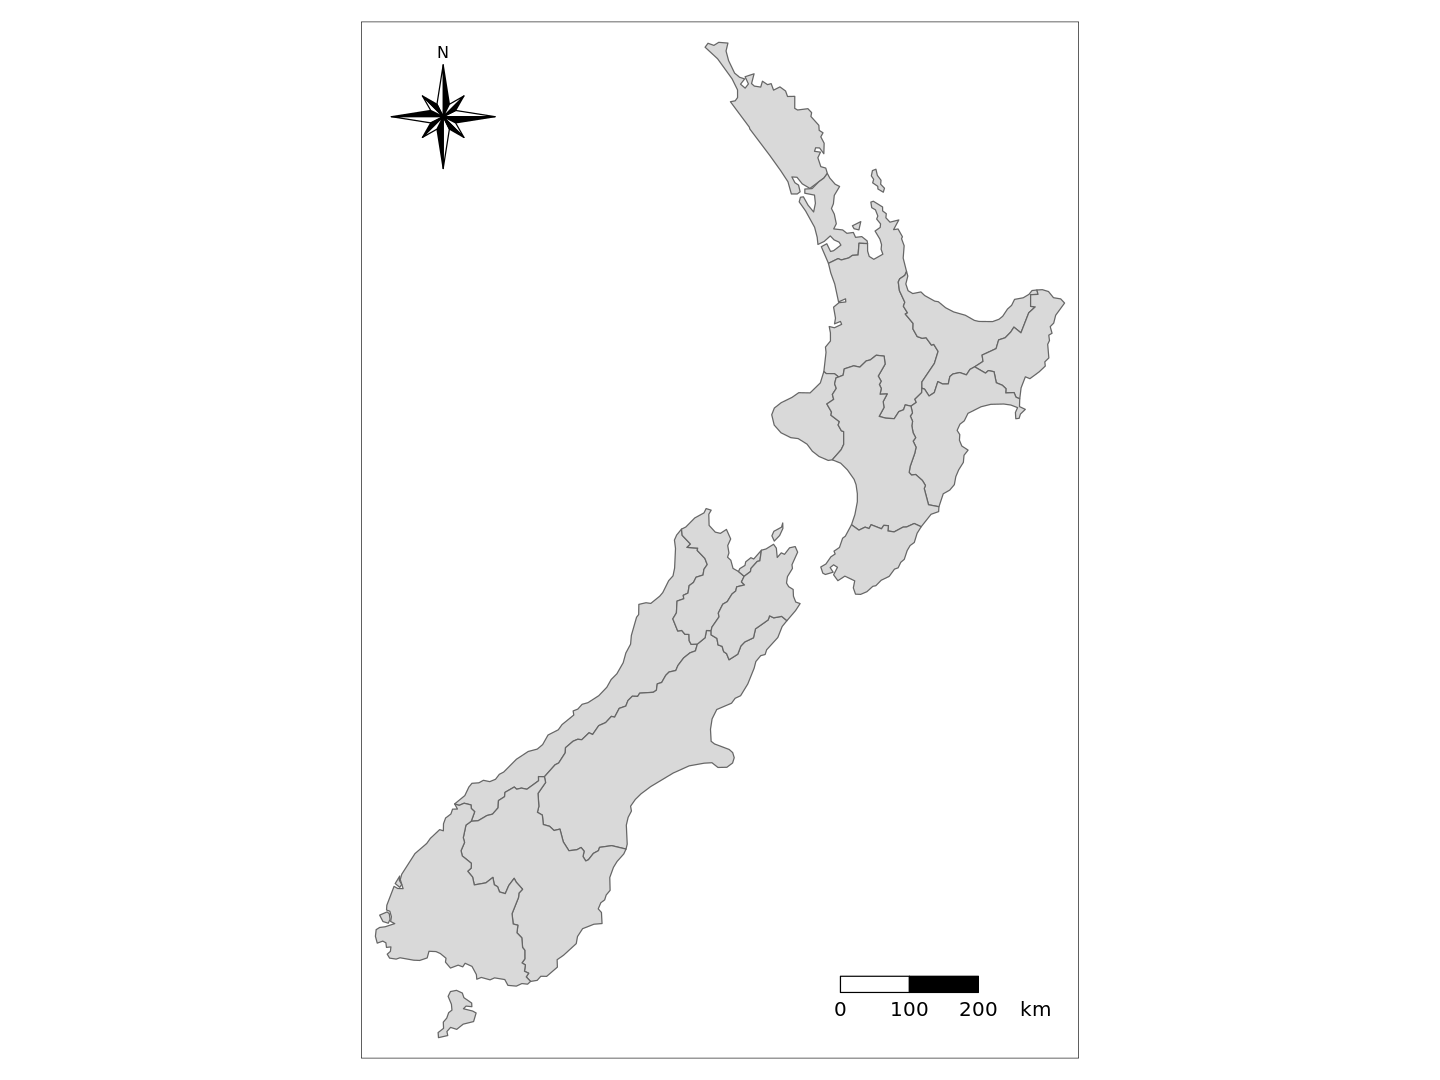

In [71]:
map_nz + 
  tm_compass(type = "8star", position = c("left", "top")) +
  tm_scale_bar(breaks = c(0, 100, 200), text.size = 1)

`tm_layout` controls the general layout of a `tm` graphics.

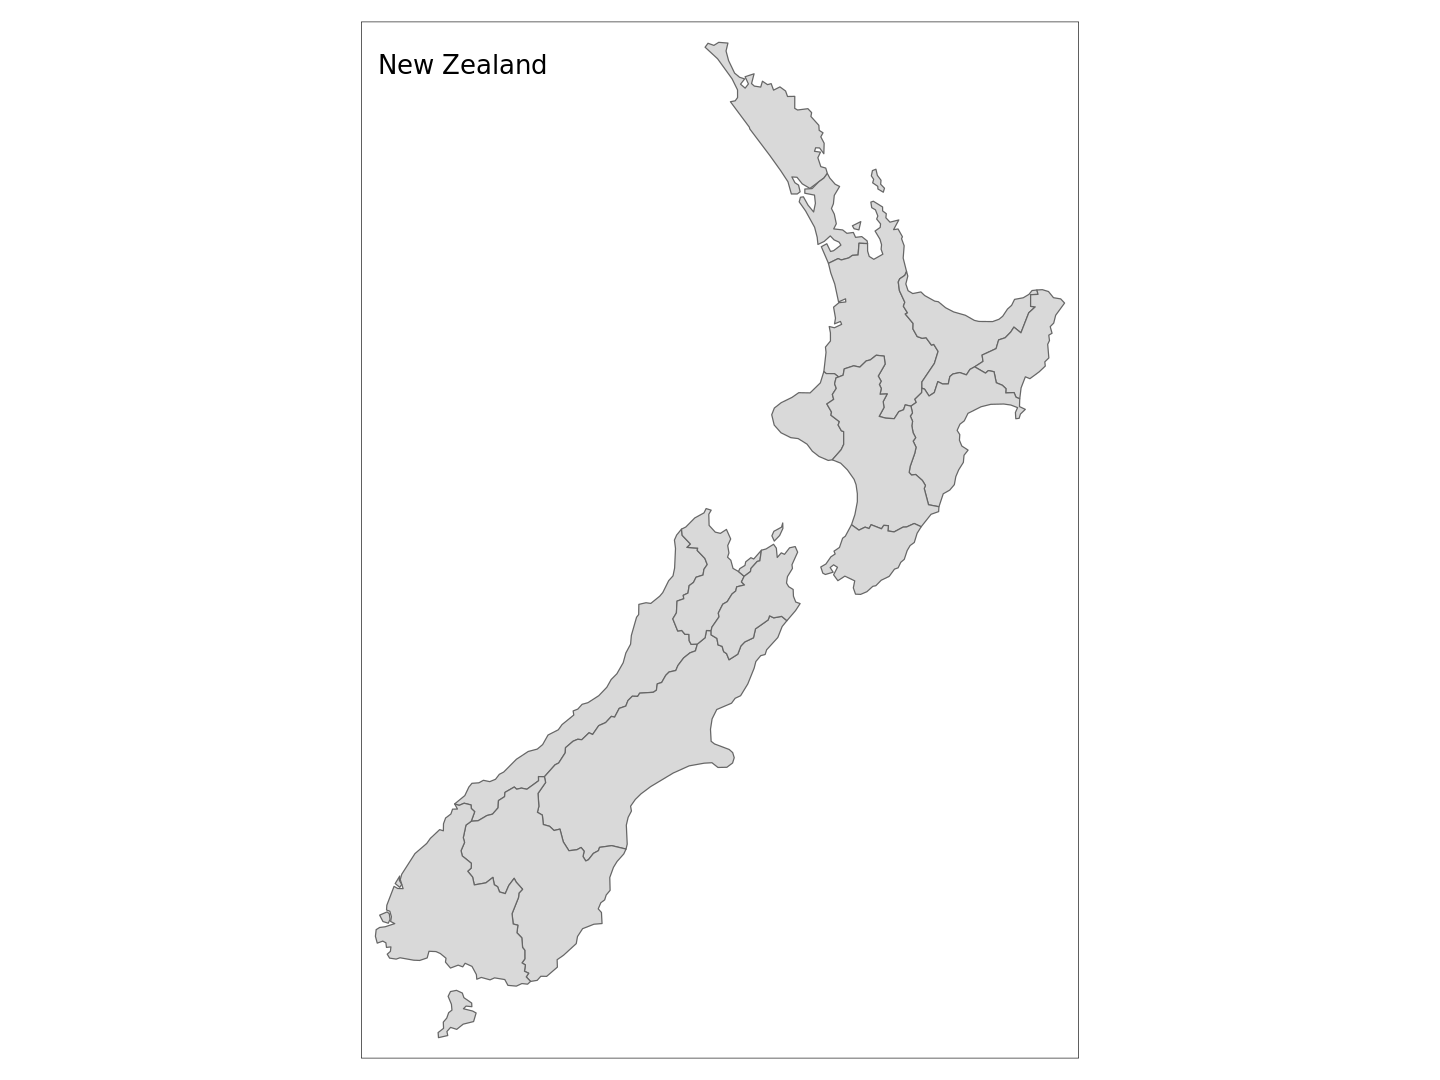

In [72]:
map_nz + tm_layout(title = "New Zealand")


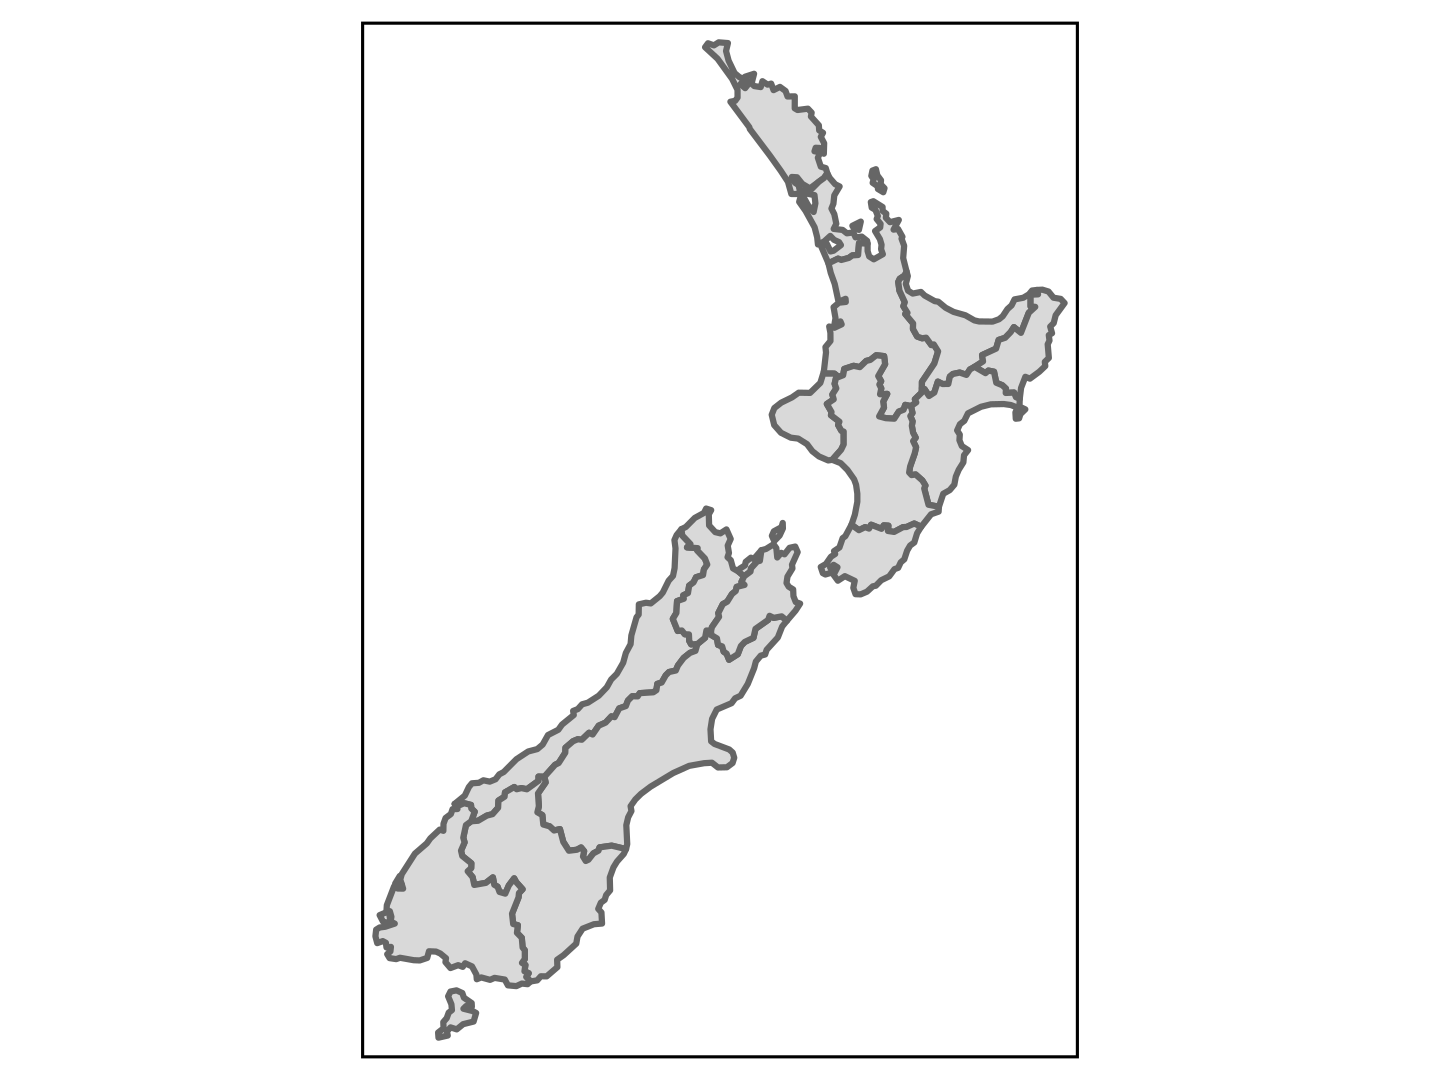

In [73]:
map_nz + tm_layout(scale = 5)


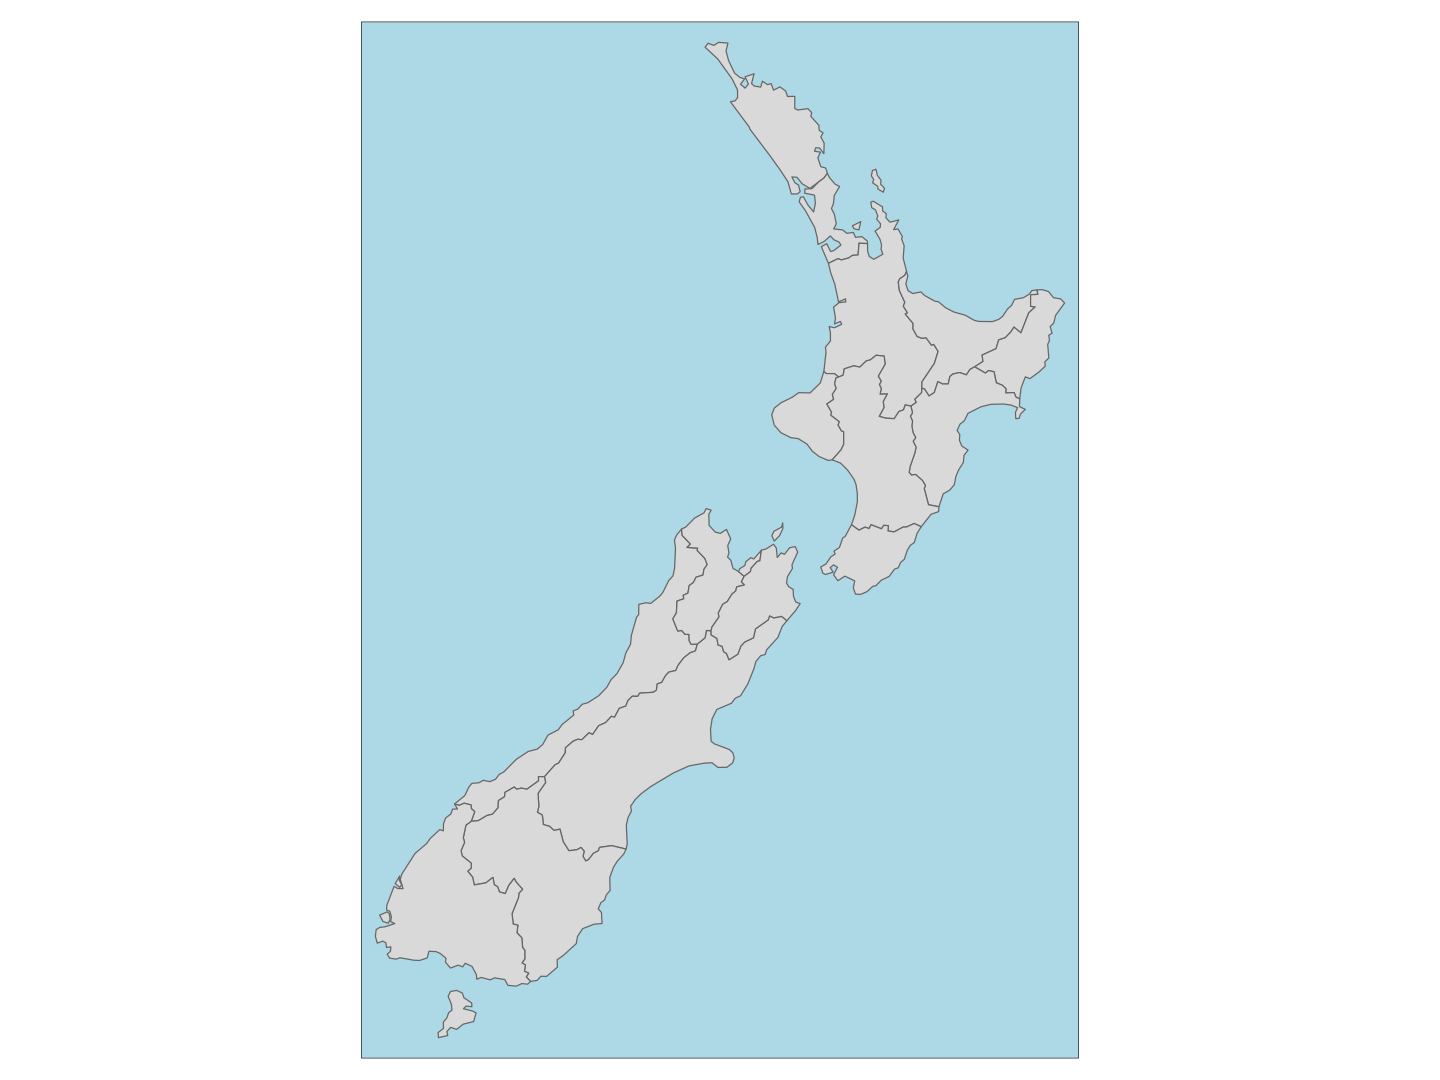

In [74]:
map_nz + tm_layout(bg.color = "lightblue")


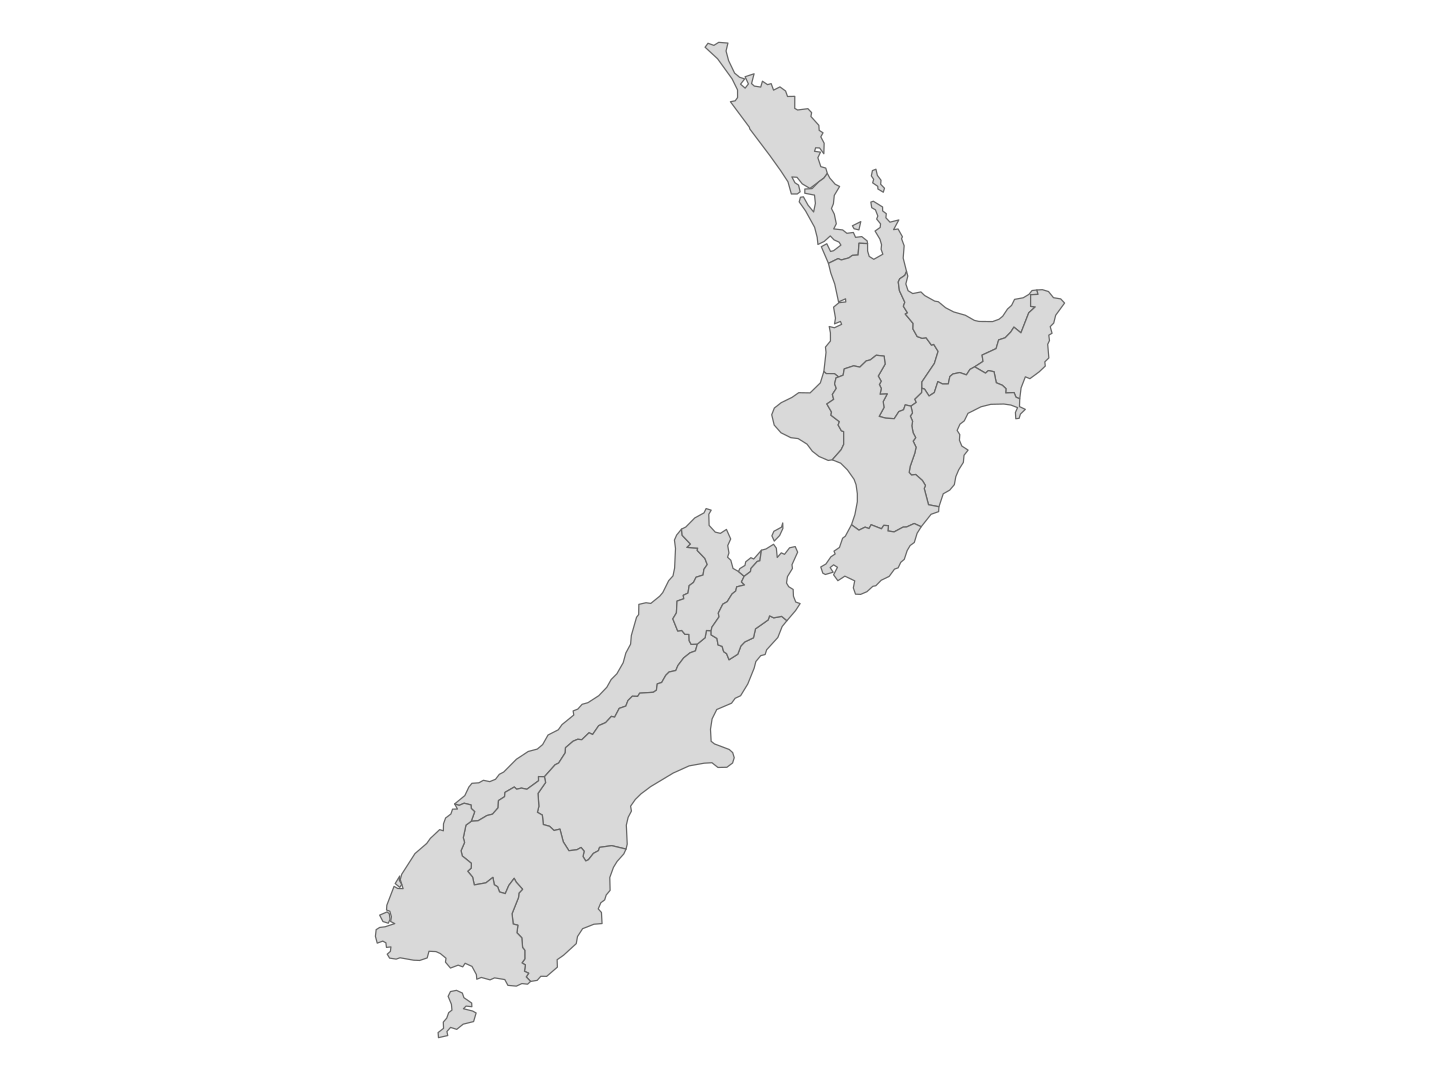

In [75]:
map_nz + tm_layout(frame = FALSE)

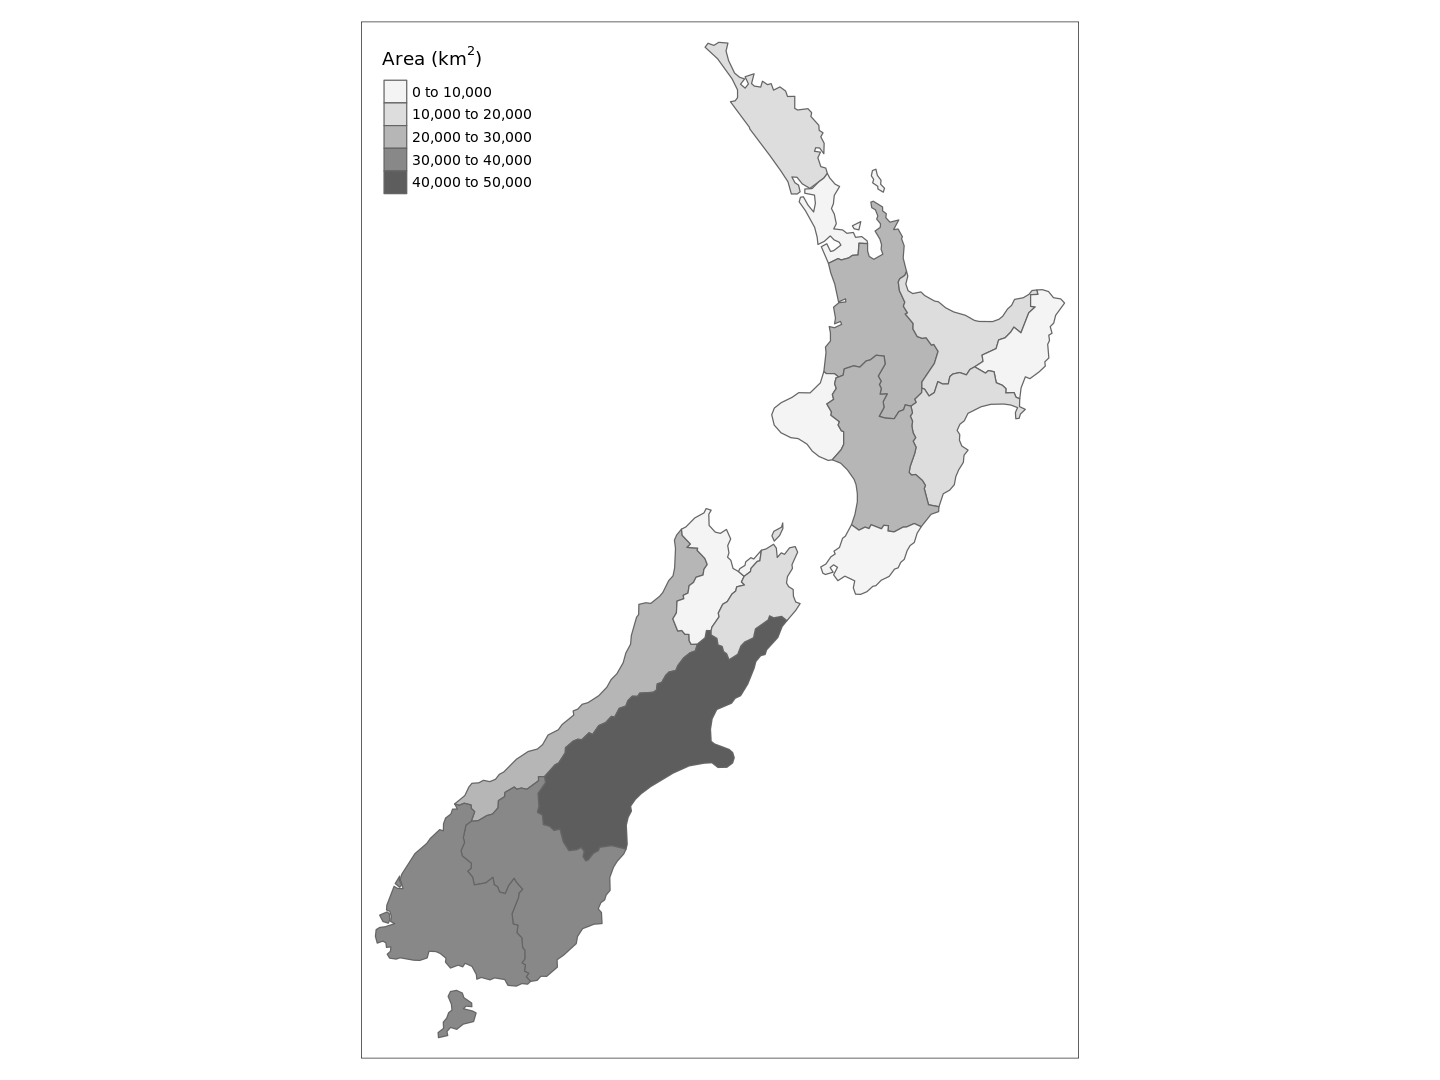

In [76]:
map_nza + tm_style("bw")


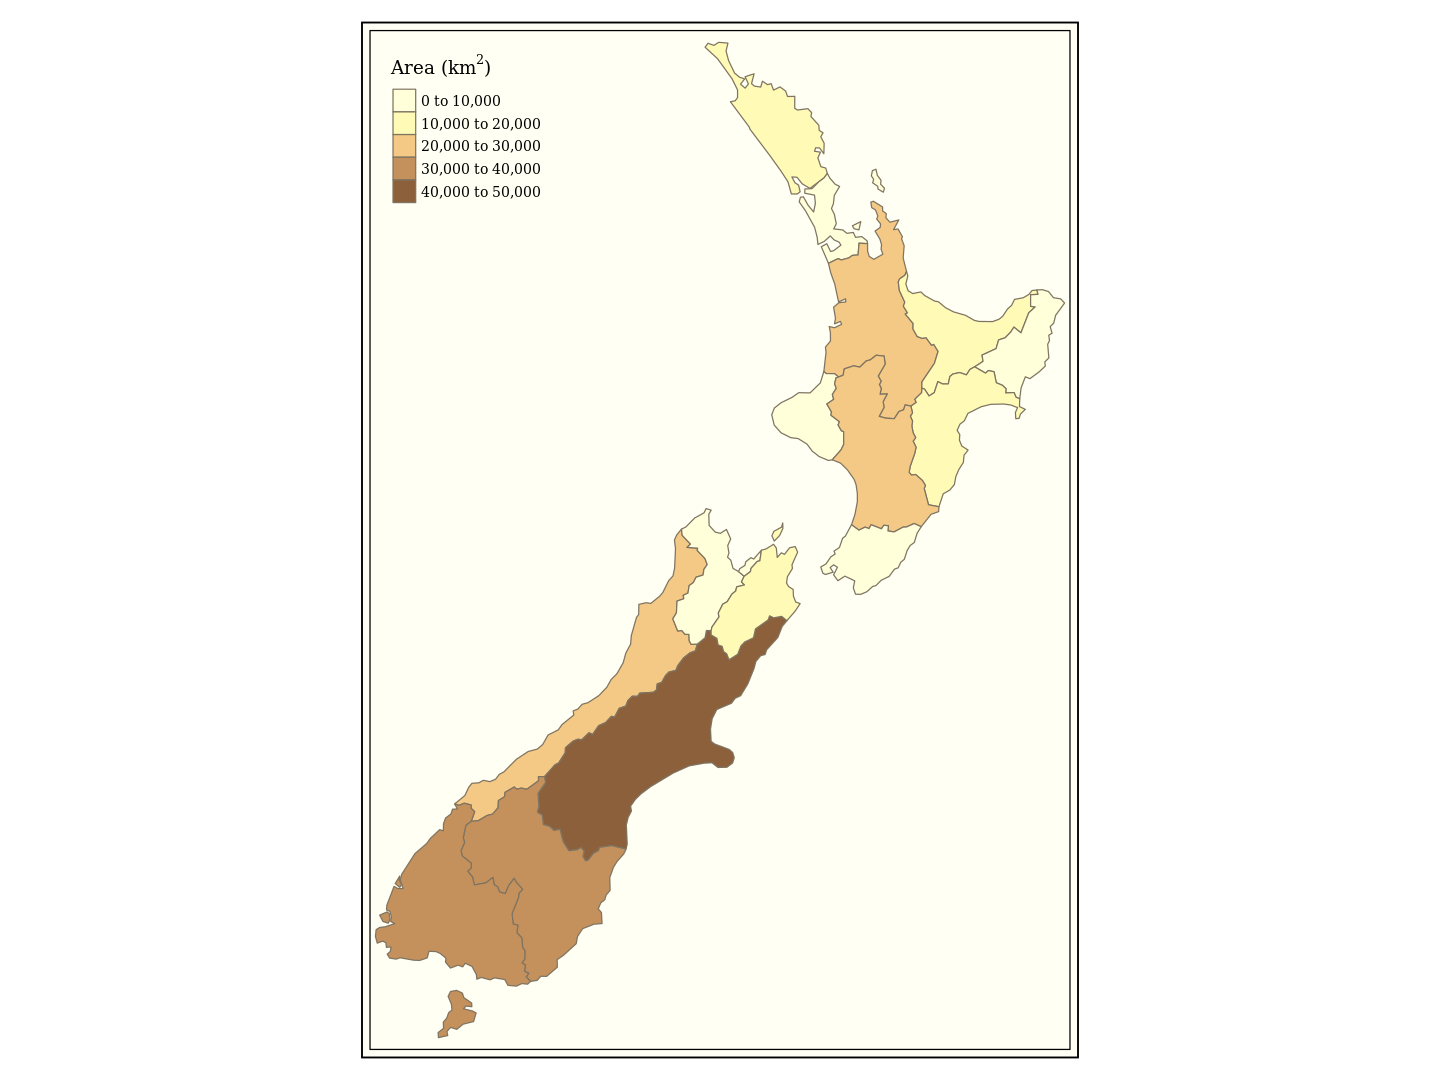

In [77]:
map_nza + tm_style("classic")


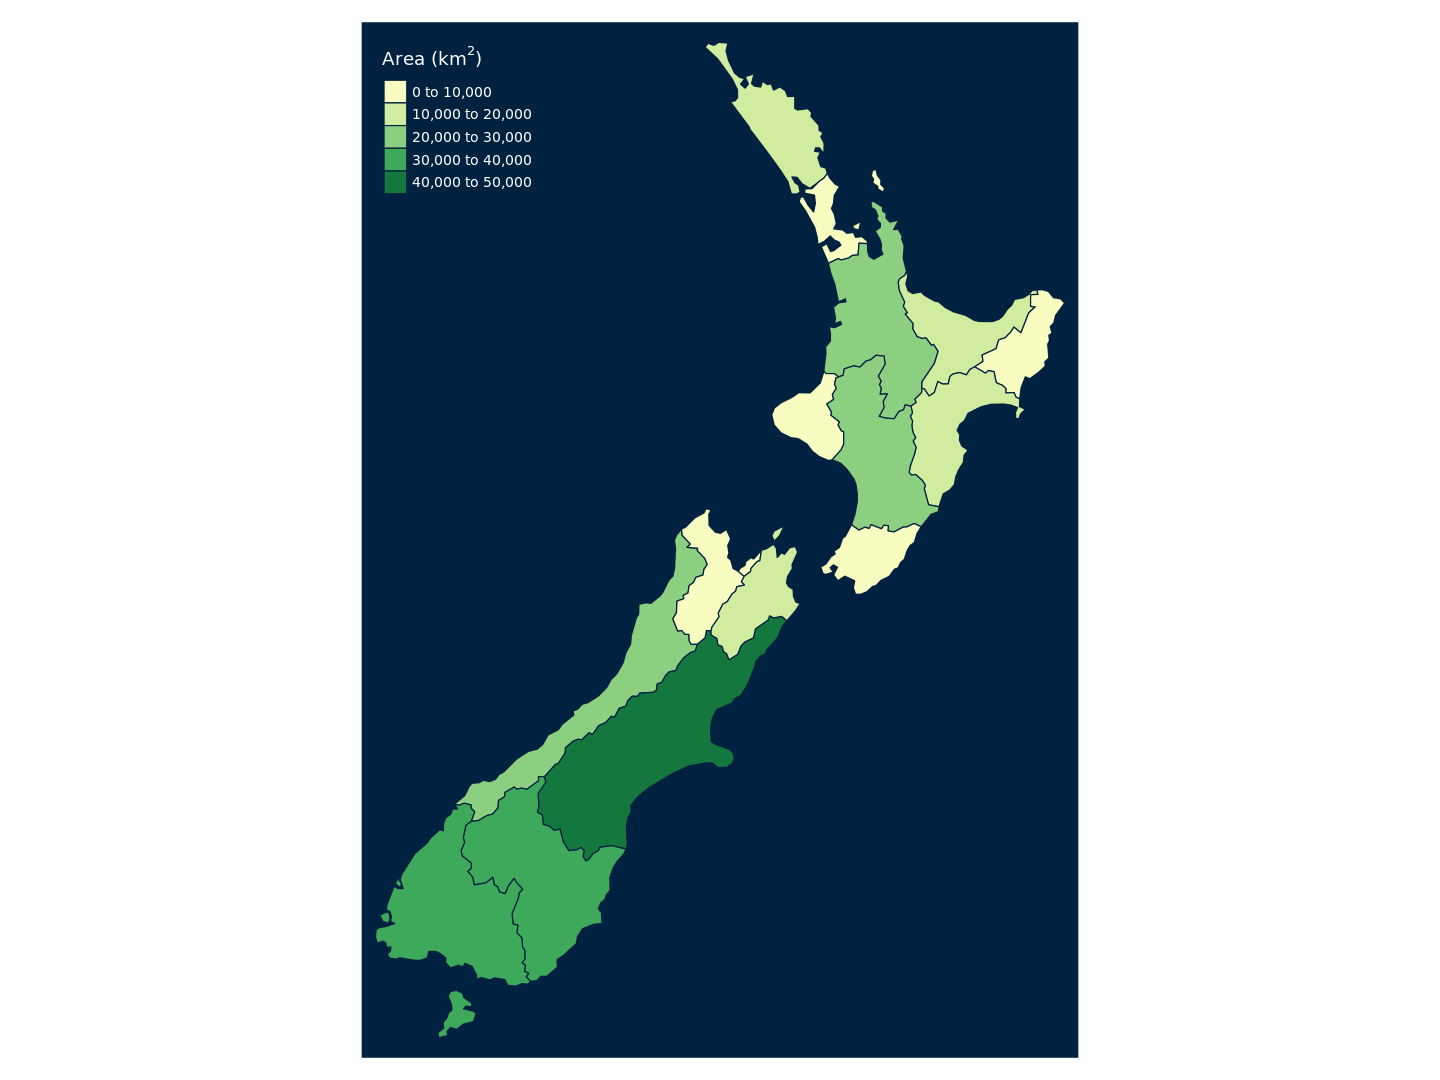

In [78]:
map_nza + tm_style("cobalt")


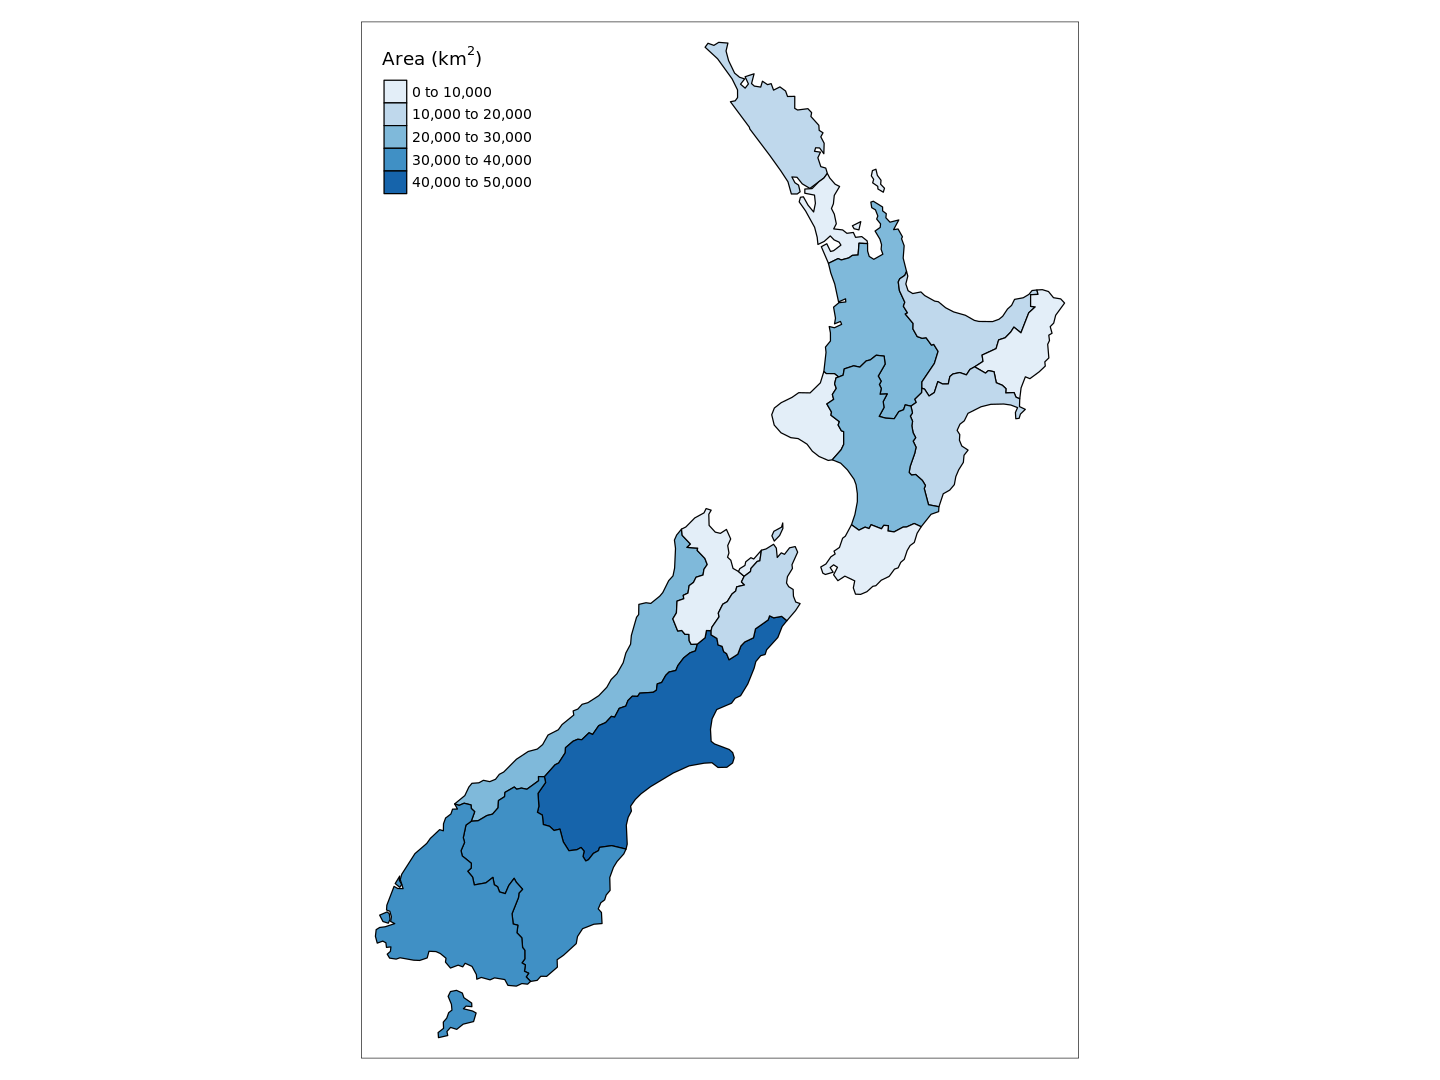

In [79]:
map_nza + tm_style("col_blind")

### Faceted graphics

With `tm_facets`, faceted graphics are produced

In [80]:
urb_1970_2030 = urban_agglomerations %>% 
  filter(year %in% c(1970, 1990, 2010, 2030))

urb_1970_2030 %>%
    slice_sample(n=10)

index year rank\norder country\ncode country_or_area city_code
1  419   1970 20          586           Pakistan        22044    
2  387   1990  4          484           Mexico          21853    
3  107   2030 14          156           China           20484    
4   49   2010 16           76           Brazil          20272    
5  139   2010  3          156           China           20656    
6  103   2010 20          156           China           20484    
7  229   2010  9          818           Egypt           22812    
8  283   2010  2          356           India           21228    
9  491   1970 21          792           Turkey          22691    
10  13   2010 12           32           Argentina       20058    
   urban_agglomeration            note population_millions
1  Karachi                        NA    3.118723          
2  Ciudad de México (Mexico City) 12   15.642318          
3  Chongqing                       4   19.649097          
4  Rio de Janeiro                 NA   12.373884          
5  Shanghai                        5   20.314309          
6  Chongqing                       4   11.243667          
7  Al-Qahirah (Cairo)              7   16.899015          
8  Delhi                           8   21.987895          
9  Istanbul                       NA    2.772095          
10 Buenos Aires                    1   14.245871          
   geometry                   
1  POINT (67.0822 24.9056)    
2  POINT (-99.14187 19.42732) 
3  POINT (106.5528 29.56278)  
4  POINT (-43.2075 -22.90278) 
5  POINT (121.4581 31.22222)  
6  POINT (106.5528 29.56278)  
7  POINT (31.23941 30.03917)  
8  POINT (77.21667 28.66667)  
9  POINT (28.9497 41.0138)    
10 POINT (-58.40037 -34.60508)

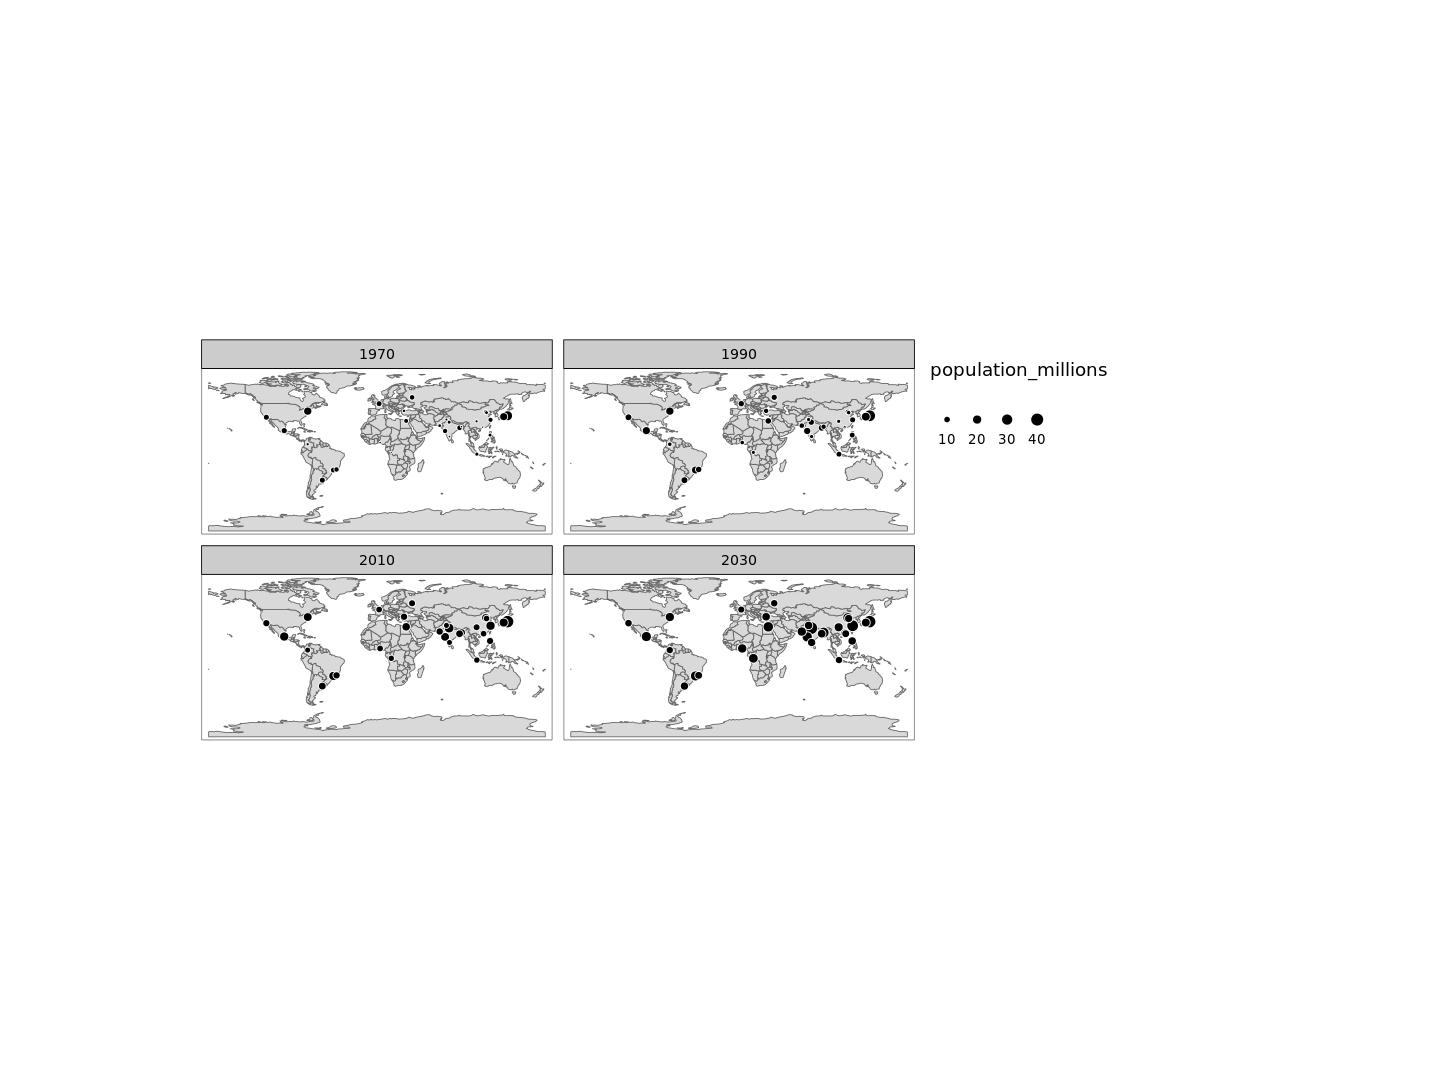

In [81]:

tm_shape(world) +
  tm_polygons() +
  tm_shape(urb_1970_2030) +
  tm_symbols(col = "black", border.col = "white", size = "population_millions") +
  tm_facets(by = "year", nrow = 2, free.coords = FALSE)

## Inlays

The package `grid` allows to produce inlay maps.

In [82]:
nz_region = st_bbox(c(xmin = 1340000, xmax = 1450000,
                      ymin = 5130000, ymax = 5210000),
                    crs = st_crs(nz_height)) %>% 
  st_as_sfc()
nz_region

POLYGON ((1340000 5130000, 1450000 5130000, 145...



Geometry set for 1 feature 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1340000 ymin: 5130000 xmax: 1450000 ymax: 5210000
CRS:           EPSG:2193

stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



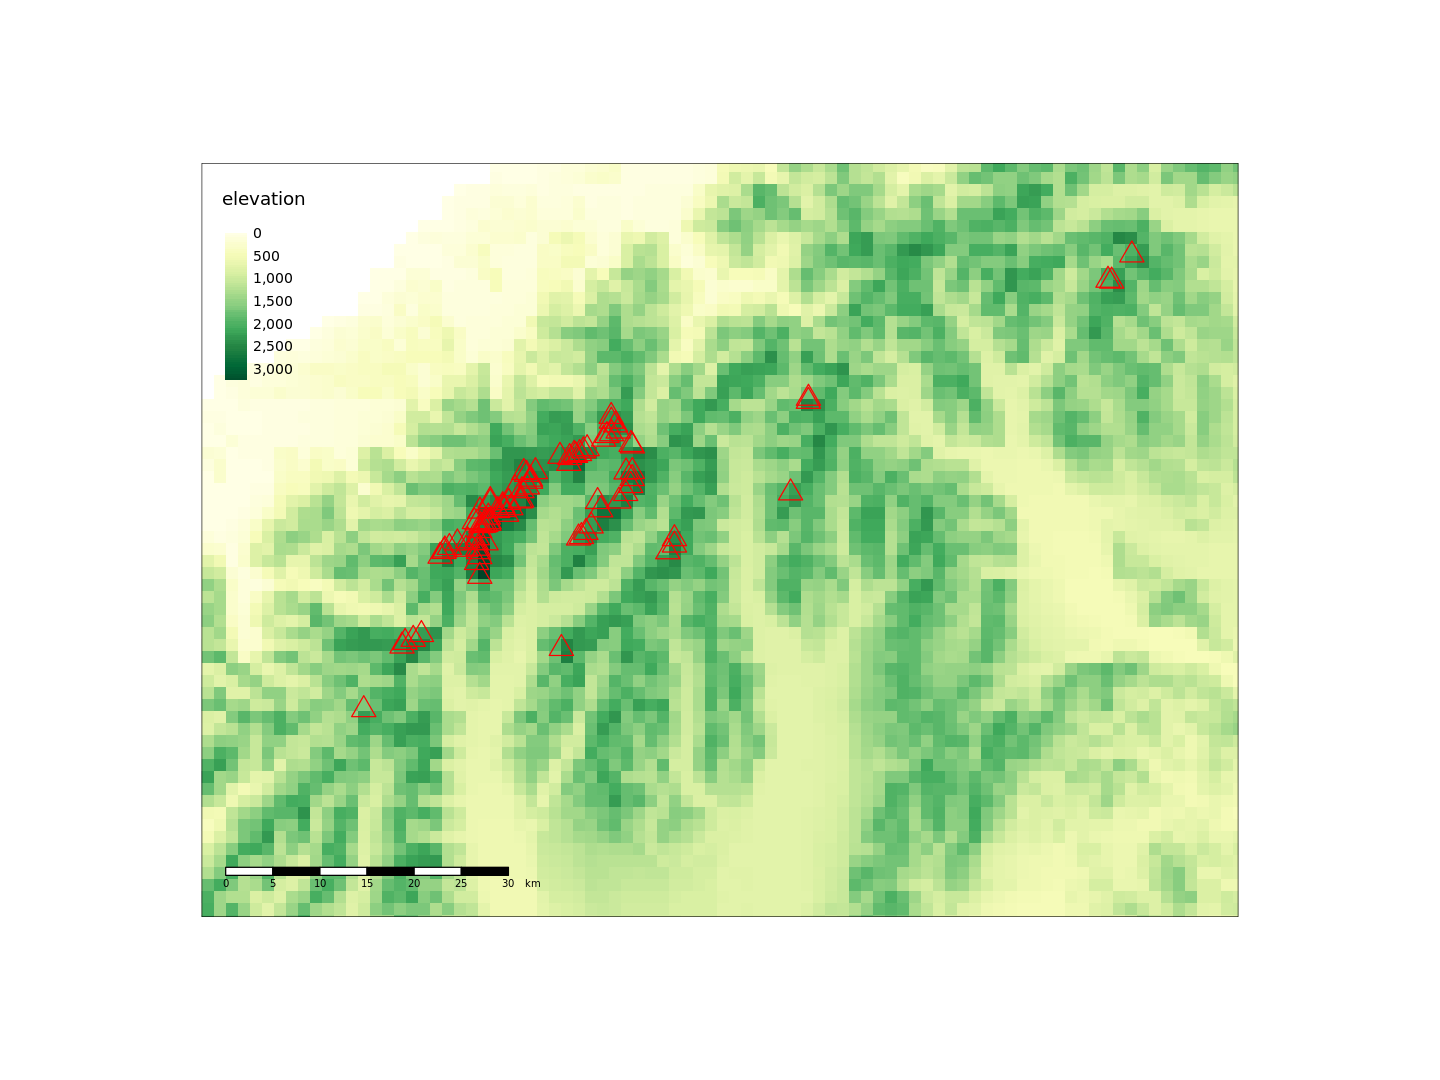

In [83]:
nz_height_map = tm_shape(nz_elev, bbox = nz_region) +
  tm_raster(style = "cont", palette = "YlGn", legend.show = TRUE) +
  tm_shape(nz_height) + tm_symbols(shape = 2, col = "red", size = 1) +
  tm_scale_bar(position = c("left", "bottom"))
nz_height_map

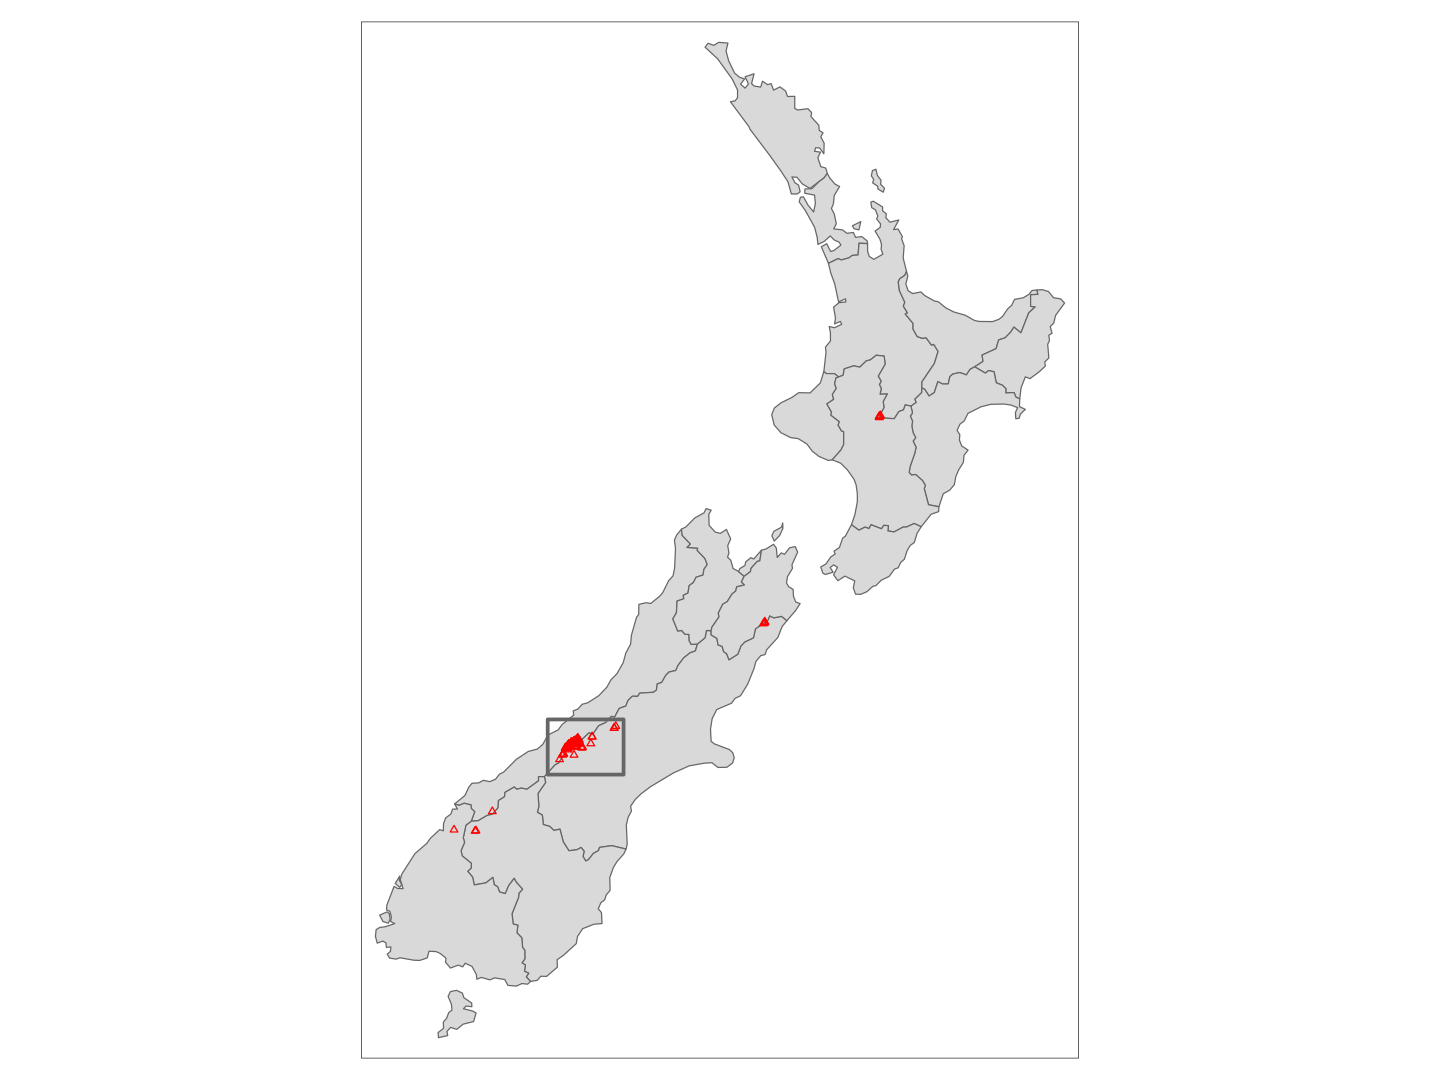

In [84]:
nz_map = tm_shape(nz) + tm_polygons() +
  tm_shape(nz_height) + tm_symbols(shape = 2, col = "red", size = 0.1) + 
  tm_shape(nz_region) + tm_borders(lwd = 3) 
nz_map


Attaching package: ‘grid’


The following object is masked from ‘package:terra’:

    depth


stars object downsampled to 877 by 1140 cells. See tm_shape manual (argument raster.downsample)



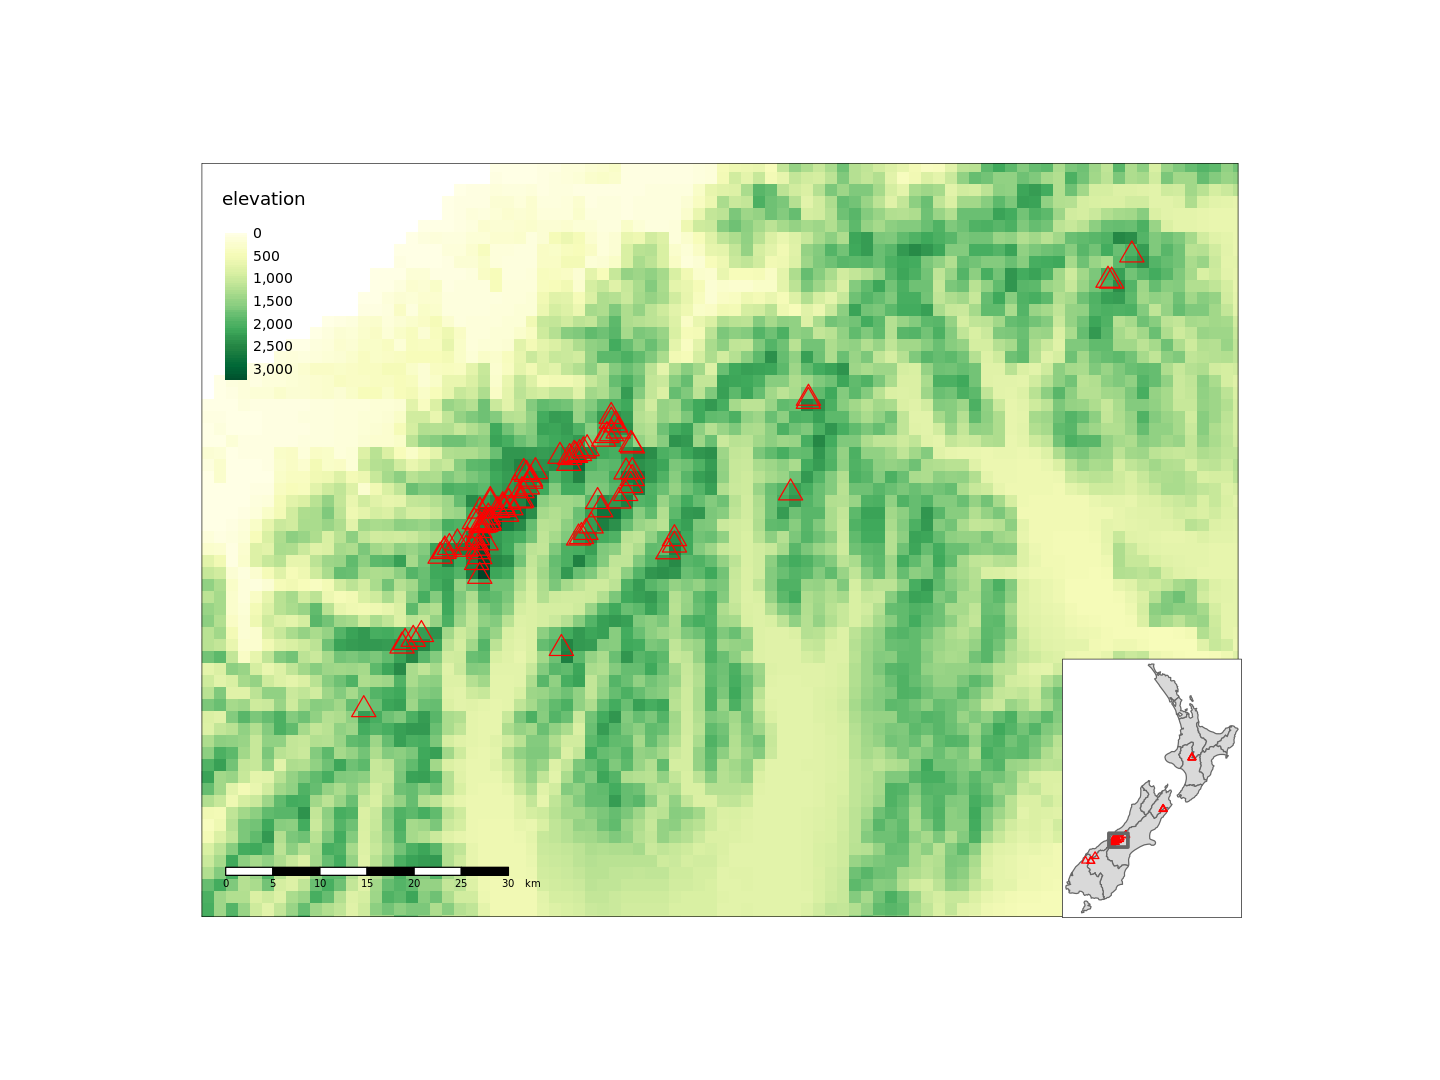

In [85]:
library(grid)
nz_height_map
print(nz_map, vp = viewport(0.8, 0.27, width = 0.5, height = 0.25))

Another example: US map

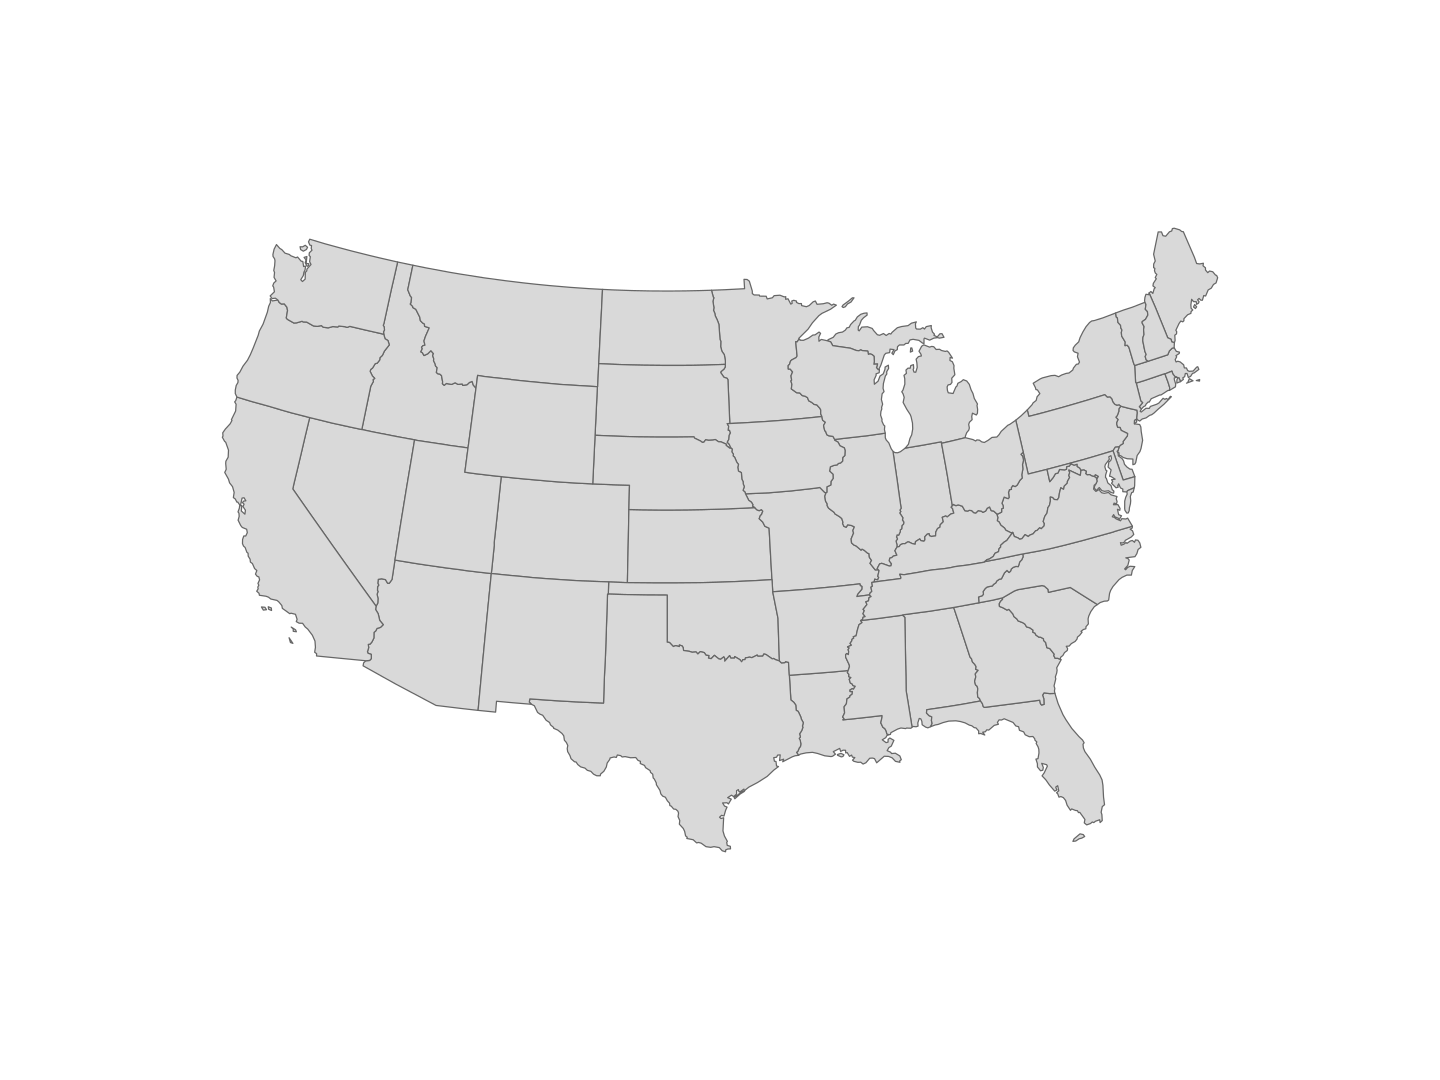

In [86]:
us_states_map = tm_shape(us_states, projection = 2163) + tm_polygons() + 
  tm_layout(frame = FALSE)
us_states_map

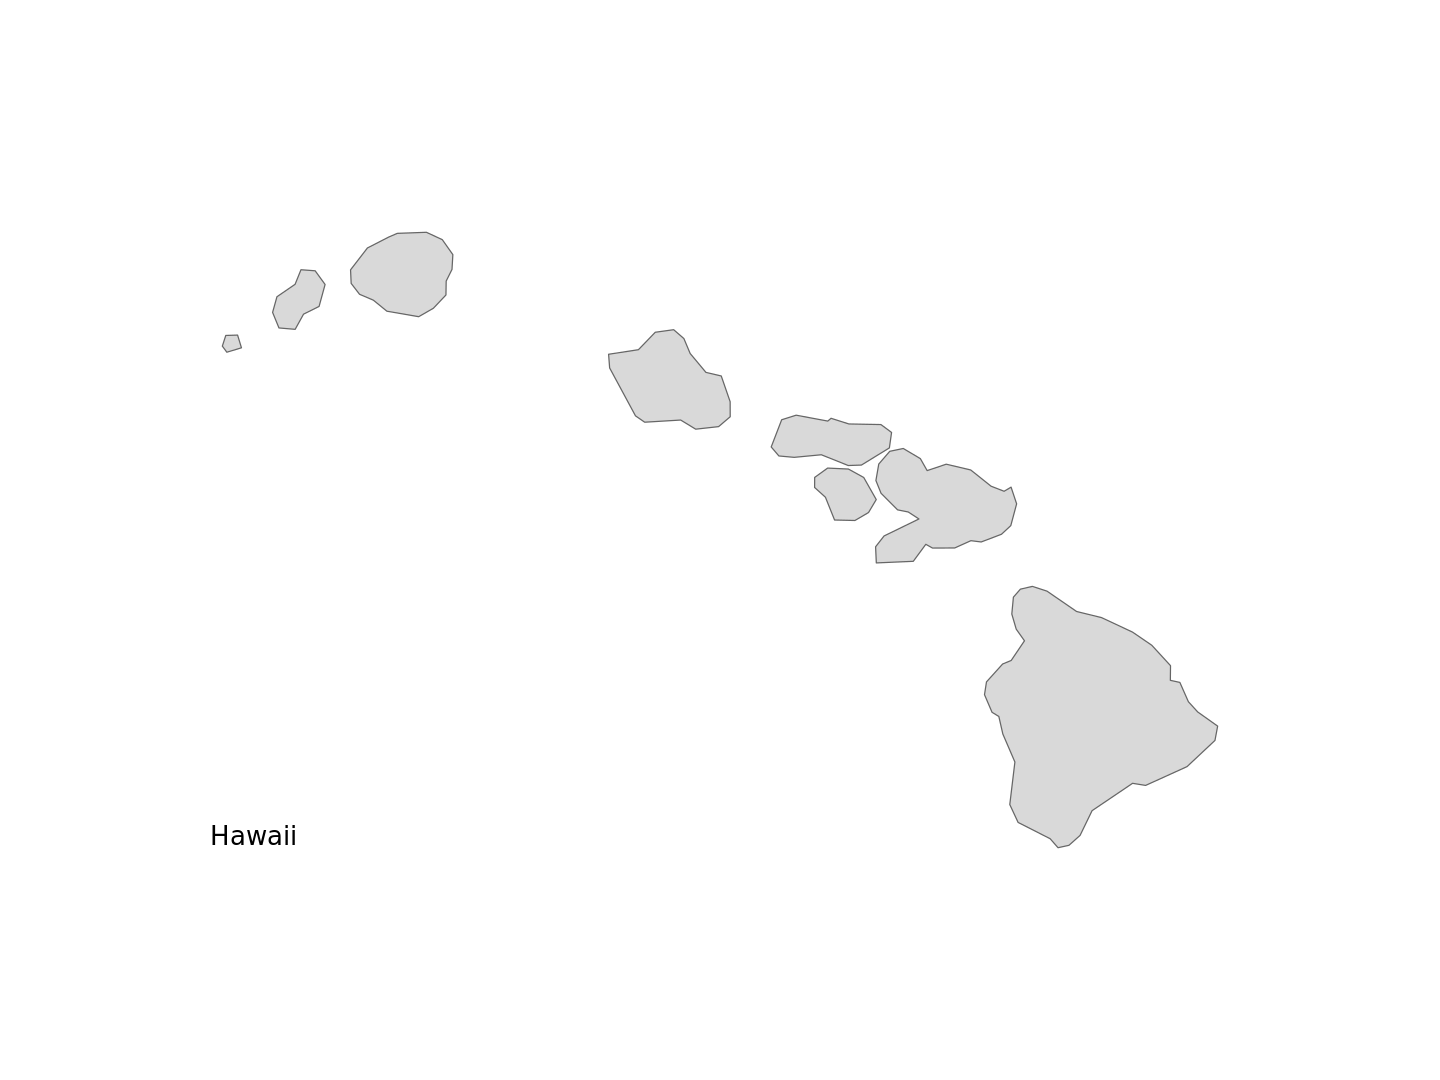

In [87]:
(hawaii_map = tm_shape(hawaii) + tm_polygons() + 
  tm_layout(title = "Hawaii", frame = FALSE, bg.color = NA, 
            title.position = c("LEFT", "BOTTOM")))


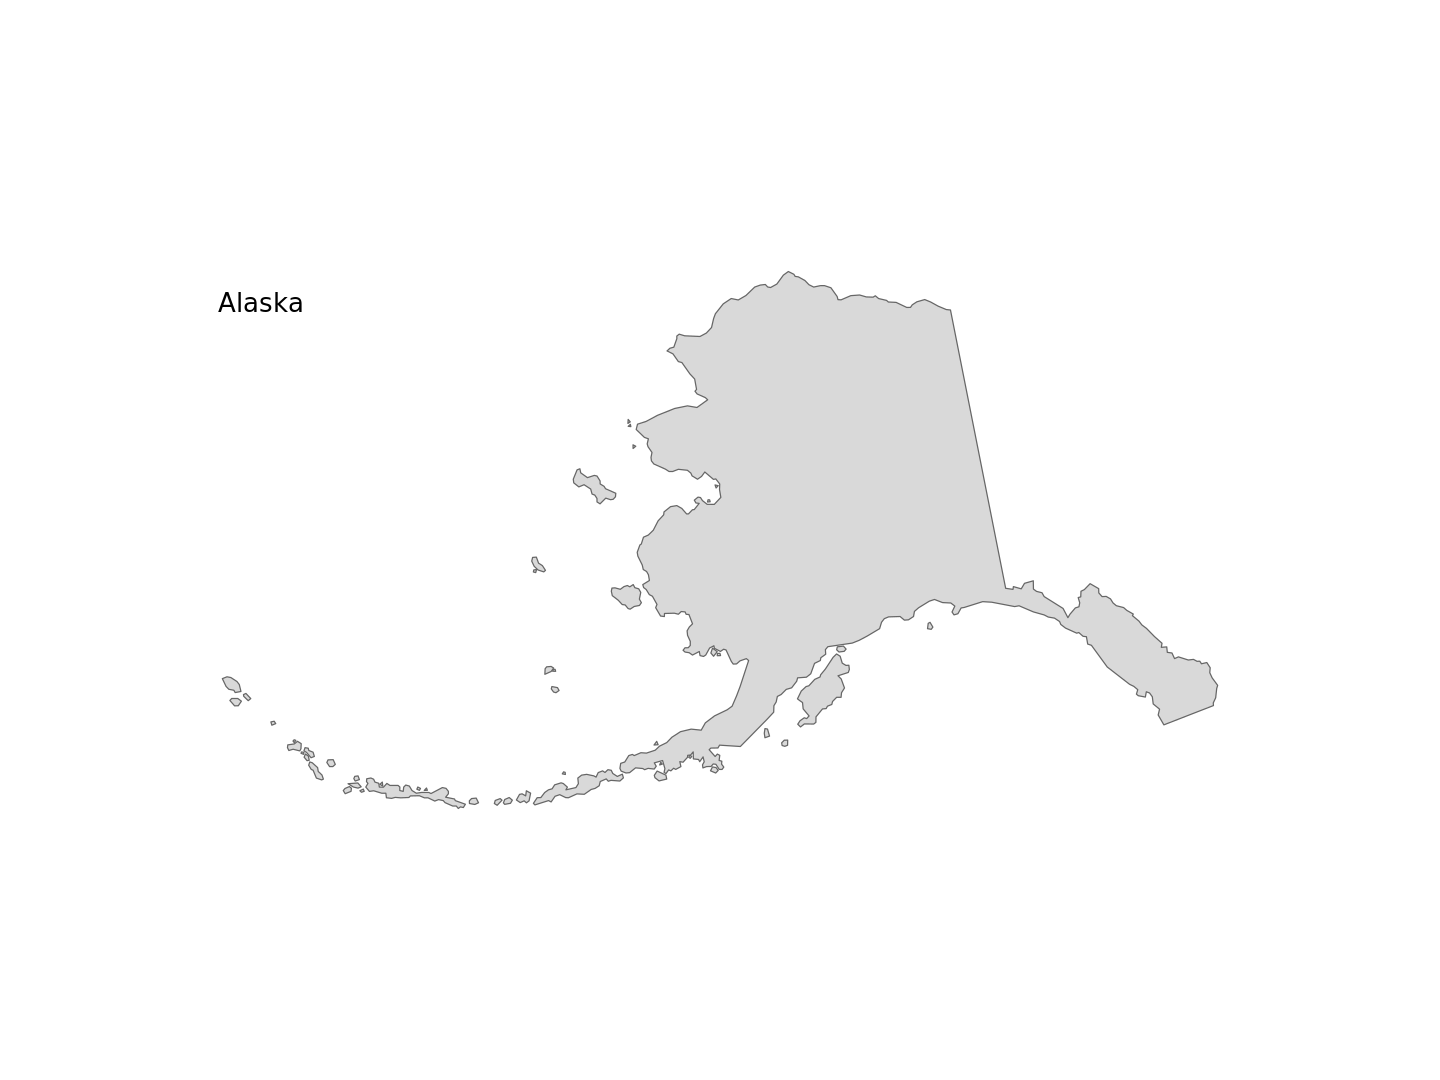

In [88]:
(alaska_map = tm_shape(alaska) + tm_polygons() + 
  tm_layout(title = "Alaska", frame = FALSE, bg.color = NA))

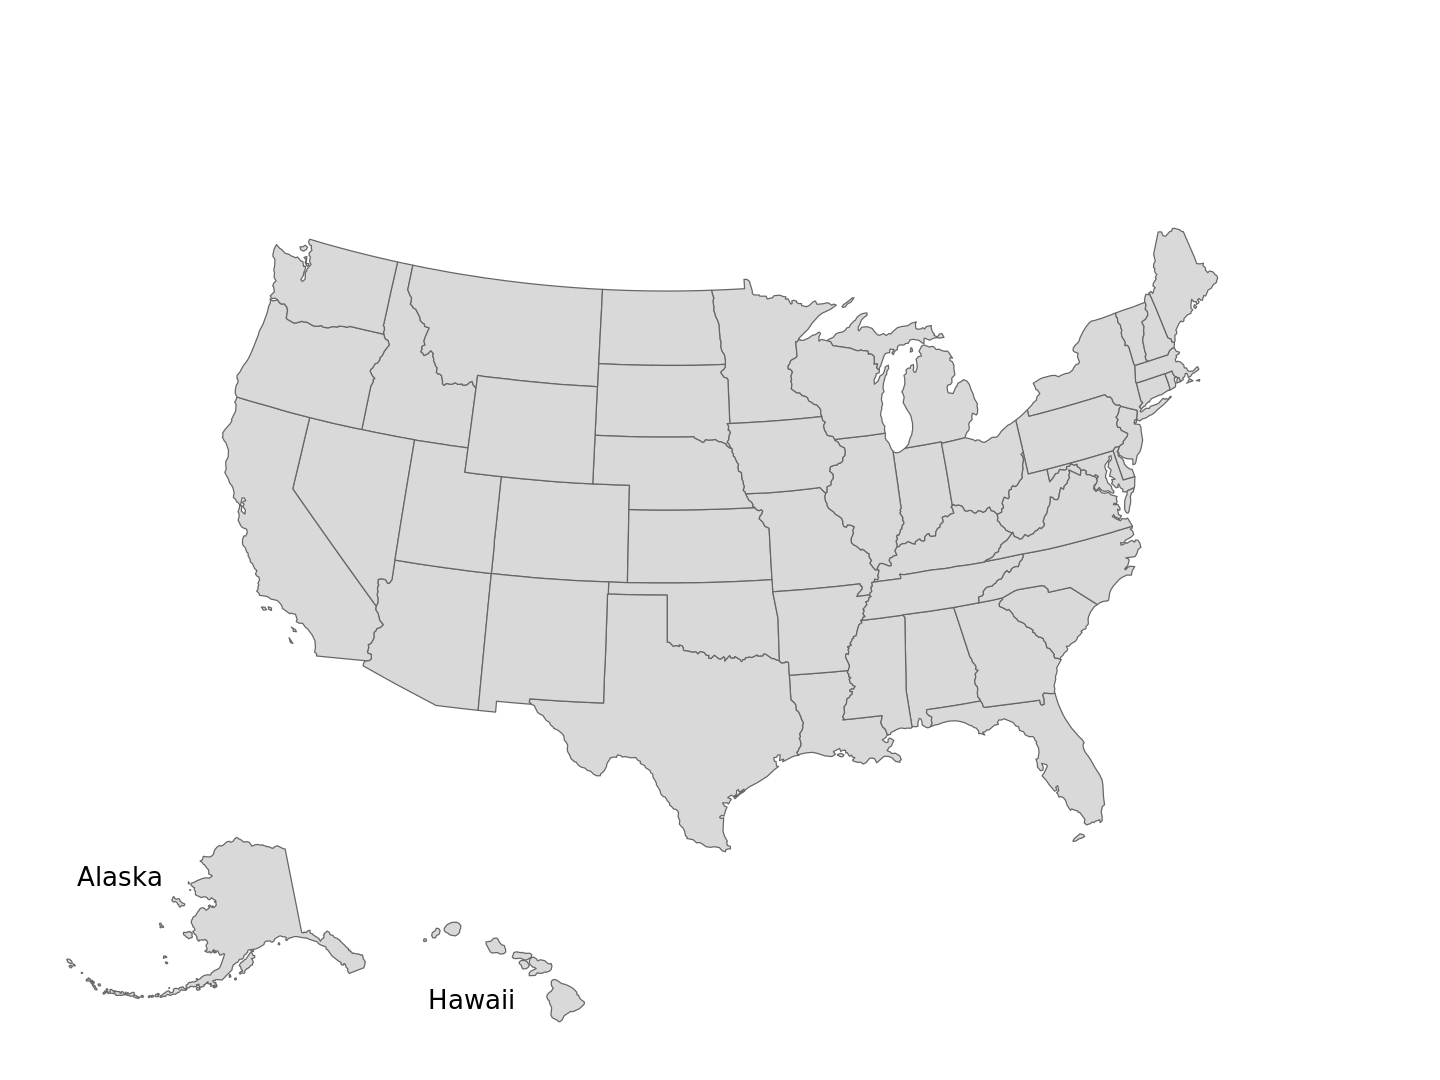

In [89]:
us_states_map
print(hawaii_map, vp = grid::viewport(0.35, 0.1, width = 0.2, height = 0.1))
print(alaska_map, vp = grid::viewport(0.15, 0.15, width = 0.3, height = 0.3))

## Animated maps

With `tmap_animation`, faceted maps can be converted to animated `gif`s.

In [90]:
urb_anim = tm_shape(world) + tm_polygons() + 
  tm_shape(urban_agglomerations) + tm_dots(size = "population_millions") +
  tm_facets(along = "year", free.coords = FALSE)

In [93]:
tmap_animation(urb_anim, filename = "urb_anim.gif", delay = 25)

Creating frames
Creating animation
Animation saved to /home/jovyan/urb_anim.gif 


<img src="urb_anim.gif" width="750" align="center">